## Analiza skupień państw i narodów w kontekście gospodarczo-politycznym

Projekt zaliczeniowy na przedmiot Eksploracja Danych

## 1. Importowanie bibliotek

In [1]:
# Importowanie bibliotek
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import euclidean
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings

warnings.filterwarnings("ignore")

## 2. Funkcje - wczytanie danych i wykresy


In [2]:
def load_and_clean_data(data_files, index_file_path='../data/index.csv', max_nan_percent=0.5, apply_log_transform=False):

    try:
        index_df = pd.read_csv(index_file_path, keep_default_na=False, na_values=[])
        if 'iso_3166_1_alpha_3' not in index_df.columns or 'location_key' not in index_df.columns:
            raise KeyError("Index file must contain 'iso_3166_1_alpha_3' and 'location_key' columns.")
        alpha3_to_alpha2_map = dict(zip(index_df['iso_3166_1_alpha_3'], index_df['location_key']))
    except FileNotFoundError:
        print(f"Error: Index file '{index_file_path}' not found!")
        return None, None, None

    raw_data = {}
    for key, file in data_files.items():
        try:
            df = pd.read_csv(file)
            df.replace("..", np.nan, inplace=True)
            df['Country Code'] = df['Country Code'].map(alpha3_to_alpha2_map)
            df = df[df['Country Code'].notna()]
            df.reset_index(drop=True, inplace=True)

            if "Country Code" in df.columns:
                df["location_key"] = df["Country Code"]
                df.drop(columns=["Country Code"], inplace=True)

            if "Country Name" in df.columns:
                df.rename(columns={"Country Name": "country_name"}, inplace=True)

            raw_data[key] = df
        except FileNotFoundError:
            print(f"Error: Data file '{file}' not found!")
            return None, None, None
        except Exception as e:
            print(f"Error processing file '{file}': {e}")
            return None, None, None

    common_keys = set(index_df["location_key"].dropna().unique())
    for df in raw_data.values():
        if "location_key" in df.columns:
            common_keys &= set(df["location_key"].dropna().unique())

    pre_imputation_dfs = {}
    post_imputation_dfs = {}
    for key, df in raw_data.items():
        if "location_key" not in df.columns:
            print(f"Error: {key} missing location_key!")
            continue

        df = df[df["location_key"].isin(common_keys)].copy()
        max_nans = int(max_nan_percent * len(df))
        nan_counts = df.isna().sum()
        df = df.loc[:, nan_counts <= max_nans]

        # Przed imputacją
        pre_imputation_dfs[key] = df.copy()

        
        numeric_cols = [col for col in df.columns if col not in ["location_key", "country_name"]]
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            if df[col].isna().all():
                df.drop(columns=[col], inplace=True)
            elif df[col].notna().any():
                df[col].fillna(df[col].median(), inplace=True)
                if apply_log_transform and df[col].max() > 1000:
                    df[col] = np.log1p(df[col].clip(lower=0))

        # Ramka danych po imputacji
        post_imputation_dfs[key] = df

    e_ix = index_df[index_df["location_key"].isin(common_keys)]
    return pre_imputation_dfs, post_imputation_dfs, e_ix


def plot_kbins_visualization(df_no_key, silhouette_scores, n_bins_range, dataset_name):

    plt.figure(figsize=(8, 5))
    plt.plot(n_bins_range, silhouette_scores, marker='o', color='navy')
    if silhouette_scores:
        max_score_idx = silhouette_scores.index(max(silhouette_scores))
        plt.scatter([n_bins_range[max_score_idx]],
                    [silhouette_scores[max_score_idx]], color='red', s=100, label='Optimal Bins')
        plt.legend()
    plt.xlabel("Number of Bins")
    plt.ylabel("Silhouette Score")
    plt.title(f"Optimal Number of Bins for {dataset_name}")
    plt.tight_layout()
    plt.show()

def plot_svd_visualization(data_scaled, dataset_name):
    svd = TruncatedSVD(n_components=min(10, data_scaled.shape[1] - 1))
    if data_scaled.shape[1] == 0:
        print(f"Warning: No features in {dataset_name} for SVD. Skipping plot.")
        return svd
    svd.fit(data_scaled)
    explained_variance = svd.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
    plt.axhline(y=0.9, color='red', linestyle='--', label='90% Explained Variance')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.title(f"SVD Explained Variance (Cumulative) for {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.show()
    return svd



def plot_dbscan_interactive(data_2d, clusters, location_keys, e_ix, dataset_name):
    loc_to_name = dict(zip(e_ix['location_key'], e_ix['country_name']))
    countries = [loc_to_name.get(lk, lk) for lk in location_keys]

    fig = go.Figure()

    unique_clusters = sorted(set(clusters))
    colors = px.colors.qualitative.Dark24

    for i, cluster_id in enumerate(unique_clusters):
        cluster_data_indices = np.where(clusters == cluster_id)[0]
        cluster_x = data_2d[cluster_data_indices, 0]
        cluster_y = data_2d[cluster_data_indices, 1]
        cluster_countries = [countries[j] for j in cluster_data_indices]
        label = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"

        fig.add_trace(go.Scatter(
            x=cluster_x,
            y=cluster_y,
            mode='markers',
            name=label,
            text=cluster_countries,
            hoverinfo='text',
            marker=dict(
                size=12,
                color=colors[i % len(colors)] if cluster_id != -1 else 'white',
                line=dict(width=1, color='DarkSlateGrey')
            )
        ))

    fig.update_layout(
        title=f'DBSCAN Cluster Visualization for {dataset_name}',
        xaxis=dict(showgrid=False, zeroline=False, title='Component 1'),
        yaxis=dict(showgrid=False, zeroline=False, title='Component 2'),
        height=700,
        width=1000,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        clickmode='event+select'
    )

    fig.add_annotation(
        x=0.01,
        y=0.01,
        xref="paper",
        yref="paper",
        text=f"Total points: {len(data_2d)}, Noise points: {(clusters == -1).sum()}",
        showarrow=False,
        font=dict(size=10, color="gray")
    )

    country_selector = widgets.Select(
        options=['None'] + sorted(countries),
        value='None',
        description='Select Country:',
        rows=15
    )

    output_plot = widgets.Output()

    def on_country_select(change):
        with output_plot:
            clear_output(wait=True)
            selected_country = change.new
            updated_fig = go.Figure(fig)

            for trace_idx, trace in enumerate(updated_fig.data):
                cluster_indices = np.where(clusters == unique_clusters[trace_idx])[0]
                original_colors = [colors[clusters[j] % len(colors)] if clusters[j] != -1 else 'black' for j in cluster_indices]
                updated_fig.data[trace_idx].marker.size = [12] * len(cluster_indices)
                updated_fig.data[trace_idx].marker.color = original_colors

            updated_fig.update_layout(annotations=[dict(
                x=0.01, y=0.01, xref="paper", yref="paper",
                text=f"Total points: {len(data_2d)}, Noise points: {(clusters == -1).sum()}",
                showarrow=False, font=dict(size=10, color="gray")
            )])

            if selected_country != 'None':
                found_idx = countries.index(selected_country) if selected_country in countries else -1
                if found_idx != -1:
                    selected_cluster_id = clusters[found_idx]
                    selected_x = data_2d[found_idx, 0]
                    selected_y = data_2d[found_idx, 1]

                    trace_idx = unique_clusters.index(selected_cluster_id)
                    cluster_countries = list(updated_fig.data[trace_idx].text)
                    idx_in_trace = cluster_countries.index(selected_country)
                    current_sizes = list(updated_fig.data[trace_idx].marker.size)
                    current_colors = list(updated_fig.data[trace_idx].marker.color)

                    current_sizes[idx_in_trace] = 20
                    current_colors[idx_in_trace] = 'red'
                    updated_fig.data[trace_idx].marker.size = current_sizes
                    updated_fig.data[trace_idx].marker.color = current_colors

                    updated_fig.add_annotation(
                        x=selected_x, y=selected_y, text=selected_country,
                        showarrow=True, arrowhead=1, ax=20, ay=-30,
                        font=dict(size=12, color="black"),
                        bgcolor="rgba(255, 255, 255, 0.8)",
                        bordercolor="black", borderwidth=1
                    )

            display(updated_fig)

    def on_plot_click(data):
        with output_plot:
            clear_output(wait=True)
            country_selector.value = 'None'
            updated_fig = go.Figure(fig)

            for trace_idx, trace in enumerate(updated_fig.data):
                cluster_indices = np.where(clusters == unique_clusters[trace_idx])[0]
                original_colors = [colors[clusters[j] % len(colors)] if clusters[j] != -1 else 'black' for j in cluster_indices]
                updated_fig.data[trace_idx].marker.size = [12] * len(cluster_indices)
                updated_fig.data[trace_idx].marker.color = original_colors

            updated_fig.update_layout(annotations=[dict(
                x=0.01, y=0.01, xref="paper", yref="paper",
                text=f"Total points: {len(data_2d)}, Noise points: {(clusters == -1).sum()}",
                showarrow=False, font=dict(size=10, color="gray")
            )])
            display(updated_fig)

    country_selector.observe(on_country_select, names='value')
    if fig.data:
        fig.data[0].on_click(on_plot_click)

    dashboard = widgets.HBox([country_selector, output_plot])

    with output_plot:
        display(fig)

    display(dashboard)

def plot_interactive_clusters_graph(data_2d, labels, location_keys, e_ix, dataset_name):
    loc_to_name = dict(zip(e_ix['location_key'], e_ix['country_name']))
    countries = [loc_to_name.get(lk, lk) for lk in location_keys]

    cluster_centers = {}
    for cluster_id in set(labels):
        indices = [i for i, lbl in enumerate(labels) if lbl == cluster_id]
        cluster_points = data_2d[indices]
        if len(cluster_points) > 0:
            cluster_centers[cluster_id] = np.mean(cluster_points, axis=0)
        else:
            cluster_centers[cluster_id] = np.array([0, 0])

    fig = go.Figure()

    unique_clusters = sorted(set(labels))
    colors = px.colors.qualitative.Dark24

    for i, cluster_id in enumerate(unique_clusters):
        cluster_data_indices = np.where(labels == cluster_id)[0]
        cluster_x = data_2d[cluster_data_indices, 0]
        cluster_y = data_2d[cluster_data_indices, 1]
        cluster_countries = [countries[j] for j in cluster_data_indices]

        edge_x, edge_y = [], []
        for idx in cluster_data_indices:
            point = data_2d[idx]
            center = cluster_centers[cluster_id]
            edge_x += [point[0], center[0], None]
            edge_y += [point[1], center[1], None]

        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.5, color='#888'),
            hoverinfo='none',
            mode='lines',
            name=f'Cluster {cluster_id}',
            legendgroup=f'group_{cluster_id}',
            showlegend=False
        ))

        fig.add_trace(go.Scatter(
            x=cluster_x,
            y=cluster_y,
            mode='markers',
            name=f'Cluster {cluster_id}',
            text=cluster_countries,
            hoverinfo='text',
            marker=dict(
                size=12,
                color=colors[i % len(colors)],
                line=dict(width=1, color='DarkSlateGrey')
            ),
            legendgroup=f'group_{cluster_id}'
        ))

        if cluster_id in cluster_centers:
            fig.add_trace(go.Scatter(
                x=[cluster_centers[cluster_id][0]],
                y=[cluster_centers[cluster_id][1]],
                mode='markers',
                name=f'Centroid {cluster_id}',
                text=[f"Centroid {cluster_id}"],
                hoverinfo='text',
                marker=dict(
                    size=15,
                    color='black',
                    symbol='diamond',
                    line=dict(width=2, color='white')
                ),
                legendgroup=f'group_{cluster_id}',
                showlegend=False
            ))

    fig.update_layout(
        title=f'Cluster Visualization for {dataset_name}',
        xaxis=dict(showgrid=False, zeroline=False, title='Component 1'),
        yaxis=dict(showgrid=False, zeroline=False, title='Component 2'),
        height=700,
        width=1000,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        clickmode='event+select'
    )

    fig.add_annotation(
        x=0.01,
        y=0.01,
        xref="paper",
        yref="paper",
        text=f"Total points: {len(data_2d)}",
        showarrow=False,
        font=dict(size=10, color="gray")
    )

    country_selector = widgets.Select(
        options=['None'] + sorted(countries),
        value='None',
        description='Select Country:',
        rows=15
    )

    output_plot = widgets.Output()

    def on_country_select(change):
        with output_plot:
            clear_output(wait=True)
            selected_country = change.new
            updated_fig = go.Figure(fig)

            for trace_idx, trace in enumerate(updated_fig.data):
                if trace.mode == 'markers' and trace.marker.symbol != 'diamond':
                    cluster_id = unique_clusters[trace_idx // 3]
                    cluster_indices = np.where(labels == cluster_id)[0]
                    original_colors = [colors[labels[j] % len(colors)] for j in cluster_indices]
                    updated_fig.data[trace_idx].marker.size = [12] * len(cluster_indices)
                    updated_fig.data[trace_idx].marker.color = original_colors

            updated_fig.update_layout(annotations=[dict(
                x=0.01, y=0.01, xref="paper", yref="paper",
                text=f"Total points: {len(data_2d)}",
                showarrow=False, font=dict(size=10, color="gray")
            )])

            if selected_country != 'None':
                found_idx = countries.index(selected_country) if selected_country in countries else -1
                if found_idx != -1:
                    selected_cluster_id = labels[found_idx]
                    selected_x = data_2d[found_idx, 0]
                    selected_y = data_2d[found_idx, 1]

                    trace_idx = unique_clusters.index(selected_cluster_id) * 3 + 1
                    cluster_countries = list(updated_fig.data[trace_idx].text)
                    idx_in_trace = cluster_countries.index(selected_country)
                    current_sizes = list(updated_fig.data[trace_idx].marker.size)
                    current_colors = list(updated_fig.data[trace_idx].marker.color)

                    current_sizes[idx_in_trace] = 20
                    current_colors[idx_in_trace] = 'red'
                    updated_fig.data[trace_idx].marker.size = current_sizes
                    updated_fig.data[trace_idx].marker.color = current_colors

                    updated_fig.add_annotation(
                        x=selected_x, y=selected_y, text=selected_country,
                        showarrow=True, arrowhead=1, ax=20, ay=-30,
                        font=dict(size=12, color="black"),
                        bgcolor="rgba(255, 255, 255, 0.8)",
                        bordercolor="black", borderwidth=1
                    )

            display(updated_fig)

    def on_plot_click(data):
        with output_plot:
            clear_output(wait=True)
            country_selector.value = 'None'
            updated_fig = go.Figure(fig)

            for trace_idx, trace in enumerate(updated_fig.data):
                if trace.mode == 'markers' and trace.marker.symbol != 'diamond':
                    cluster_id = unique_clusters[trace_idx // 3]
                    cluster_indices = np.where(labels == cluster_id)[0]
                    original_colors = [colors[labels[j] % len(colors)] for j in cluster_indices]
                    updated_fig.data[trace_idx].marker.size = [12] * len(cluster_indices)
                    updated_fig.data[trace_idx].marker.color = original_colors

            updated_fig.update_layout(annotations=[dict(
                x=0.01, y=0.01, xref="paper", yref="paper",
                text=f"Total points: {len(data_2d)}",
                showarrow=False, font=dict(size=10, color="gray")
            )])
            display(updated_fig)

    country_selector.observe(on_country_select, names='value')
    if fig.data:
        fig.data[0].on_click(on_plot_click)

    dashboard = widgets.HBox([country_selector, output_plot])

    with output_plot:
        display(fig)

    display(dashboard)


def plot_dendrogram(Z, location_keys, e_ix, dataset_name):
    loc_to_name = dict(zip(e_ix['location_key'], e_ix['country_name']))
    labels = [loc_to_name.get(lk, lk) for lk in location_keys]

    plt.figure(figsize=(30, 15))

    dendrogram(Z, labels=labels, leaf_rotation=90, leaf_font_size=12)
    plt.title(f"Dendrogram for {dataset_name}")
    plt.xlabel("Countries")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

## 3. Analiza eksploracyjna

In [3]:
def exploratory_data_analysis(data_files, index_file_path='../data/index.csv', apply_log_transform=False):

    pre_imputation_dfs, post_imputation_dfs, e_ix = load_and_clean_data(data_files, index_file_path, apply_log_transform)
    if pre_imputation_dfs is None or post_imputation_dfs is None or e_ix is None:
        print("Failed to load data. Exiting analysis.")
        return

    # Porównanie wszystkich zbiorów danych przed i po imputacji
    comparison_data = []
    for dataset_name in pre_imputation_dfs:
        pre_df = pre_imputation_dfs[dataset_name]
        post_df = post_imputation_dfs[dataset_name]

        # Przed imputowaniem danych
        pre_df_numeric = pre_df.drop(columns=['location_key', 'country_name', 'Time', 'Time Code'], errors='ignore')
        if not pre_df_numeric.empty:
            # Konwersja kolumn numerycznych
            for col in pre_df_numeric.columns:
                pre_df_numeric[col] = pd.to_numeric(pre_df_numeric[col], errors='coerce')

            num_rows, num_cols = pre_df.shape
            num_numeric_cols = len(pre_df_numeric.columns)
            total_cells = num_rows * num_numeric_cols            
            missing_cells = pre_df_numeric.isna().sum().sum()
            missing_percent = (missing_cells / total_cells * 100) if total_cells > 0 else 0
            mean_variance = pre_df_numeric.var().mean() if not pre_df_numeric.empty and pre_df_numeric.var().notna().any() else 0
            mean_unique = pre_df_numeric.nunique().mean() if not pre_df_numeric.empty else 0

            if apply_log_transform:
                for col in pre_df_numeric.columns:
                    if pre_df_numeric[col].max() > 1000:
                        pre_df_numeric[col] = np.log1p(pre_df_numeric[col].clip(lower=0))
                mean_variance = pre_df_numeric.var().mean() if not pre_df_numeric.empty and pre_df_numeric.var().notna().any() else 0

            comparison_data.append({
                'Dataset': f"{dataset_name} (Pre-Imputation)",
                'Rows': num_rows,
                'Columns': num_cols,
                'Numeric Columns': num_numeric_cols,
                'Missing Values (%)': round(missing_percent, 2),
                'Mean Variance': f"{mean_variance:.2e}" if mean_variance > 0 else "0",
                'Mean Unique Values': round(mean_unique, 2)
            })

        # Statystyki po imputowaniu danych
        post_df_numeric = post_df.drop(columns=['location_key', 'country_name', 'Time', 'Time Code'], errors='ignore')
        if not post_df_numeric.empty:
            num_rows, num_cols = post_df.shape
            num_numeric_cols = len(post_df_numeric.columns)
            total_cells = num_rows * num_numeric_cols  # Count only numeric columns
            missing_cells = post_df_numeric.isna().sum().sum()  # Missing values in numeric columns
            missing_percent = (missing_cells / total_cells * 100) if total_cells > 0 else 0
            mean_variance = post_df_numeric.var().mean() if not post_df_numeric.empty else 0
            mean_unique = post_df_numeric.nunique().mean() if not post_df_numeric.empty else 0

            comparison_data.append({
                'Dataset': f"{dataset_name} (Post-Imputation)",
                'Rows': num_rows,
                'Columns': num_cols,
                'Numeric Columns': num_numeric_cols,
                'Missing Values (%)': round(missing_percent, 2),
                'Mean Variance': f"{mean_variance:.2e}" if mean_variance > 0 else "0",
                'Mean Unique Values': round(mean_unique, 2)
            })

    # Porównanwie wszystkich zbiorów danych
    comparison_df = pd.DataFrame(comparison_data)
    if not comparison_df.empty:
        display(HTML("<h2>Comparison of All Datasets (Pre- and Post-Imputation)</h2>"))
        display(HTML(comparison_df.style.set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '8px')]},
            {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), ('text-align', 'center'), ('color', 'black')]},
            {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
            {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
            {'selector': 'tr:hover', 'props': [('background-color', '#ddd')]}
        ]).set_caption("Dataset Comparison (Pre- and Post-Imputation)").format(precision=2).hide(axis='index').to_html()))

    # Po imputowaniu danych
    for dataset_name, df in post_imputation_dfs.items():
        print(f"\n--- Exploratory Data Analysis for {dataset_name} (Post-Imputation) ---")

        # Usuwanie kolumn
        df_numeric = df.drop(columns=['location_key', 'country_name', 'Time', 'Time Code'], errors='ignore')
        if df_numeric.empty:
            print(f"No numeric columns in {dataset_name}. Skipping analysis.")
            continue

        # Podstawowe statystyki
        stats = df_numeric.describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        stats = stats.round(4)
        stats.index.name = 'Feature'
        stats.reset_index(inplace=True)

        # Braki danych
        missing = df_numeric.isna().sum().to_frame(name='Missing Values')
        missing['Missing %'] = (missing['Missing Values'] / len(df_numeric) * 100).round(2)
        missing = missing[missing['Missing Values'] > 0]
        missing.index.name = 'Feature'
        missing.reset_index(inplace=True)

        # Korelacje
        corr_matrix = df_numeric.corr().abs()
        corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
        corr_pairs = corr_pairs[corr_pairs < 1.0].drop_duplicates().head(5)
        corr_df = pd.DataFrame({
            'Feature 1': [pair[0] for pair in corr_pairs.index],
            'Feature 2': [pair[1] for pair in corr_pairs.index],
            'Correlation': corr_pairs.values.round(4)
        })

        # Wariancja i unikalne wartości
        variance = df_numeric.var().to_frame(name='Variance').round(4)
        unique_counts = df_numeric.nunique().to_frame(name='Unique Values')
        feature_stats = variance.join(unique_counts)
        feature_stats.index.name = 'Feature'
        feature_stats.reset_index(inplace=True)

        # Style tabel
        def style_table(df):
            return df.style.set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '8px')]},
                {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), ('text-align', 'center'), ('color', 'black')]},
                {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
                {'selector': 'tr:hover', 'props': [('background-color', '#ddd')]}
            ]).set_caption(f"{dataset_name.capitalize()} Analysis (Post-Imputation)").format(precision=2).hide(axis='index').to_html()

        
        # display(HTML(f"<h3>Basic Statistics for {dataset_name} (Post-Imputation)</h3>"))
        # display(HTML(style_table(stats)))

        if not missing.empty:
            display(HTML(f"<h3>Missing Values in {dataset_name} (Post-Imputation)</h3>"))
            display(HTML(style_table(missing)))

        display(HTML(f"<h3>Top 5 Correlations in {dataset_name} (Post-Imputation)</h3>"))
        display(HTML(style_table(corr_df)))

        # display(HTML(f"<h3>Feature Variance and Unique Values in {dataset_name} (Post-Imputation)</h3>"))
        # display(HTML(style_table(feature_stats)))



data_files = {
    "wb_econ": "../data/wb_econ.csv",
    "wb_env": "../data/wb_env.csv",
    "wb_edu": "../data/wb_edu.csv",
    "wb_fin": "../data/wb_fin.csv",
    "wb_health": "../data/wb_health.csv",
    "wb_private": "../data/wb_private.csv",
    "wb_public": "../data/wb_public.csv",
    "wb_soc": "../data/wb_soc.csv"
}
exploratory_data_analysis(data_files, apply_log_transform=True)


--- Exploratory Data Analysis for wb_econ (Post-Imputation) ---



--- Exploratory Data Analysis for wb_env (Post-Imputation) ---



--- Exploratory Data Analysis for wb_edu (Post-Imputation) ---



--- Exploratory Data Analysis for wb_fin (Post-Imputation) ---



--- Exploratory Data Analysis for wb_health (Post-Imputation) ---



--- Exploratory Data Analysis for wb_private (Post-Imputation) ---



--- Exploratory Data Analysis for wb_public (Post-Imputation) ---



--- Exploratory Data Analysis for wb_soc (Post-Imputation) ---


In [4]:
def preprocess_data(data, n_bins=5, encode='ordinal', strategy='quantile', corr_threshold=0.95, top_n=10):

    data = data.copy()

    # Usuwanie kolumn o stałych wartościach
    nunique = data.nunique()
    data.drop(columns=nunique[nunique <= 1].index, inplace=True)

    # Konwersja na wartości numeryczne
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Wypełnianie brakujących wartości medianą
    numeric_cols = data.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if data[col].notna().any():
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data.drop(columns=[col], inplace=True)

    if data.empty or len(data.columns) == 0:
        print("Warning: DataFrame is empty after initial cleaning. Cannot proceed with feature selection.")
        return np.array([]), [], pd.Series()

    # Obliczanie wariancji przed skalowaniem
    pre_scaling_variances = data.var()

    # Usuwanie wysoko skorelowanych kolumn
    if len(data.columns) > 1:
        corr_matrix = data.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop_corr = [column for column in upper_tri.columns if any(upper_tri[column] > corr_threshold)]
        data.drop(columns=to_drop_corr, inplace=True)
        pre_scaling_variances = pre_scaling_variances.drop(to_drop_corr, errors='ignore')

    if data.empty or len(data.columns) == 0:
        print("Warning: DataFrame is empty after correlation filtering. Cannot proceed with feature selection.")
        return np.array([]), [], pd.Series()

    # Dyskretyzacja
    adjusted_n_bins = {}
    for col in data.columns:
        unique_vals = data[col].nunique()
        adjusted_n_bins[col] = min(n_bins, unique_vals)
        if adjusted_n_bins[col] < 2:
            data.drop(columns=[col], inplace=True)
            pre_scaling_variances = pre_scaling_variances.drop(col, errors='ignore')
            print(f"Warning: Dropping column '{col}' as it has fewer than 2 unique values for binning.")

    if data.empty:
        print("Warning: DataFrame is empty after binning adjustment. Cannot proceed with scaling.")
        return np.array([]), [], pd.Series()

    kb = KBinsDiscretizer(n_bins=n_bins, encode=encode, strategy=strategy)
    try:
        data_binned = pd.DataFrame(kb.fit_transform(data), columns=data.columns, index=data.index)
    except ValueError as e:
        print(f"Error during KBinsDiscretizer: {e}. Returning empty array.")
        return np.array([]), [], pd.Series()

    # Skalowanie MinMax
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data_binned), columns=data.columns, index=data.index)

    # Wybór cech na podstawie wariancji po skalowaniu
    if len(data_scaled.columns) == 0:
        print("Warning: No columns available for variance calculation.")
        return np.array([]), [], pd.Series()
    elif len(data_scaled.columns) == 1:
        print("Warning: Only one feature available. Selecting it directly.")
        top_features = list(data_scaled.columns)
    else:
        variances = data_scaled.var()
        if len(variances) == 0:
            print("Warning: No features with variance to select from.")
            return np.array([]), [], pd.Series()
        top_features = variances.sort_values(ascending=False).head(top_n).index.tolist()

    # Sprawdzenie liczby wybranych kolumn i ich nazw
    print(f"Selected {len(top_features)} columns: {top_features}")
    if len(top_features) != top_n:
        print(f"Warning: Expected {top_n} features, but selected {len(top_features)}.")

    # Przycięcie danych do wybranych cech
    data_scaled = data_scaled[top_features].to_numpy()

    return data_scaled, top_features, pre_scaling_variances

def exploratory_data_analysis(data_files, index_file_path='../data/index.csv'):

    _, cleaned_dfs, e_ix = load_and_clean_data(data_files, index_file_path)
    if cleaned_dfs is None or e_ix is None:
        print("Failed to load data. Exiting analysis.")
        return

    for dataset_name, df in cleaned_dfs.items():
        print(f"\n--- Exploratory Data Analysis for {dataset_name} ---")

        # Przygotowanie danych poprzez usunięcie kolumn nienumerycznych
        df_no_key = df.drop(columns=['location_key', 'country_name', 'Time', 'Time Code'], errors='ignore')
        if df_no_key.empty:
            print(f"No numeric columns in {dataset_name}. Skipping analysis.")
            continue

        # Przetwarzanie danych
        _, selected_features, pre_scaling_variances = preprocess_data(df_no_key)
        if not selected_features:
            print(f"No features selected after preprocessing for {dataset_name}. Skipping analysis.")
            continue
        df_numeric = df_no_key[selected_features]

        # Obliczanie wariancji po skalowaniu
        kb = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        data_binned = pd.DataFrame(kb.fit_transform(df_numeric), columns=df_numeric.columns, index=df_numeric.index)
        scaler = MinMaxScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data_binned), columns=df_numeric.columns, index=df_numeric.index)
        post_scaling_variances = data_scaled.var()

        # Podstawowe statystyki
        stats = df_numeric.describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
        stats = stats.round(4)
        stats.index.name = 'Feature'
        stats.reset_index(inplace=True)

        # Braki danych
        missing = df_numeric.isna().sum().to_frame(name='Missing Values')
        missing['Missing %'] = (missing['Missing Values'] / len(df_numeric) * 100).round(2)
        missing = missing[missing['Missing Values'] > 0]
        missing.index.name = 'Feature'
        missing.reset_index(inplace=True)

        # Korelacja
        corr_matrix = df_numeric.corr().abs()
        corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
        corr_pairs = corr_pairs[corr_pairs < 1.0].drop_duplicates().head(5)
        corr_df = pd.DataFrame({
            'Feature 1': [pair[0] for pair in corr_pairs.index],
            'Feature 2': [pair[1] for pair in corr_pairs.index],
            'Correlation': corr_pairs.values.round(4)
        })

        # Wariancja i unikalne wartości
        feature_stats = pd.DataFrame({
            'Feature': selected_features,
            'Variance (Pre-Scaling)': pre_scaling_variances[selected_features].round(4),
            'Variance (Post-Scaling)': post_scaling_variances[selected_features].round(4),
            'Unique Values': df_numeric.nunique()
        }).reset_index(drop=True)

        # Style tabel
        def style_table(df):
            return df.style.set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold'), ('text-align', 'center'), ('padding', '8px')]},
                {'selector': 'td', 'props': [('border', '1px solid #ddd'), ('padding', '8px'), ('text-align', 'center'), ('color', 'black')]},
                {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f2f2f2')]},
                {'selector': 'tr:nth-child(odd)', 'props': [('background-color', 'white')]},
                {'selector': 'tr:hover', 'props': [('background-color', '#ddd')]}
            ]).set_caption(f"{dataset_name.capitalize()} Analysis (Selected Features)").format(precision=4).to_html()

        # Wyświetlanie tabel
        if not missing.empty:
            display(HTML(f"<h3>Missing Values in {dataset_name} (Selected Features)</h3>"))
            display(HTML(style_table(missing)))

        display(HTML(f"<h3>Feature Variance and Unique Values in {dataset_name} (Selected Features)</h3>"))
        display(HTML(style_table(feature_stats)))


exploratory_data_analysis(data_files)


--- Exploratory Data Analysis for wb_econ ---
Selected 10 columns: ['Agriculture, forestry, and fishing, value added (% of GDP) [NV.AGR.TOTL.ZS]', 'Insurance and financial services (% of service imports, BoP) [BM.GSR.INSF.ZS]', 'Net secondary income (Net current transfers from abroad) (current LCU) [NY.TRF.NCTR.CN]', 'Net secondary income (BoP, current US$) [BN.TRF.CURR.CD]', 'Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]', 'Net primary income (BoP, current US$) [BN.GSR.FCTY.CD]', 'Net errors and omissions (BoP, current US$) [BN.KAC.EOMS.CD]', 'Agriculture, forestry, and fishing, value added (annual % growth) [NV.AGR.TOTL.KD.ZG]', 'Industry (including construction), value added (constant 2015 US$) [NV.IND.TOTL.KD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]']



--- Exploratory Data Analysis for wb_env ---
Selected 10 columns: ['Access to electricity, urban (% of urban population) [EG.ELC.ACCS.UR.ZS]', 'Access to electricity (% of population) [EG.ELC.ACCS.ZS]', 'Access to electricity, rural (% of rural population) [EG.ELC.ACCS.RU.ZS]', 'Access to clean fuels and technologies for cooking (% of population) [EG.CFT.ACCS.ZS]', 'Methane (CH4) emissions from Building (Energy) (Mt CO2e) [EN.GHG.CH4.BU.MT.CE.AR5]', 'Food production index (2014-2016 = 100) [AG.PRD.FOOD.XD]', 'Forest area (% of land area) [AG.LND.FRST.ZS]', 'Forest area (sq. km) [AG.LND.FRST.K2]', 'Land area (sq. km) [AG.LND.TOTL.K2]', 'Land under cereal production (hectares) [AG.LND.CREL.HA]']



--- Exploratory Data Analysis for wb_edu ---
Selected 10 columns: ['Preprimary education, duration (years) [SE.PRE.DURS]', 'Secondary education, duration (years) [SE.SEC.DURS]', 'Primary education, pupils [SE.PRM.ENRL]', 'School enrollment, primary (% gross) [SE.PRM.ENRR]', 'Primary education, duration (years) [SE.PRM.DURS]', 'Compulsory education, duration (years) [SE.COM.DURS]', 'Primary education, teachers (% female) [SE.PRM.TCHR.FE.ZS]', 'Government expenditure on education, total (% of GDP) [SE.XPD.TOTL.GD.ZS]', 'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]', 'Children out of school, primary [SE.PRM.UNER]']



--- Exploratory Data Analysis for wb_fin ---
Selected 10 columns: ['Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]', 'Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]', 'Consumer price index (2010 = 100) [FP.CPI.TOTL]', 'GDP deflator (base year varies by country) [NY.GDP.DEFL.ZS]', 'DEC alternative conversion factor (LCU per US$) [PA.NUS.ATLS]', 'Official exchange rate (LCU per US$, period average) [PA.NUS.FCRF]', 'Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]', 'Claims on central government, etc. (% GDP) [FS.AST.CGOV.GD.ZS]', 'Domestic credit to private sector (% of GDP) [FS.AST.PRVT.GD.ZS]', 'Bank liquid reserves to bank assets ratio (%) [FD.RES.LIQU.AS.ZS]']



--- Exploratory Data Analysis for wb_health ---
Selected 10 columns: ['People practicing open defecation, urban (% of urban population) [SH.STA.ODFC.UR.ZS]', 'People practicing open defecation (% of population) [SH.STA.ODFC.ZS]', 'Tuberculosis case detection rate (%, all forms) [SH.TBS.DTEC.ZS]', 'Prevalence of undernourishment (% of population) [SN.ITK.DEFC.ZS]', 'Immunization, DPT (% of children ages 12-23 months) [SH.IMM.IDPT]', 'Immunization, measles (% of children ages 12-23 months) [SH.IMM.MEAS]', 'Tuberculosis treatment success rate (% of new cases) [SH.TBS.CURE.ZS]', 'Sex ratio at birth (male births per female births) [SP.POP.BRTH.MF]', 'Out-of-pocket expenditure per capita (current US$) [SH.XPD.OOPC.PC.CD]', 'Out-of-pocket expenditure per capita, PPP (current international $) [SH.XPD.OOPC.PP.CD]']



--- Exploratory Data Analysis for wb_private ---
Selected 10 columns: ['Share of tariff lines with specific rates, manufactured products (%) [TM.TAX.MANF.SR.ZS]', 'Merchandise exports by the reporting economy, residual (% of total merchandise exports) [TX.VAL.MRCH.RS.ZS]', 'Merchandise imports by the reporting economy, residual (% of total merchandise imports) [TM.VAL.MRCH.RS.ZS]', 'Share of tariff lines with specific rates, primary products (%) [TM.TAX.TCOM.SR.ZS]', 'Share of tariff lines with specific rates, all products (%) [TM.TAX.MRCH.SR.ZS]', 'Merchandise imports from low- and middle-income economies in Europe & Central Asia (% of total merchandise imports) [TM.VAL.MRCH.R2.ZS]', 'Merchandise exports to low- and middle-income economies in South Asia (% of total merchandise exports) [TX.VAL.MRCH.R5.ZS]', 'Merchandise exports to low- and middle-income economies in Sub-Saharan Africa (% of total merchandise exports) [TX.VAL.MRCH.R6.ZS]', 'Merchandise exports to low- and middle-incom


--- Exploratory Data Analysis for wb_public ---
Selected 10 columns: ['Statistical performance indicators (SPI): Pillar 1 data use score (scale 0-100) [IQ.SPI.PIL1]', 'Control of Corruption: Number of Sources [CC.NO.SRC]', 'Voice and Accountability: Number of Sources [VA.NO.SRC]', 'Control of Corruption: Standard Error [CC.STD.ERR]', 'Regulatory Quality: Estimate [RQ.EST]', 'Statistical performance indicators (SPI): Pillar 3 data products score  (scale 0-100) [IQ.SPI.PIL3]', 'Rule of Law: Estimate [RL.EST]', 'Political Stability and Absence of Violence/Terrorism: Estimate [PV.EST]', 'Statistical performance indicators (SPI): Overall score (scale 0-100) [IQ.SPI.OVRL]', 'Statistical performance indicators (SPI): Pillar 4 data sources score (scale 0-100) [IQ.SPI.PIL4]']



--- Exploratory Data Analysis for wb_soc ---
Selected 10 columns: ['Employment to population ratio, ages 15-24, male (%) (modeled ILO estimate) [SL.EMP.1524.SP.MA.ZS]', 'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate) [SL.TLF.ACTI.ZS]', 'Employment to population ratio, ages 15-24, total (%) (modeled ILO estimate) [SL.EMP.1524.SP.ZS]', 'Forcibly displaced people [SM.POP.FDIP]', 'GDP per person employed (constant 2021 PPP $) [SL.GDP.PCAP.EM.KD]', 'Labor force participation rate, female (% of female population ages 15-64) (modeled ILO estimate) [SL.TLF.ACTI.FE.ZS]', 'Unemployment, female (% of female labor force) (modeled ILO estimate) [SL.UEM.TOTL.FE.ZS]', 'Labor force participation rate, male (% of male population ages 15-64) (modeled ILO estimate) [SL.TLF.ACTI.MA.ZS]', 'Share of youth not in education, employment or training, male (% of male youth population)  (modeled ILO estimate) [SL.UEM.NEET.MA.ME.ZS]', 'Labor force, female (% of tot

## 4. Przetwarzanie wstępne i optymalizacja grupowania


In [5]:
def preprocess_data(data, n_bins=5, encode='ordinal', strategy='quantile', corr_threshold=0.95, top_n=10):
    data = data.copy()

    nunique = data.nunique()
    data.drop(columns=nunique[nunique <= 1].index, inplace=True)

    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    numeric_cols = data.select_dtypes(include=np.number).columns
    for col in numeric_cols:
        if data[col].notna().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data.drop(columns=[col], inplace=True)

    if data.empty:
        print("Warning: DataFrame is empty after initial cleaning.")
        return np.array([]), []

    scaler = StandardScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)

    if len(data_scaled.columns) > 1:
        corr_matrix = data_scaled.corr().abs()
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > corr_threshold)]
        data_scaled.drop(columns=to_drop, inplace=True)

    if data_scaled.empty:
        print("Warning: DataFrame is empty after correlation filtering.")
        return np.array([]), []

    data_binned = pd.DataFrame(index=data_scaled.index, columns=data_scaled.columns)
    adjusted_n_bins = {}
    for col in data_scaled.columns:
        unique_vals = data[col].nunique()
        adjusted_n_bins[col] = min(n_bins, unique_vals)
        if adjusted_n_bins[col] < 2:
            print(f"Warning: Dropping column '{col}' as it has fewer than 2 unique values for binning.")
            continue

        kb = KBinsDiscretizer(n_bins=adjusted_n_bins[col], encode=encode, strategy=strategy)
        try:
            binned_col = kb.fit_transform(data[[col]])
            data_binned[col] = binned_col.ravel()
        except ValueError as e:
            print(f"Error during KBinsDiscretizer for column '{col}': {e}. Dropping column.")
            continue

    variances = data_binned.var()
    if not variances.empty:
        top_features = variances.sort_values(ascending=False).head(top_n).index.tolist()
        data_binned = data_binned[top_features]
    else:
        print("Warning: No features with variance.")
        return np.array([]), []


    final_scaler = MinMaxScaler()
    data_final = final_scaler.fit_transform(data_binned)

    return data_final, list(data_binned.columns)



def suggest_n_clusters(data_scaled, dataset_name):
    if data_scaled.shape[0] == 0 or data_scaled.shape[1] == 0:
        print(f"No data for {dataset_name}. Defaulting to 3 clusters.")
        return 3

    svd = plot_svd_visualization(data_scaled, dataset_name)
    if not hasattr(svd, 'explained_variance_ratio_'):
        return 3
    cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
    n_clusters = np.argmax(cumulative_variance >= 0.9) if np.any(cumulative_variance >= 0.8) else 3
    return max(2, min(n_clusters, 10))




## 5. Redukcja wymiarowości (t-SNE)

In [6]:
def reduce_dimensions(data_scaled, n_samples):
    if n_samples < 2:
        print("Warning: Not enough samples for t-SNE.")
        if data_scaled.shape[1] == 2:
            return data_scaled
        return np.array([])

    perplexity = min(30, max(5, n_samples // 3))
    n_features = data_scaled.shape[1]
    if n_features < 2:
        print(f"Warning: Not enough features ({n_features}) for 2D t-SNE.")
        if n_features == 1:
            return np.c_[data_scaled, np.zeros(len(data_scaled))]
        return np.array([])

    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', n_iter=1000, random_state=42)
    return tsne.fit_transform(data_scaled)

## 6. Grupowanie

In [7]:
def hierarchical_clustering(data_scaled, n_clusters):
    if data_scaled.shape[0] < 2 or data_scaled.shape[1] < 1:
        print("Warning: Insufficient data for hierarchical clustering. Returning empty clusters.")
        return np.array([0] * data_scaled.shape[0]), None

    Z = linkage(data_scaled, method='ward', metric='euclidean')
    clusters = fcluster(Z, t=n_clusters, criterion='maxclust')
    return clusters - 1, Z


def dbscan_clustering(data_scaled):
    if data_scaled.shape[0] < 2 or data_scaled.shape[1] < 1:
        print("Warning: Insufficient data for DBSCAN clustering. Returning empty clusters.")
        return np.array([0] * data_scaled.shape[0])

    min_samples = min(4, data_scaled.shape[0] - 1)
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data_scaled)
    distances, _ = neighbors_fit.kneighbors(data_scaled)
    distances = np.sort(distances[:, min_samples-1], axis=0)
    eps = np.percentile(distances, 75)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    clusters = dbscan.fit_predict(data_scaled)
    return clusters

def cluster_data(data_2d, n_clusters, clustering_method='kmeans'):
    if data_2d.shape[0] < 2:
        print("Warning: Insufficient data for clustering.")
        return np.array([0] * data_2d.shape[0]), None, None

    if clustering_method == 'kmeans':
        if n_clusters < 1 or data_2d.shape[0] < n_clusters:
            print("Warning: Invalid n_clusters for K-Means.")
            return np.array([0] * data_2d.shape[0]), np.zeros((1, 2)), None
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        clusters = kmeans.fit_predict(data_2d)
        return clusters, kmeans.cluster_centers_, None
    elif clustering_method == 'hierarchical':
        clusters, Z = hierarchical_clustering(data_2d, n_clusters)
        return clusters, None, Z
    elif clustering_method == 'dbscan':
        clusters = dbscan_clustering(data_2d)
        return clusters, None, None
    else:
        print(f"Unknown clustering method: {clustering_method}. Using K-means.")
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
        clusters = kmeans.fit_predict(data_2d)
        return clusters, kmeans.cluster_centers_, None

def find_optimal_n_bins(df_no_key, n_samples, n_clusters, n_bins_range=[3, 5, 7, 10], dataset_name="", clustering_method='kmeans'):
    silhouette_scores = []
    best_n_bins = n_bins_range[0]
    best_score = -1
    best_clusters = None
    best_data_2d = None

    if df_no_key.empty or n_samples < 2:
        print(f"No data for {dataset_name}. Skipping bin optimization.")
        return best_n_bins, np.zeros(n_samples), np.zeros((n_samples, 2))

    df_clean = df_no_key.loc[:, df_no_key.nunique() > 1]
    if df_clean.empty:
        print(f"No valid columns in {dataset_name}.")
        return best_n_bins, np.zeros(n_samples), np.zeros((n_samples, 2))

    for n_bins in n_bins_range:
        data_scaled, _ = preprocess_data(df_clean, n_bins=n_bins)
        if data_scaled.shape[0] == 0:
            silhouette_scores.append(-1)
            continue

        data_2d = reduce_dimensions(data_scaled, n_samples)
        clusters, _, _ = cluster_data(data_2d, n_clusters, clustering_method)

        silhouette = -1 if len(set(clusters)) <= 1 else silhouette_score(data_2d, clusters)
        silhouette_scores.append(silhouette)

        if silhouette > best_score:
            best_score = silhouette
            best_n_bins = n_bins
            best_clusters = clusters
            best_data_2d = data_2d

    if best_clusters is None:
        data_scaled, _ = preprocess_data(df_clean, n_bins=best_n_bins)
        best_data_2d = reduce_dimensions(data_scaled, n_samples)
        best_clusters, _, _ = cluster_data(best_data_2d, n_clusters, clustering_method)

    plot_kbins_visualization(df_clean, silhouette_scores, n_bins_range, dataset_name)
    return best_n_bins, best_clusters, best_data_2d


def compute_evaluation_metrics(data_2d, clusters, cluster_centers=None, clustering_method='kmeans'):
    # Obliczanie Silhouette Score
    silhouette = silhouette_score(data_2d, clusters) if len(set(clusters)) > 1 else -1

    # Obliczanie centroidów, jeśli nie są dostarczone
    if cluster_centers is None:
        unique_clusters = np.unique(clusters)
        # Pomijamy szum (-1) w DBSCAN przy obliczaniu centroidów
        valid_clusters = [c for c in unique_clusters if c != -1] if clustering_method == 'dbscan' else unique_clusters
        if len(valid_clusters) == 0:
            return silhouette, 0, 0, (clusters == -1).sum() / len(clusters) if clustering_method == 'dbscan' else None

        cluster_centers = np.zeros((len(valid_clusters), data_2d.shape[1]))
        for i, cluster_id in enumerate(valid_clusters):
            cluster_points = data_2d[clusters == cluster_id]
            if len(cluster_points) > 0:
                cluster_centers[i] = np.mean(cluster_points, axis=0)
            else:
                cluster_centers[i] = np.zeros(data_2d.shape[1])

        cluster_id_to_center = {cid: center for cid, center in zip(valid_clusters, cluster_centers)}
    else:
        cluster_id_to_center = {i: center for i, center in enumerate(cluster_centers)}

    # Obliczanie WC Distance (średnia odległość punktów od centroidów ich klastrów)
    wc_distances = []
    for idx, point in enumerate(data_2d):
        cluster_id = clusters[idx]
        # Pomijamy punkty szumowe w DBSCAN
        if clustering_method == 'dbscan' and cluster_id == -1:
            continue
        if cluster_id in cluster_id_to_center:
            wc_distances.append(euclidean(point, cluster_id_to_center[cluster_id]))
    wc_distance = np.mean(wc_distances) if wc_distances else 0

    # Obliczanie BC Distance (średnia odległość między centroidami)
    bc_distances = []
    valid_clusters = list(cluster_id_to_center.keys())
    if len(valid_clusters) > 1:
        for i in range(len(valid_clusters)):
            for j in range(i + 1, len(valid_clusters)):
                c1_id, c2_id = valid_clusters[i], valid_clusters[j]
                bc_distances.append(euclidean(cluster_id_to_center[c1_id], cluster_id_to_center[c2_id]))
    bc_distance = np.mean(bc_distances) if bc_distances else 0

    # Obliczanie Noise Ratio dla DBSCAN
    noise_ratio = (clusters == -1).sum() / len(clusters) if clustering_method == 'dbscan' else None

    return silhouette, wc_distance, bc_distance, noise_ratio

def analyze_dataset(df, name, e_ix, clustering_method='kmeans', n_bins_range=[3, 5, 7, 10]):
    location_keys = df['location_key'].tolist()
    df_no_key = df.drop(columns=['location_key', 'country_name', 'Time', 'Time Code'], errors='ignore')

    if df_no_key.shape[1] < 2:
        print(f"Warning: Not enough features in {name} for clustering.")
        return pd.DataFrame({"location_key": location_keys, f"Cluster_{name}": [0]*len(location_keys)}), -1, 0, 0, [], None

    temp_scaled, initial_features = preprocess_data(df_no_key)
    n_clusters = suggest_n_clusters(temp_scaled, name) if clustering_method != 'dbscan' else 3

    best_n_bins, best_clusters, best_data_2d = find_optimal_n_bins(
        df_no_key, len(df_no_key), n_clusters, n_bins_range, name, clustering_method
    )

    data_scaled, selected_features = preprocess_data(df_no_key, n_bins=best_n_bins)
    print(f"Selected {len(selected_features)} features for {name}: {selected_features}")
    data_2d = reduce_dimensions(data_scaled, len(df_no_key))

    clusters, centers, Z = cluster_data(data_2d, n_clusters, clustering_method)

    # Obliczanie centroidów dla metody hierarchicznej
    if clustering_method == 'hierarchical' and centers is None:
        unique_clusters = np.unique(clusters)
        centers = np.zeros((len(unique_clusters), data_2d.shape[1]))
        for i, cluster_id in enumerate(unique_clusters):
            cluster_points = data_2d[clusters == cluster_id]
            if len(cluster_points) > 0:
                centers[i] = np.mean(cluster_points, axis=0)
            else:
                centers[i] = np.zeros(data_2d.shape[1])

    # Wizualizacja
    if clustering_method == 'kmeans':
        plot_interactive_clusters_graph(data_2d, clusters, location_keys, e_ix, f"{name} (KMeans)")
    elif clustering_method == 'hierarchical':
        if Z is not None:
            plot_dendrogram(Z, location_keys, e_ix, name)
        # Dodajemy wykres 2D analogiczny do K-Means
        plot_interactive_clusters_graph(data_2d, clusters, location_keys, e_ix, f"{name} (Hierarchical)")
    elif clustering_method == 'dbscan':
        plot_dbscan_interactive(data_2d, clusters, location_keys, e_ix, name)

    silhouette, wc_distance, bc_distance, noise_ratio = compute_evaluation_metrics(data_2d, clusters, centers, clustering_method)

    return pd.DataFrame({
        "location_key": location_keys,
        f"Cluster_{name}": clusters
    }), silhouette, wc_distance, bc_distance, selected_features, noise_ratio


## 7. Wykonanie całego procesu


Loaded datasets: dict_keys(['wb_econ', 'wb_env', 'wb_edu', 'wb_fin', 'wb_health', 'wb_private', 'wb_public', 'wb_soc'])

=== Analyzing with Kmeans ===


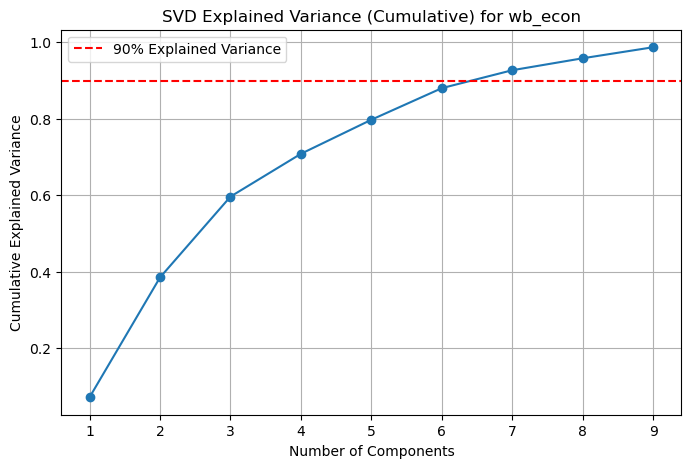

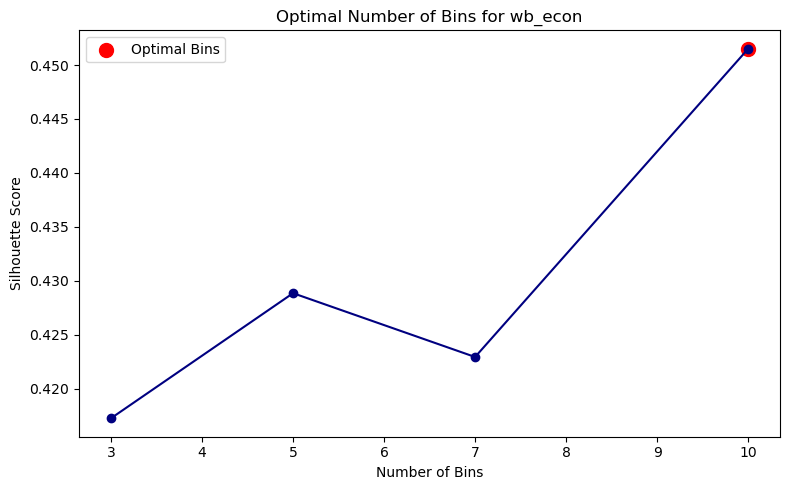

Selected 10 features for wb_econ: ['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]', 'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]', 'Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]', 'GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]', 'Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]', 'GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]', 'Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]', 'GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]', 'Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]']


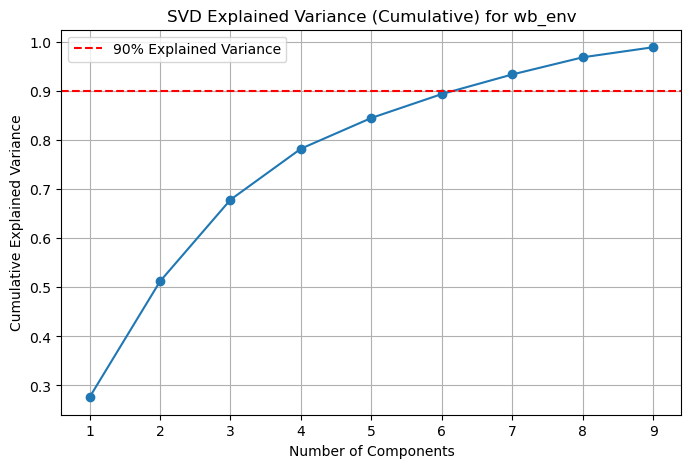

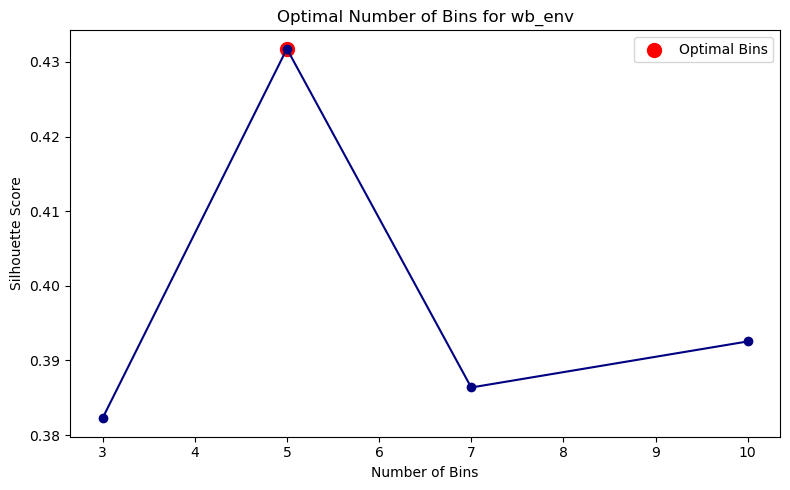

Selected 10 features for wb_env: ['Urban population growth (annual %) [SP.URB.GROW]', 'Methane (CH4) emissions from Fugitive Emissions (Energy) (Mt CO2e) [EN.GHG.CH4.FE.MT.CE.AR5]', 'Rural population (% of total population) [SP.RUR.TOTL.ZS]', 'Crop production index (2014-2016 = 100) [AG.PRD.CROP.XD]', 'Rural population [SP.RUR.TOTL]', 'Population density (people per sq. km of land area) [EN.POP.DNST]', 'Permanent cropland (% of land area) [AG.LND.CROP.ZS]', 'Nitrous oxide (N2O) emissions from Building (Energy) (Mt CO2e) [EN.GHG.N2O.BU.MT.CE.AR5]', 'Nitrous oxide (N2O) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.N2O.ZG.AR5]', 'Methane (CH4) emissions from Building (Energy) (Mt CO2e) [EN.GHG.CH4.BU.MT.CE.AR5]']


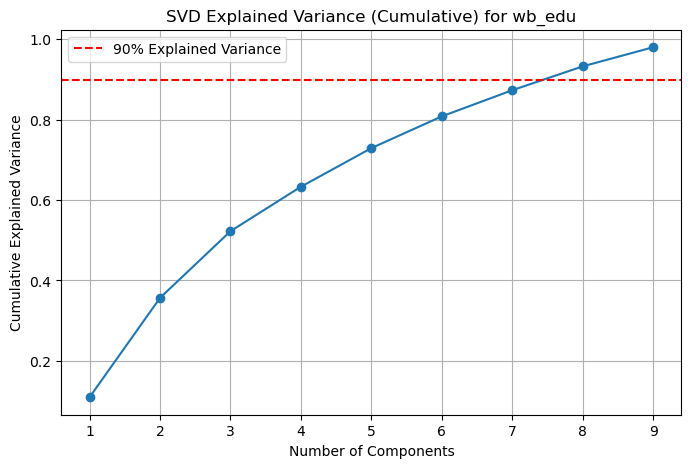

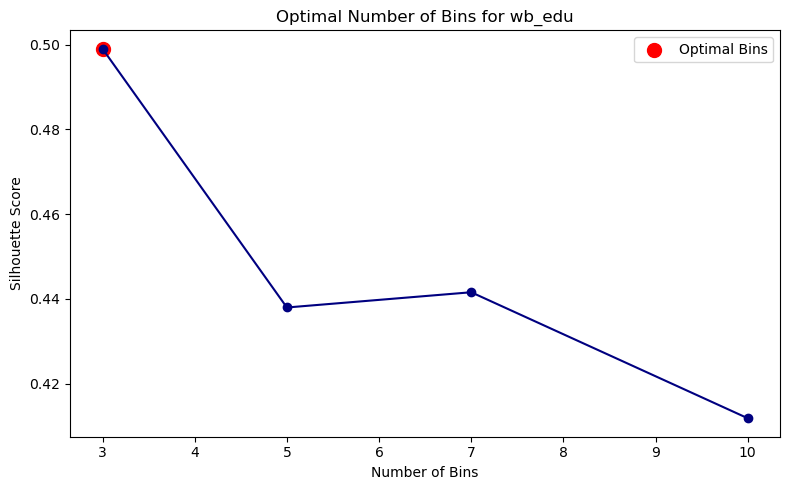

Selected 10 features for wb_edu: ['Primary education, pupils [SE.PRM.ENRL]', 'School enrollment, primary (% gross) [SE.PRM.ENRR]', 'Compulsory education, duration (years) [SE.COM.DURS]', 'Preprimary education, duration (years) [SE.PRE.DURS]', 'Secondary education, duration (years) [SE.SEC.DURS]', 'Primary education, teachers (% female) [SE.PRM.TCHR.FE.ZS]', 'Government expenditure on education, total (% of GDP) [SE.XPD.TOTL.GD.ZS]', 'Children out of school, primary [SE.PRM.UNER]', 'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]', 'School enrollment, secondary (% gross) [SE.SEC.ENRR]']


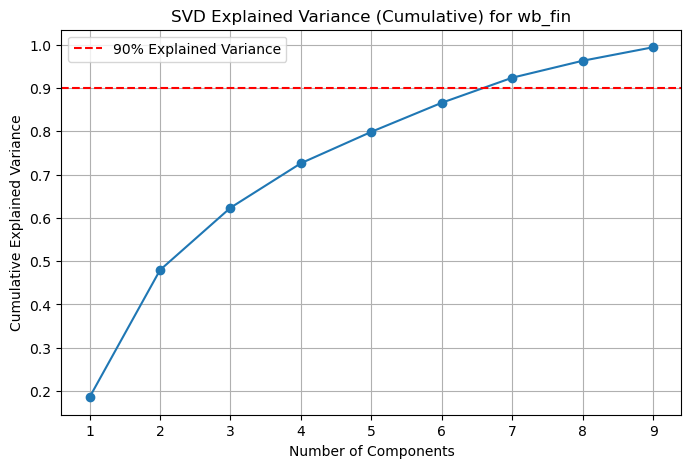

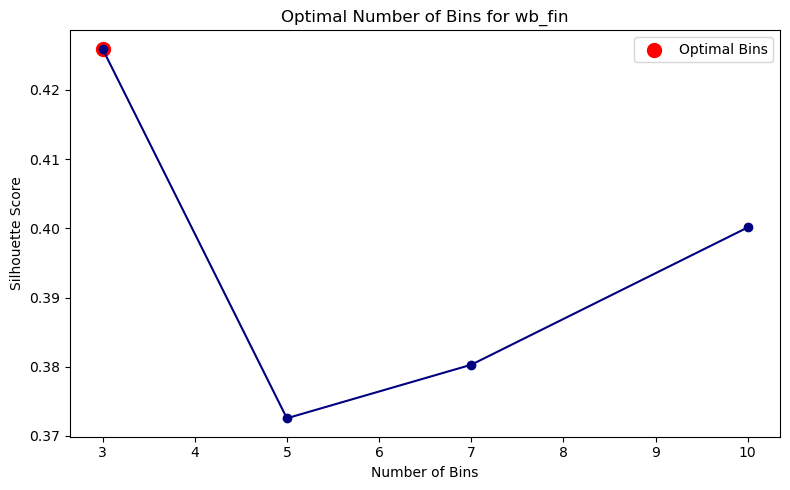

Selected 10 features for wb_fin: ['Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]', 'Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]', 'Claims on central government, etc. (% GDP) [FS.AST.CGOV.GD.ZS]', 'Domestic credit to private sector (% of GDP) [FS.AST.PRVT.GD.ZS]', 'Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]', 'Consumer price index (2010 = 100) [FP.CPI.TOTL]', 'DEC alternative conversion factor (LCU per US$) [PA.NUS.ATLS]', 'GDP deflator (base year varies by country) [NY.GDP.DEFL.ZS]', 'Official exchange rate (LCU per US$, period average) [PA.NUS.FCRF]', 'Bank liquid reserves to bank assets ratio (%) [FD.RES.LIQU.AS.ZS]']


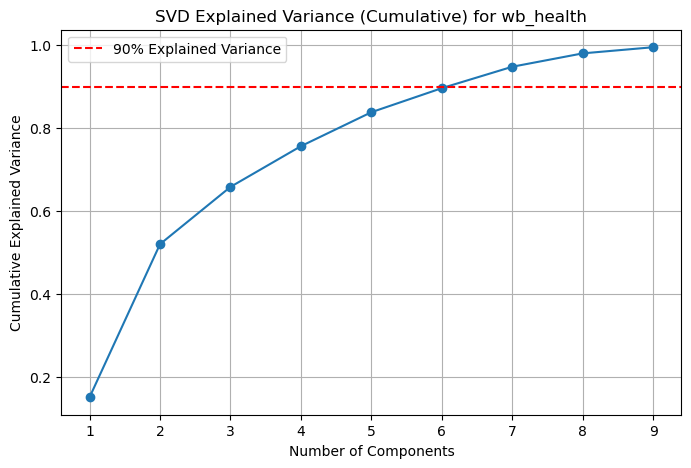

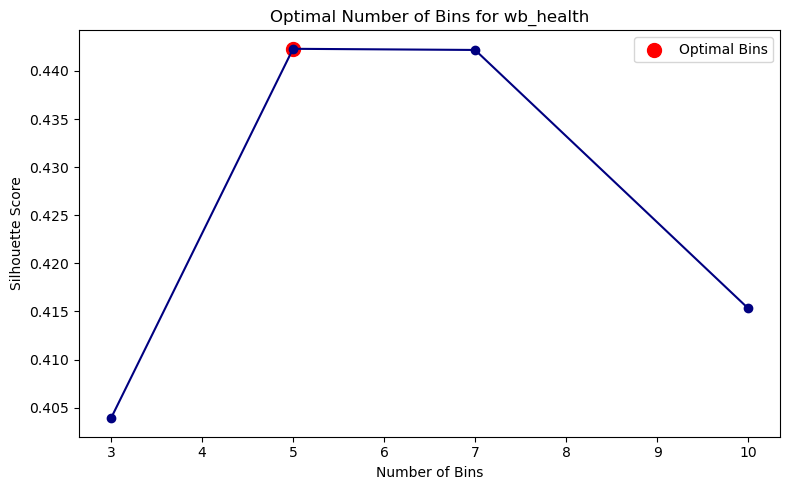

Selected 10 features for wb_health: ['Immunization, DPT (% of children ages 12-23 months) [SH.IMM.IDPT]', 'Immunization, measles (% of children ages 12-23 months) [SH.IMM.MEAS]', 'Tuberculosis treatment success rate (% of new cases) [SH.TBS.CURE.ZS]', 'Sex ratio at birth (male births per female births) [SP.POP.BRTH.MF]', 'Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]', 'Population ages 25-29, male (% of male population) [SP.POP.2529.MA.5Y]', 'Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS]', 'Out-of-pocket expenditure per capita (current US$) [SH.XPD.OOPC.PC.CD]', 'Out-of-pocket expenditure per capita, PPP (current international $) [SH.XPD.OOPC.PP.CD]', 'People using at least basic drinking water services, urban (% of urban population) [SH.H2O.BASW.UR.ZS]']


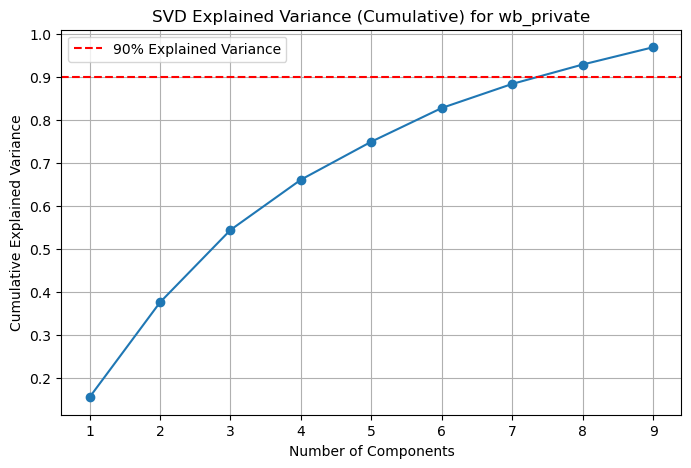

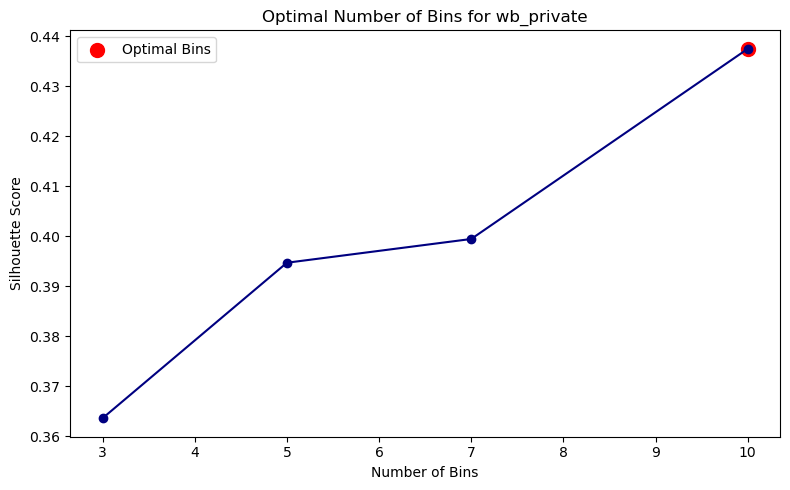

Selected 10 features for wb_private: ['Merchandise imports from high-income economies (% of total merchandise imports) [TM.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies in East Asia & Pacific (% of total merchandise imports) [TM.VAL.MRCH.R1.ZS]', 'Merchandise exports to low- and middle-income economies in East Asia & Pacific (% of total merchandise exports) [TX.VAL.MRCH.R1.ZS]', 'Merchandise exports (current US$) [TX.VAL.MRCH.CD.WT]', 'Merchandise imports (current US$) [TM.VAL.MRCH.CD.WT]', 'Merchandise exports to high-income economies (% of total merchandise exports) [TX.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies outside region (% of total merchandise imports) [TM.VAL.MRCH.OR.ZS]', 'Merchandise imports from low- and middle-income economies in South Asia (% of total merchandise imports) [TM.VAL.MRCH.R5.ZS]', 'Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports) [TX.VAL.MR

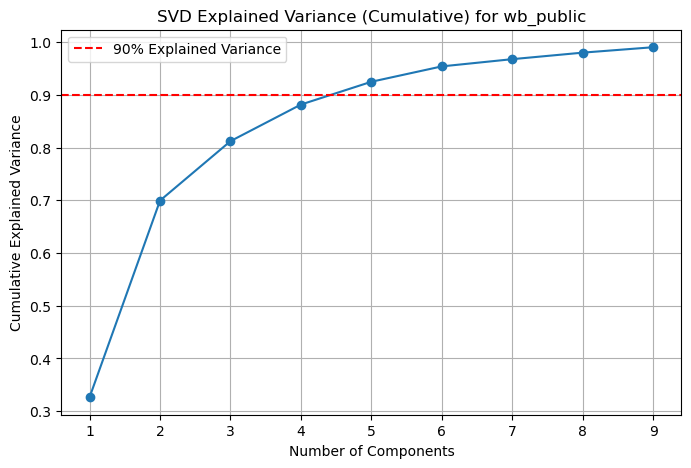

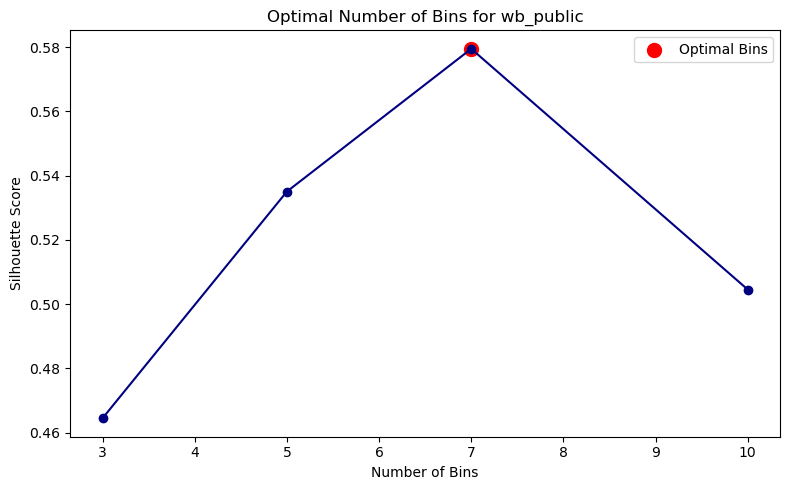

Selected 10 features for wb_public: ['Voice and Accountability: Number of Sources [VA.NO.SRC]', 'Statistical performance indicators (SPI): Pillar 3 data products score  (scale 0-100) [IQ.SPI.PIL3]', 'Regulatory Quality: Estimate [RQ.EST]', 'Political Stability and Absence of Violence/Terrorism: Estimate [PV.EST]', 'Voice and Accountability: Estimate [VA.EST]', 'Statistical performance indicators (SPI): Pillar 4 data sources score (scale 0-100) [IQ.SPI.PIL4]', 'Statistical performance indicators (SPI): Pillar 2 data services score (scale 0-100) [IQ.SPI.PIL2]', 'Statistical performance indicators (SPI): Overall score (scale 0-100) [IQ.SPI.OVRL]', 'Rule of Law: Estimate [RL.EST]', 'Control of Corruption: Estimate [CC.EST]']


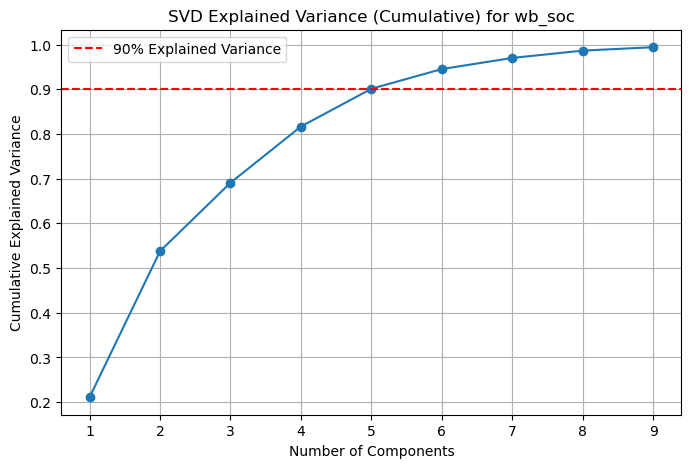

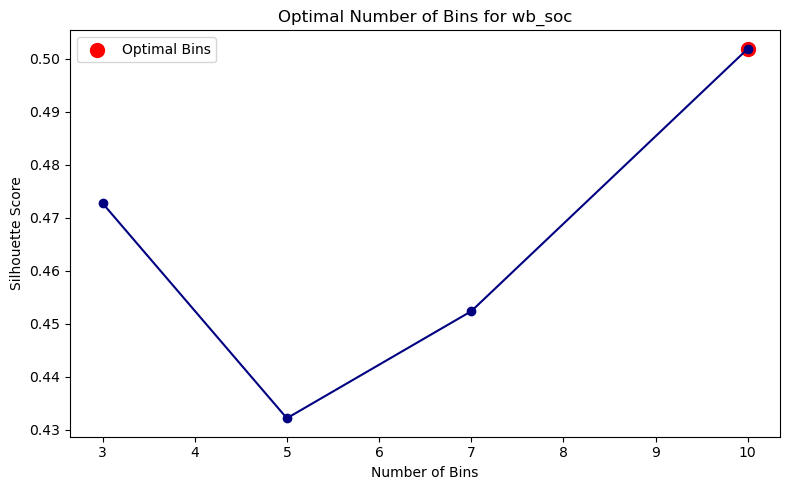

Selected 10 features for wb_soc: ['Net migration [SM.POP.NETM]', 'Refugees under the mandate of the UNHCR by country or territory of origin [SM.POP.RHCR.EO]', 'Employment to population ratio, 15+, total (%) (modeled ILO estimate) [SL.EMP.TOTL.SP.ZS]', 'Labor force, total [SL.TLF.TOTL.IN]', 'Labor force, female (% of total labor force) [SL.TLF.TOTL.FE.ZS]', 'Self-employed, female (% of female employment) (modeled ILO estimate) [SL.EMP.SELF.FE.ZS]', 'Share of youth not in education, employment or training, male (% of male youth population)  (modeled ILO estimate) [SL.UEM.NEET.MA.ME.ZS]', 'Unemployment, female (% of female labor force) (modeled ILO estimate) [SL.UEM.TOTL.FE.ZS]', 'Unemployment, male (% of male labor force) (modeled ILO estimate) [SL.UEM.TOTL.MA.ZS]', 'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate) [SL.TLF.ACTI.ZS]']



=== Analyzing with Hierarchical ===


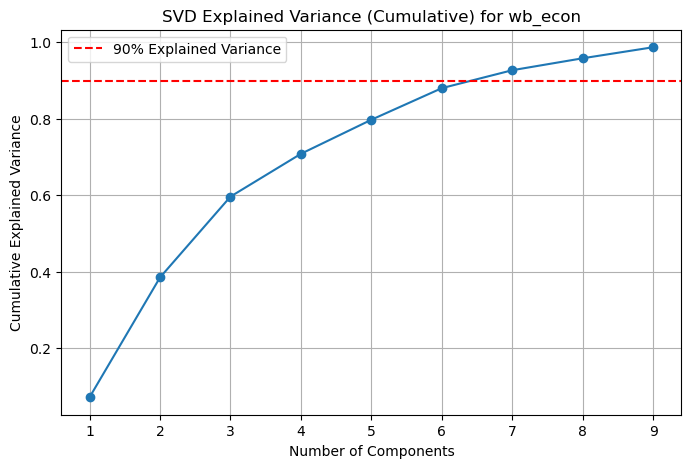

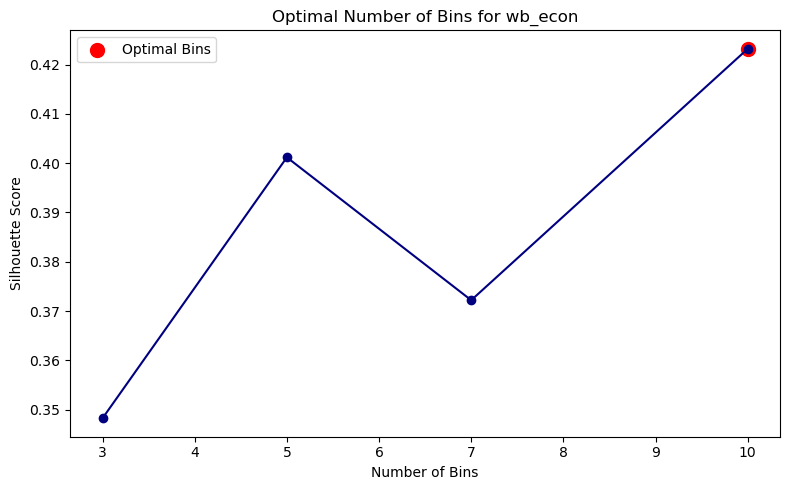

Selected 10 features for wb_econ: ['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]', 'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]', 'Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]', 'GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]', 'Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]', 'GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]', 'Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]', 'GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]', 'Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]']


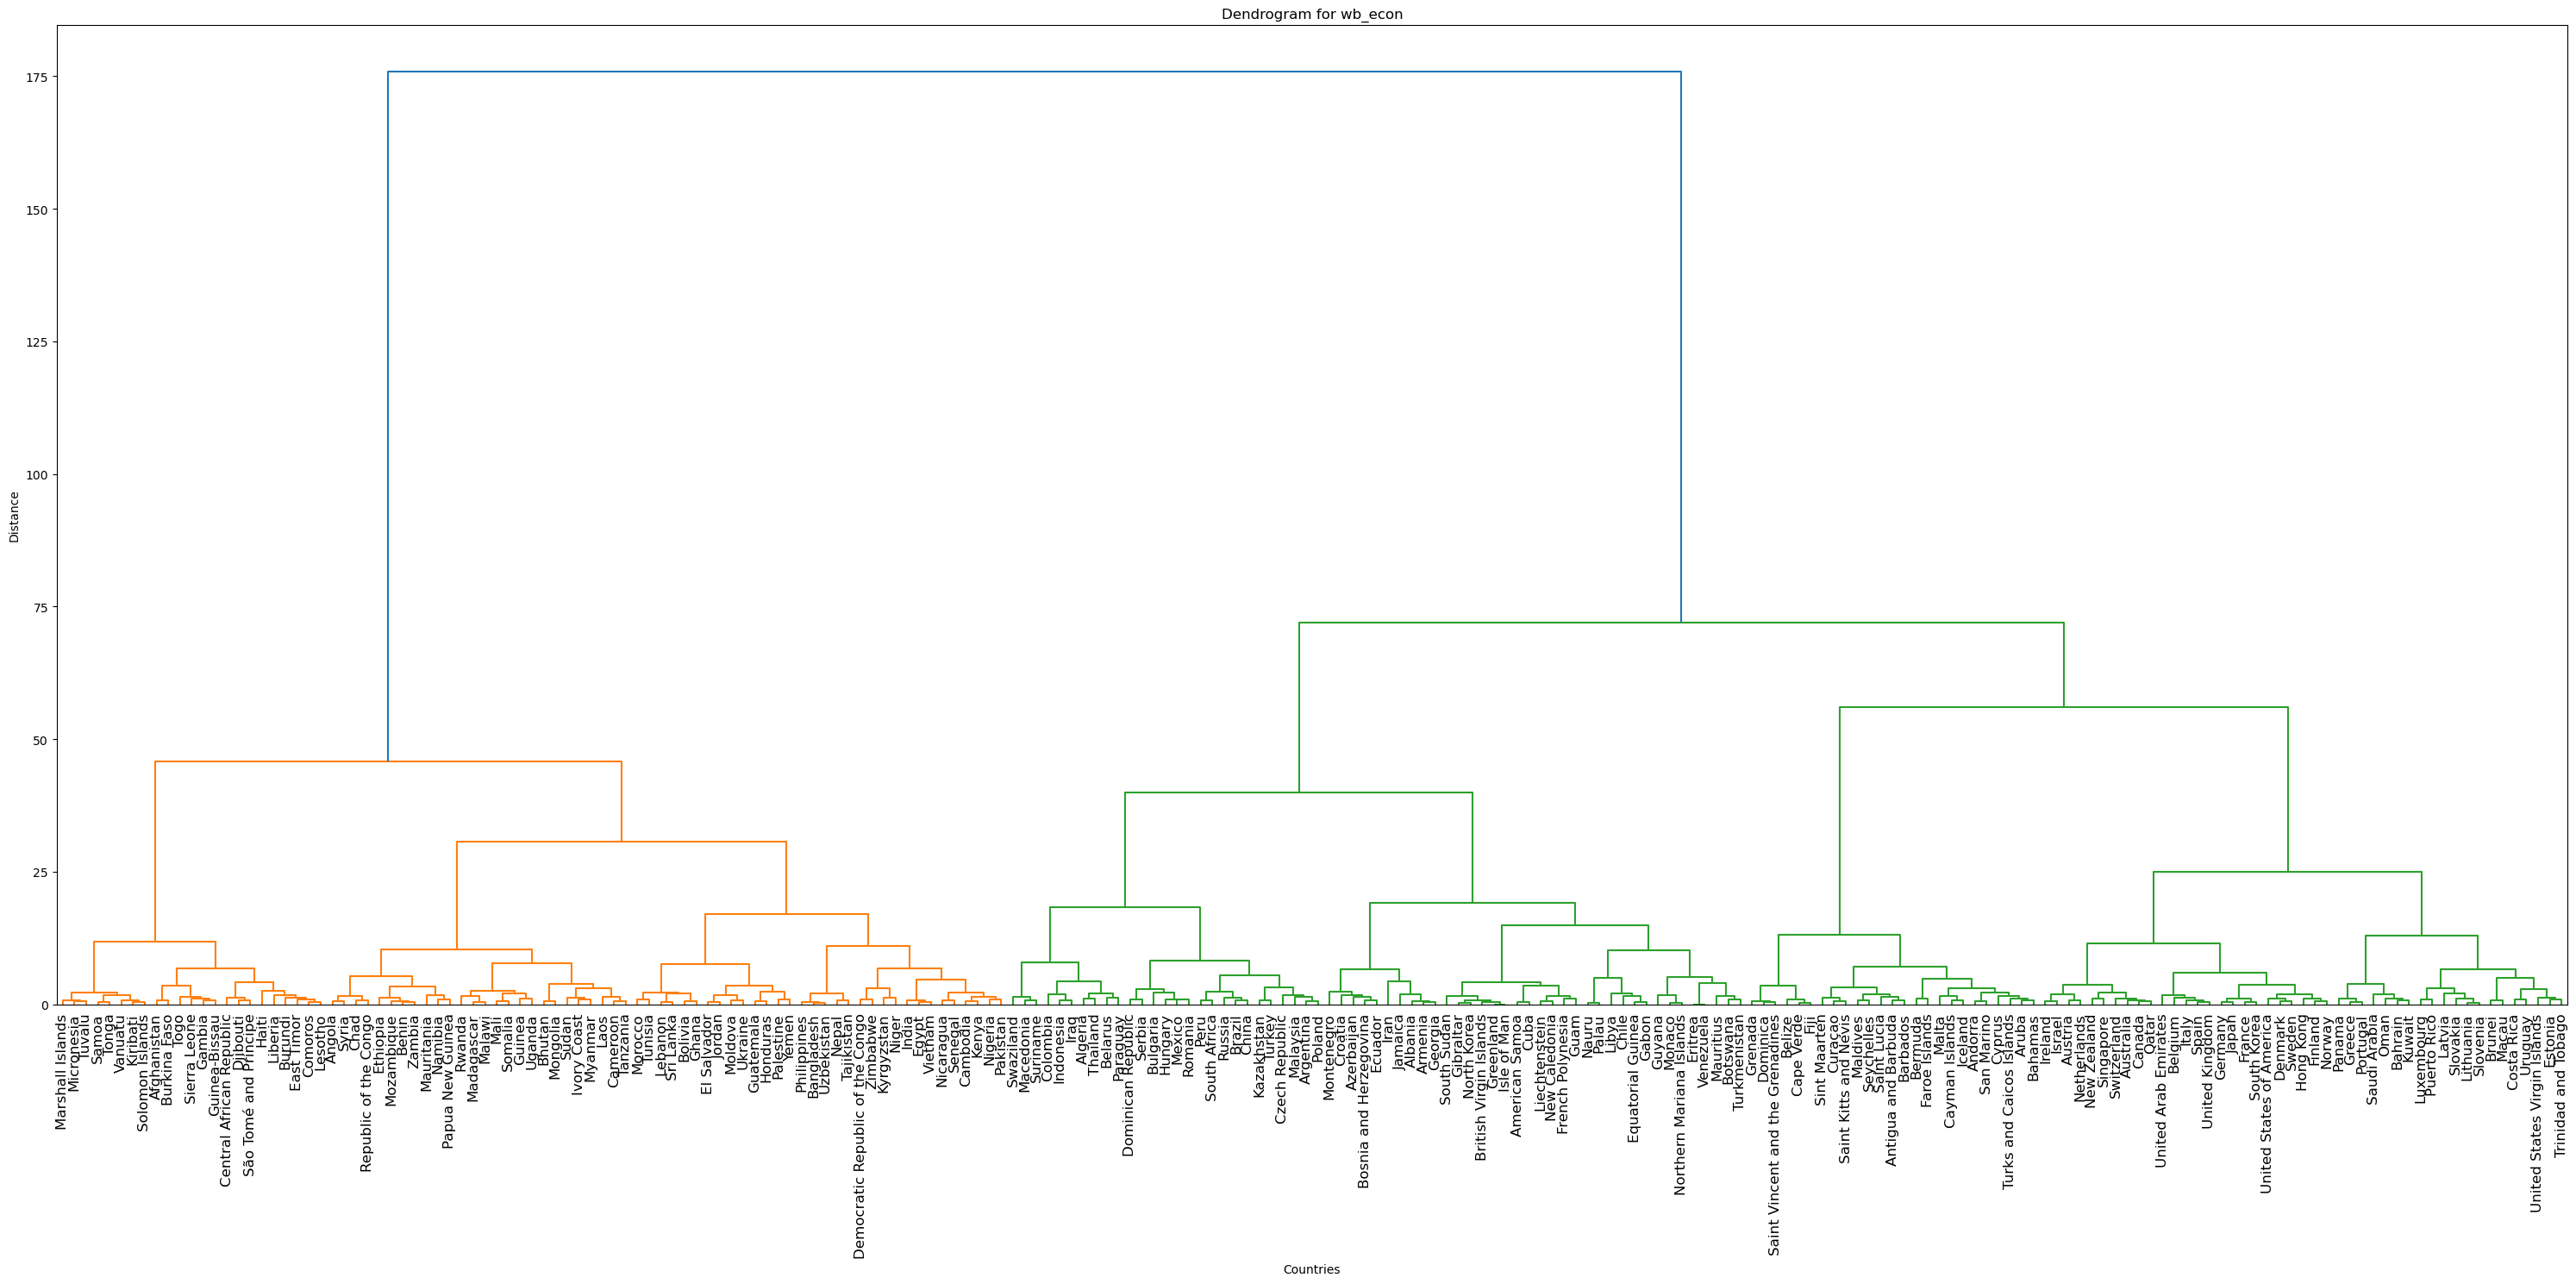

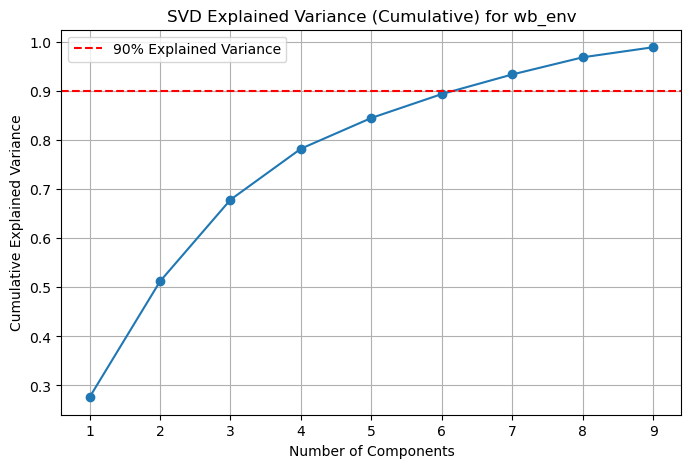

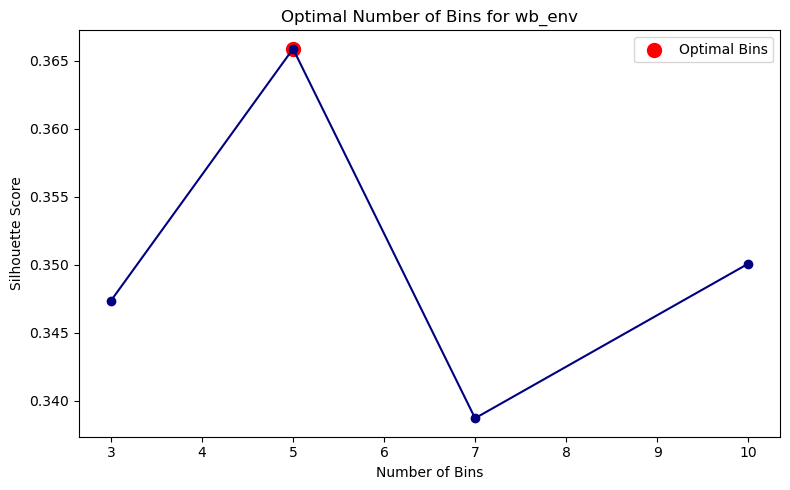

Selected 10 features for wb_env: ['Urban population growth (annual %) [SP.URB.GROW]', 'Methane (CH4) emissions from Fugitive Emissions (Energy) (Mt CO2e) [EN.GHG.CH4.FE.MT.CE.AR5]', 'Rural population (% of total population) [SP.RUR.TOTL.ZS]', 'Crop production index (2014-2016 = 100) [AG.PRD.CROP.XD]', 'Rural population [SP.RUR.TOTL]', 'Population density (people per sq. km of land area) [EN.POP.DNST]', 'Permanent cropland (% of land area) [AG.LND.CROP.ZS]', 'Nitrous oxide (N2O) emissions from Building (Energy) (Mt CO2e) [EN.GHG.N2O.BU.MT.CE.AR5]', 'Nitrous oxide (N2O) emissions (total) excluding LULUCF (% change from 1990) [EN.GHG.N2O.ZG.AR5]', 'Methane (CH4) emissions from Building (Energy) (Mt CO2e) [EN.GHG.CH4.BU.MT.CE.AR5]']


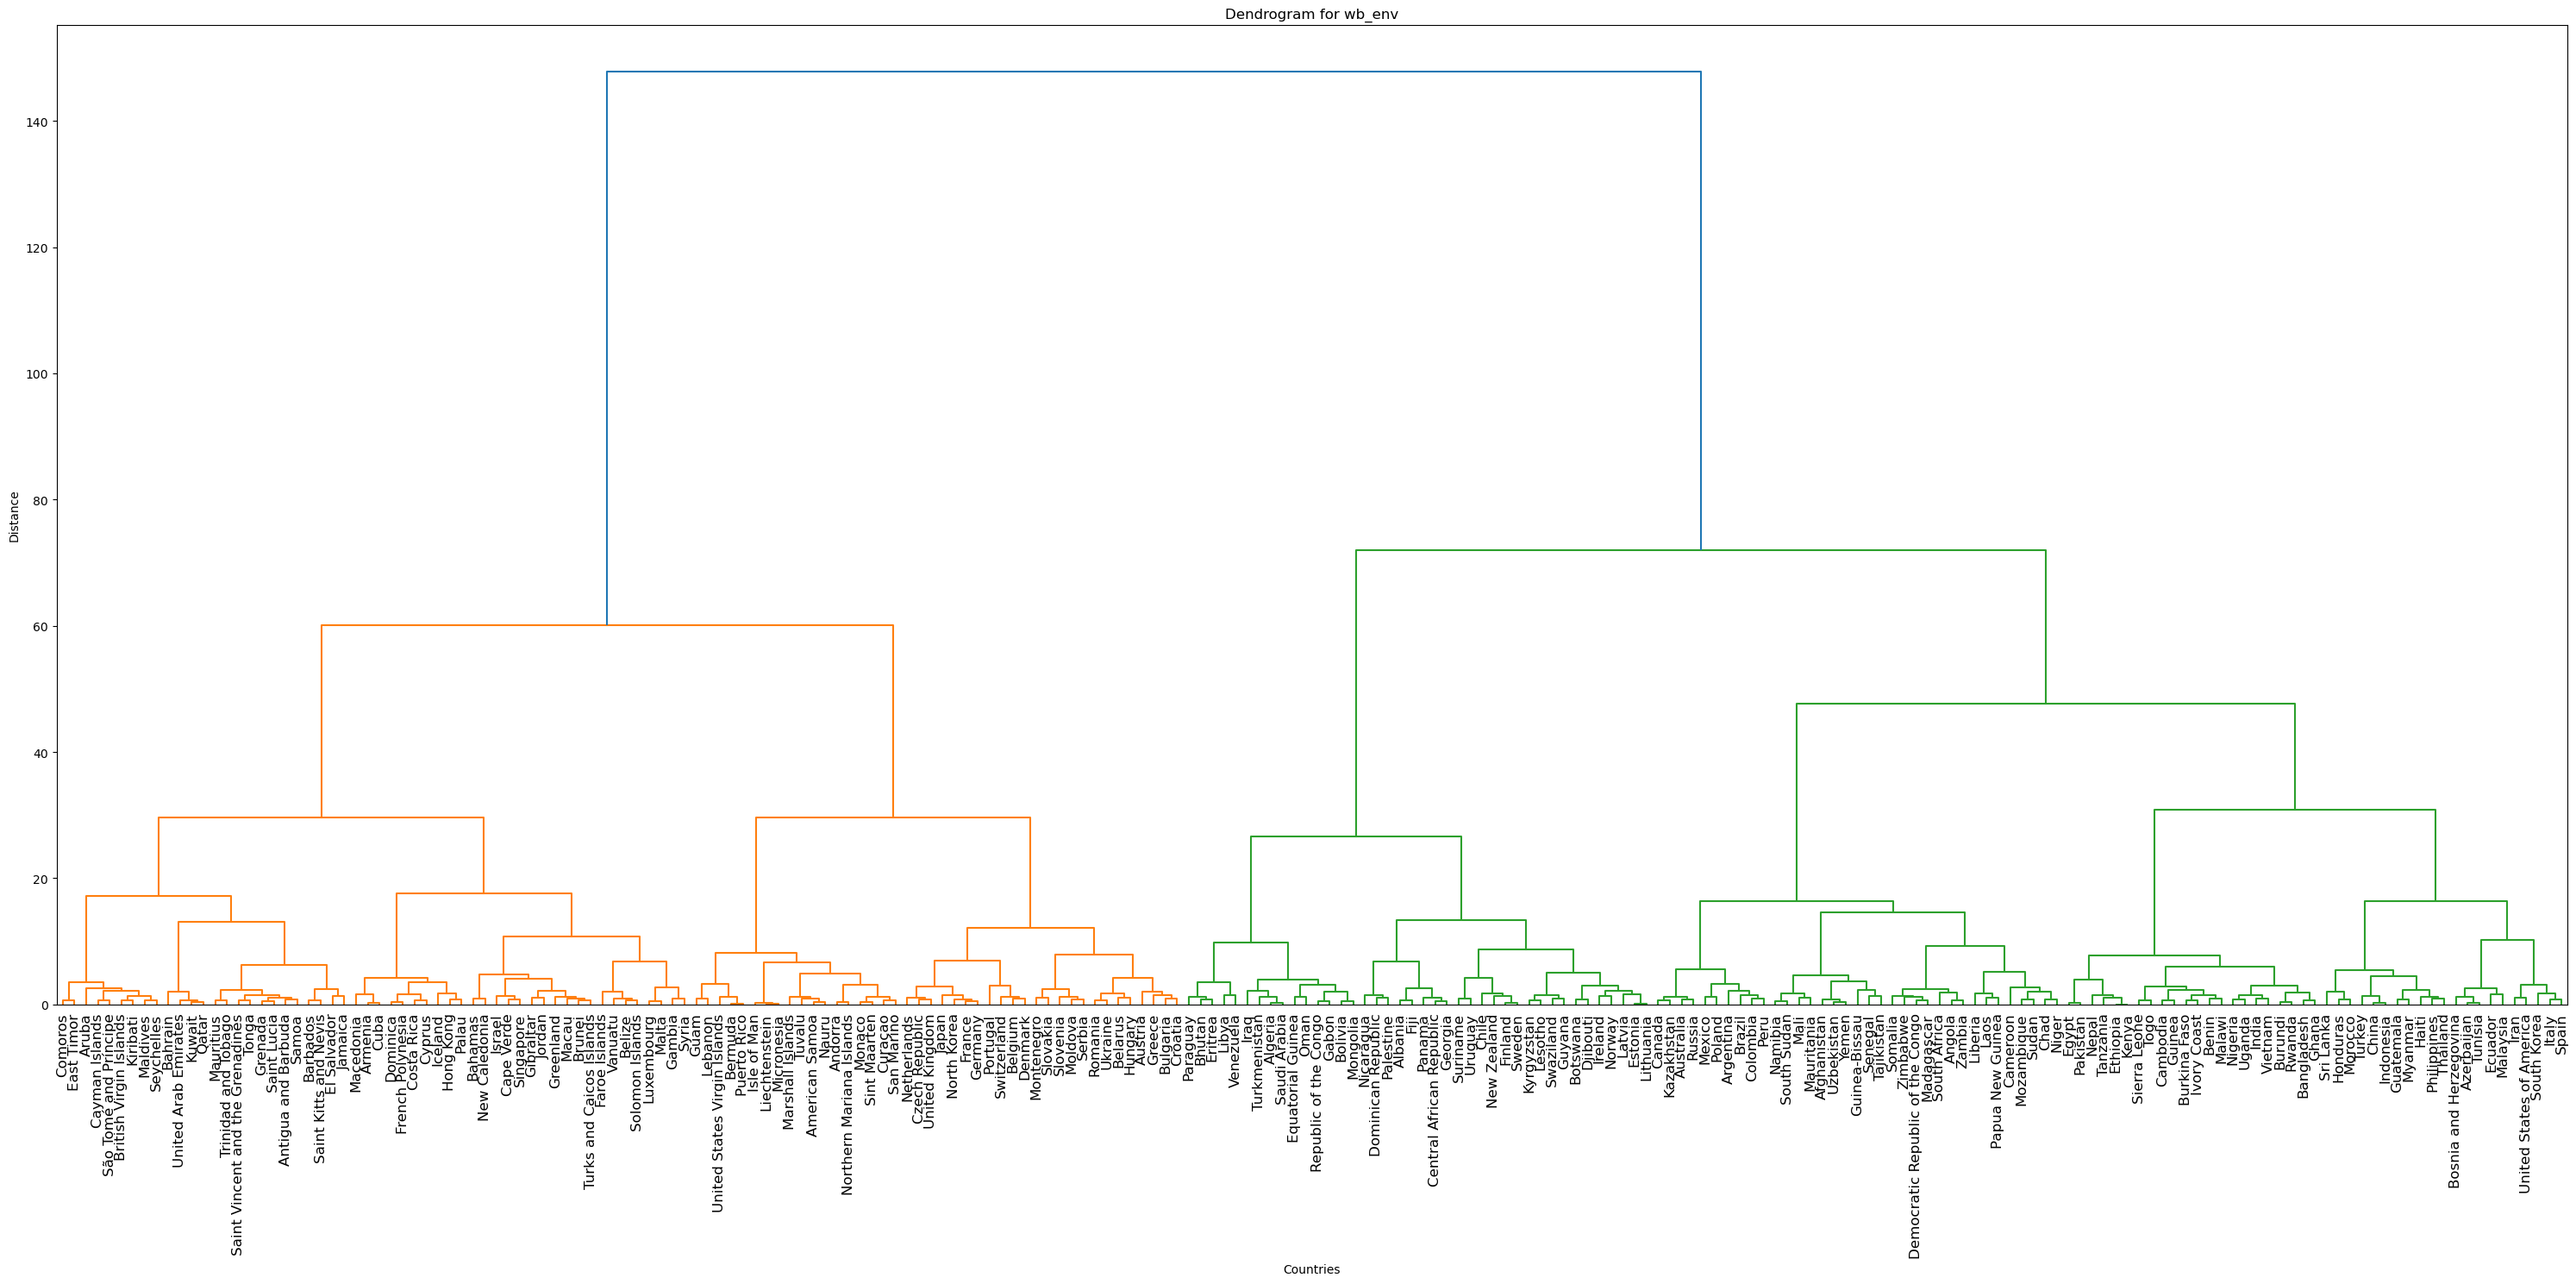

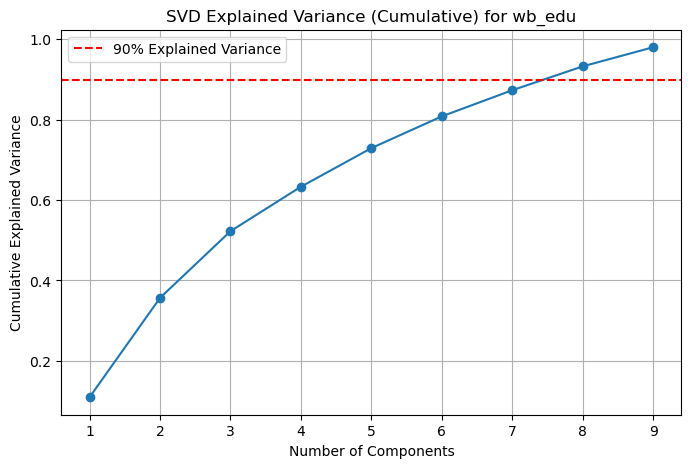

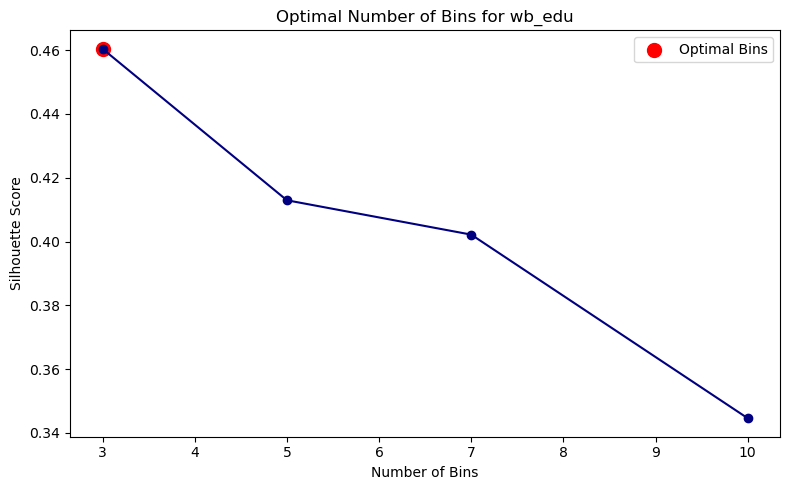

Selected 10 features for wb_edu: ['Primary education, pupils [SE.PRM.ENRL]', 'School enrollment, primary (% gross) [SE.PRM.ENRR]', 'Compulsory education, duration (years) [SE.COM.DURS]', 'Preprimary education, duration (years) [SE.PRE.DURS]', 'Secondary education, duration (years) [SE.SEC.DURS]', 'Primary education, teachers (% female) [SE.PRM.TCHR.FE.ZS]', 'Government expenditure on education, total (% of GDP) [SE.XPD.TOTL.GD.ZS]', 'Children out of school, primary [SE.PRM.UNER]', 'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]', 'School enrollment, secondary (% gross) [SE.SEC.ENRR]']


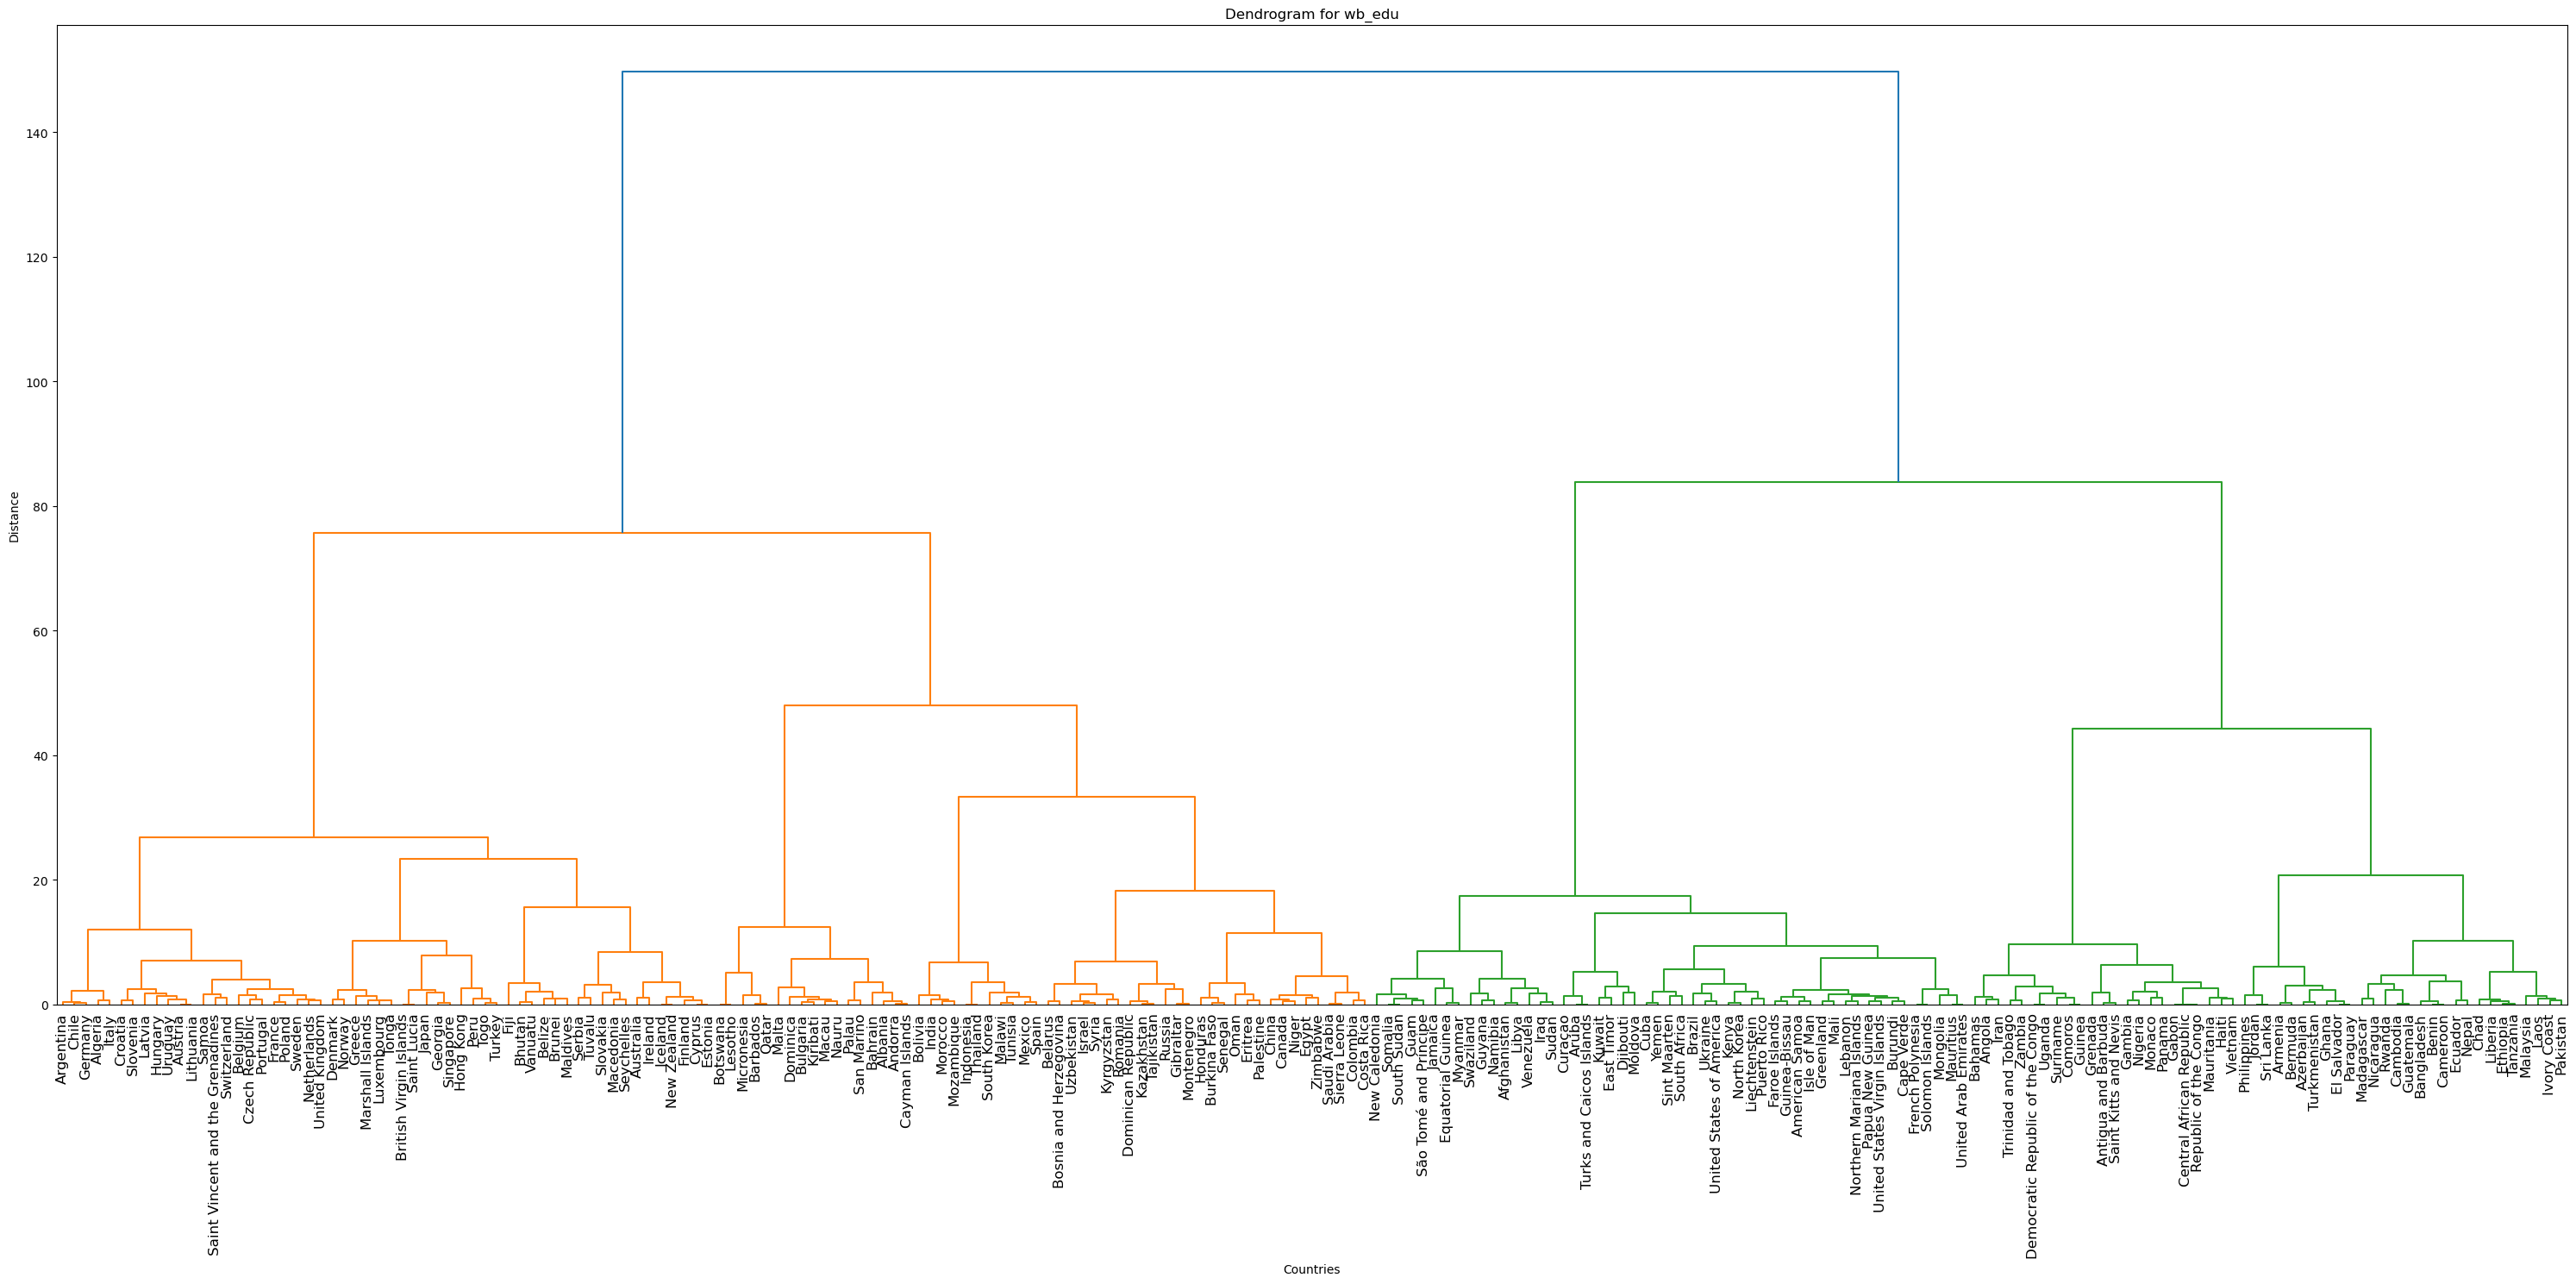

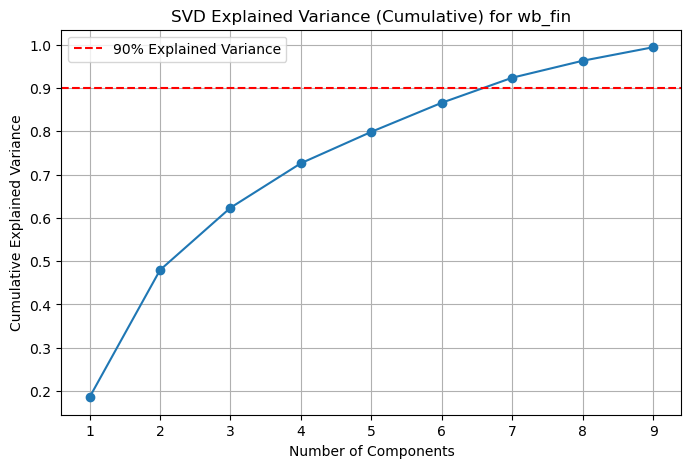

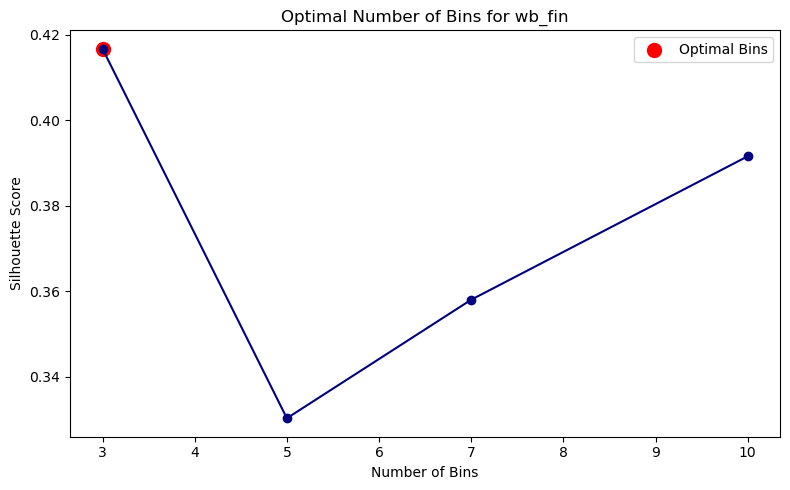

Selected 10 features for wb_fin: ['Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]', 'Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]', 'Claims on central government, etc. (% GDP) [FS.AST.CGOV.GD.ZS]', 'Domestic credit to private sector (% of GDP) [FS.AST.PRVT.GD.ZS]', 'Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]', 'Consumer price index (2010 = 100) [FP.CPI.TOTL]', 'DEC alternative conversion factor (LCU per US$) [PA.NUS.ATLS]', 'GDP deflator (base year varies by country) [NY.GDP.DEFL.ZS]', 'Official exchange rate (LCU per US$, period average) [PA.NUS.FCRF]', 'Bank liquid reserves to bank assets ratio (%) [FD.RES.LIQU.AS.ZS]']


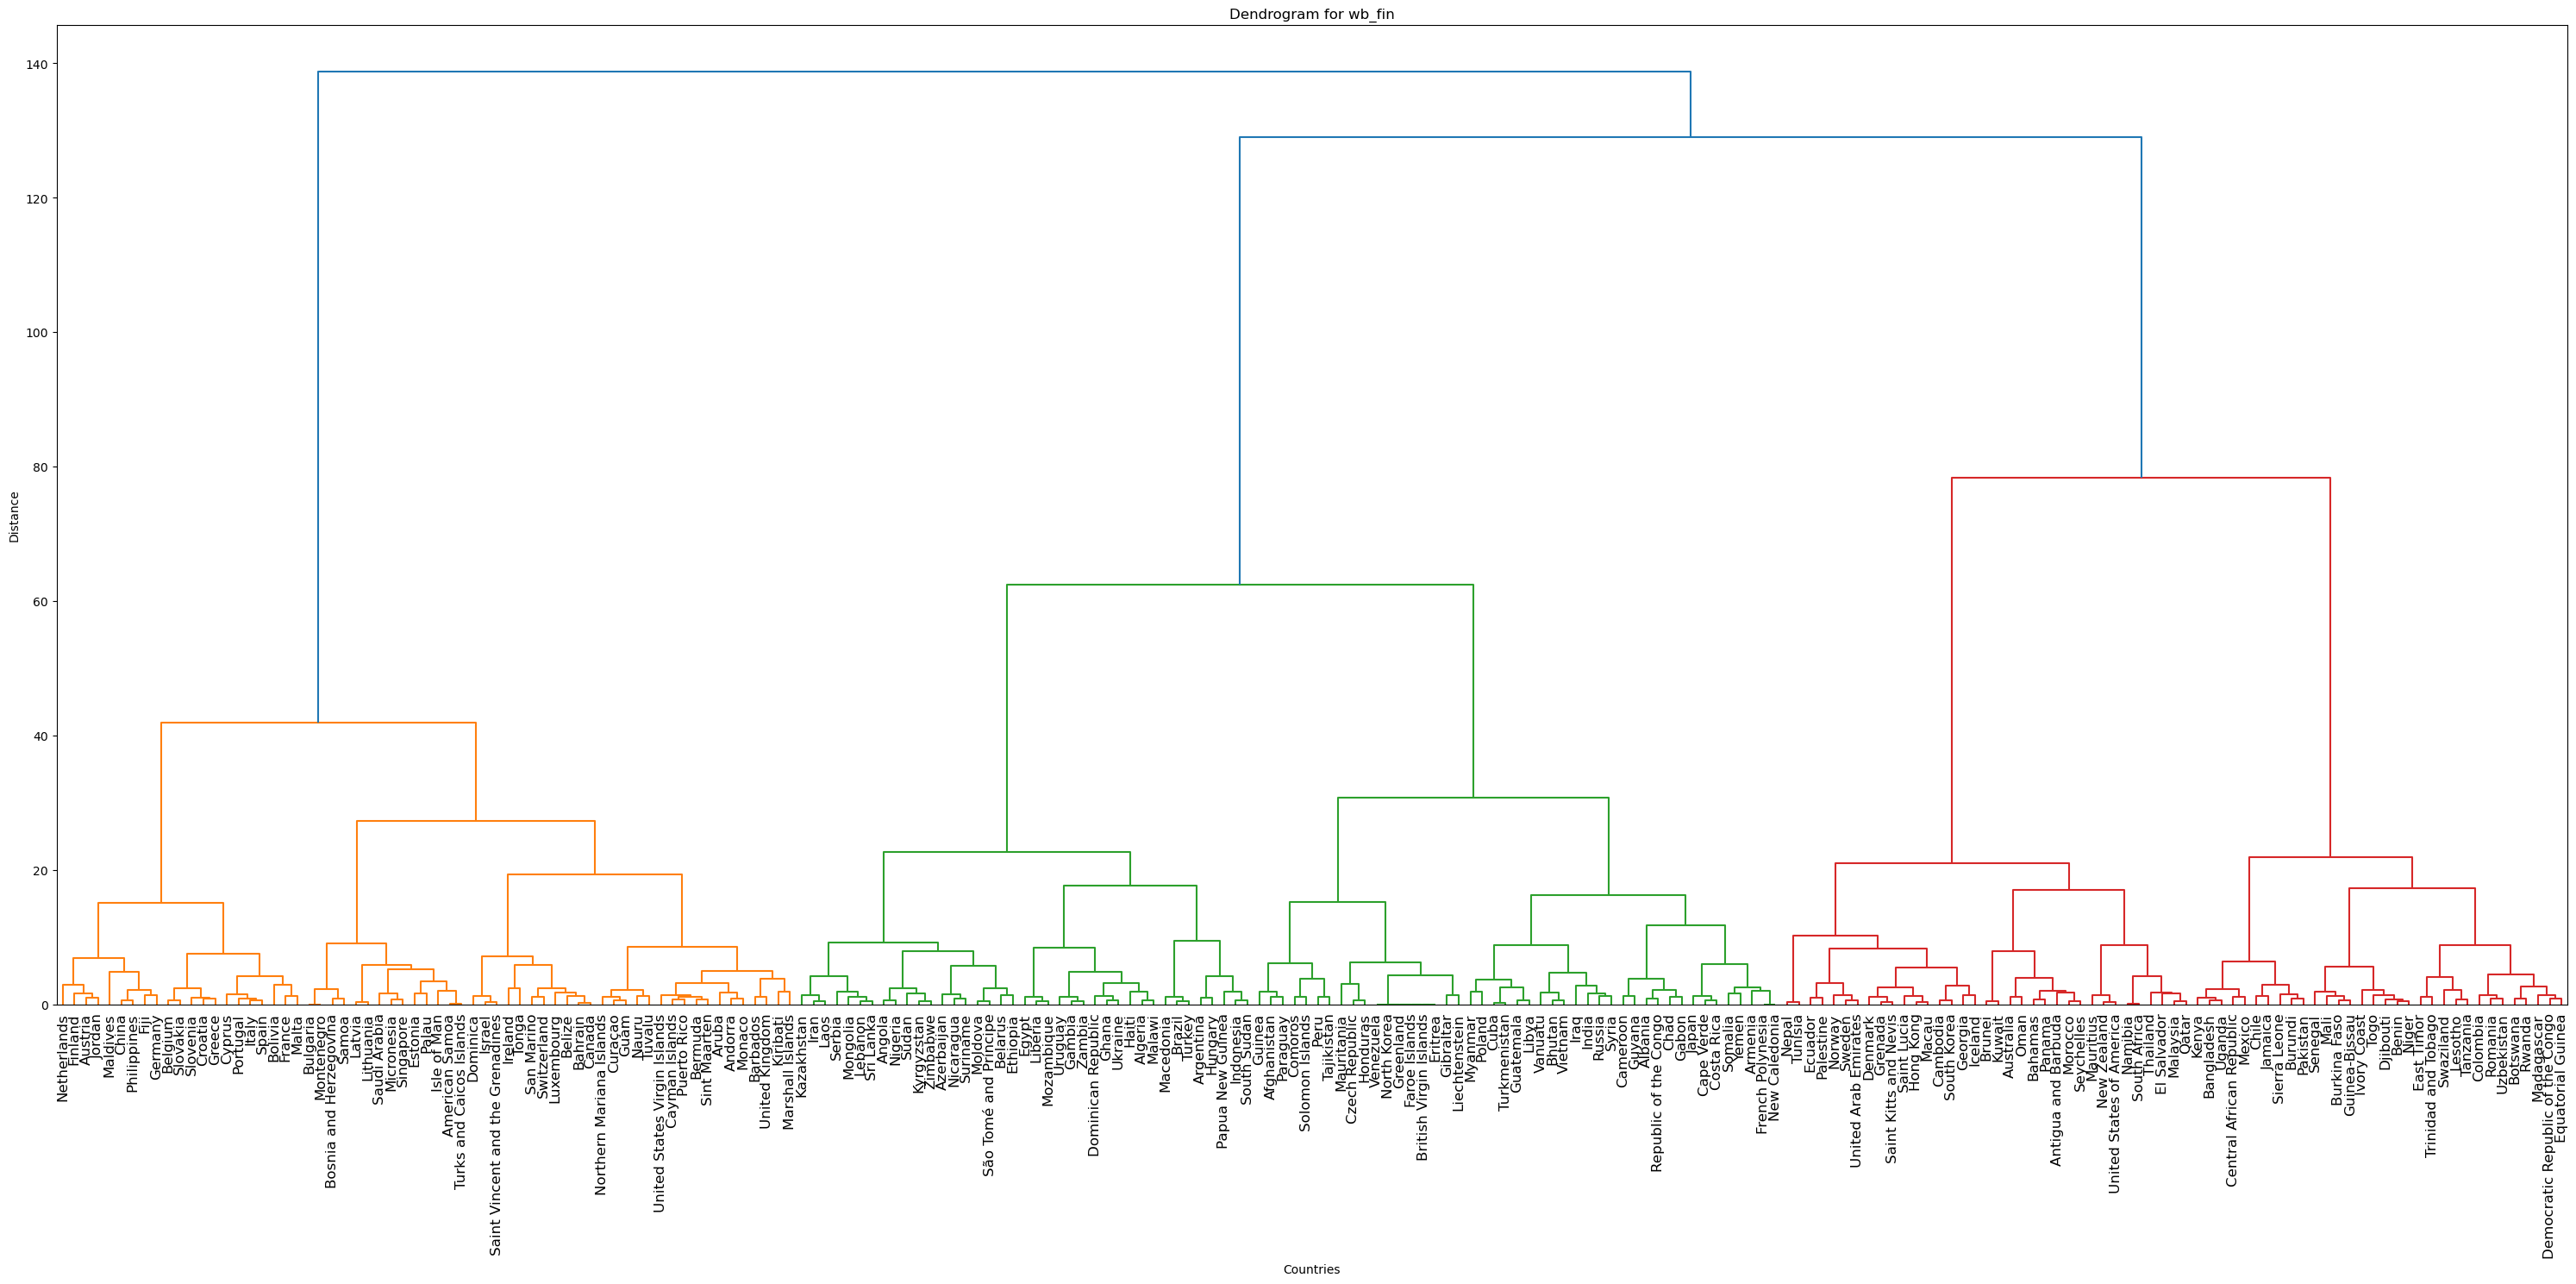

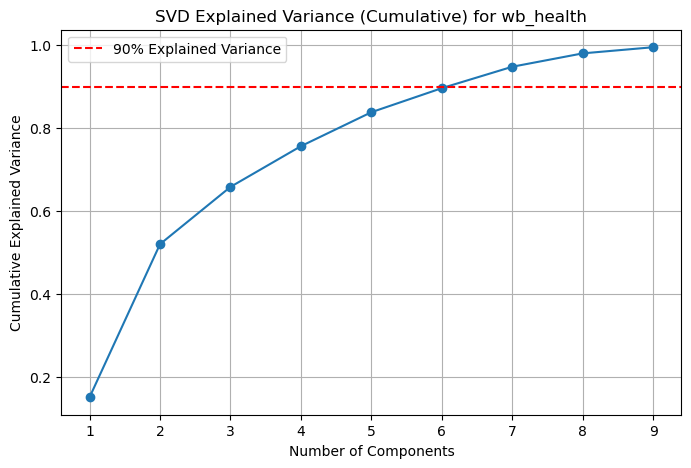

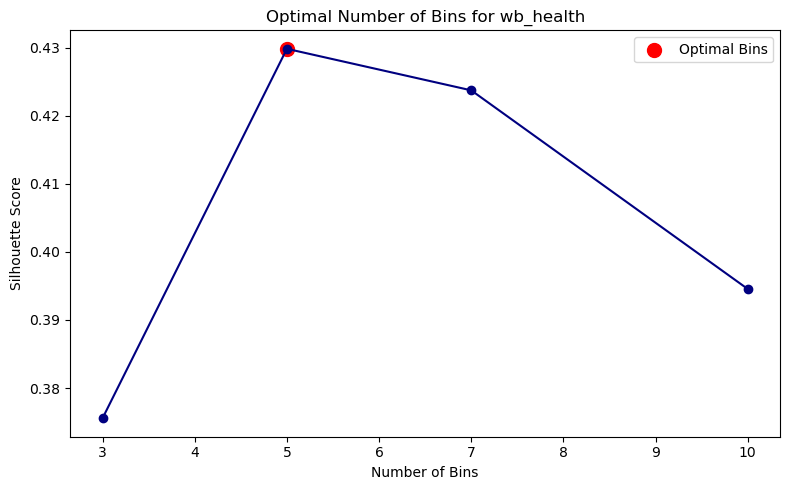

Selected 10 features for wb_health: ['Immunization, DPT (% of children ages 12-23 months) [SH.IMM.IDPT]', 'Immunization, measles (% of children ages 12-23 months) [SH.IMM.MEAS]', 'Tuberculosis treatment success rate (% of new cases) [SH.TBS.CURE.ZS]', 'Sex ratio at birth (male births per female births) [SP.POP.BRTH.MF]', 'Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]', 'Population ages 25-29, male (% of male population) [SP.POP.2529.MA.5Y]', 'Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS]', 'Out-of-pocket expenditure per capita (current US$) [SH.XPD.OOPC.PC.CD]', 'Out-of-pocket expenditure per capita, PPP (current international $) [SH.XPD.OOPC.PP.CD]', 'People using at least basic drinking water services, urban (% of urban population) [SH.H2O.BASW.UR.ZS]']


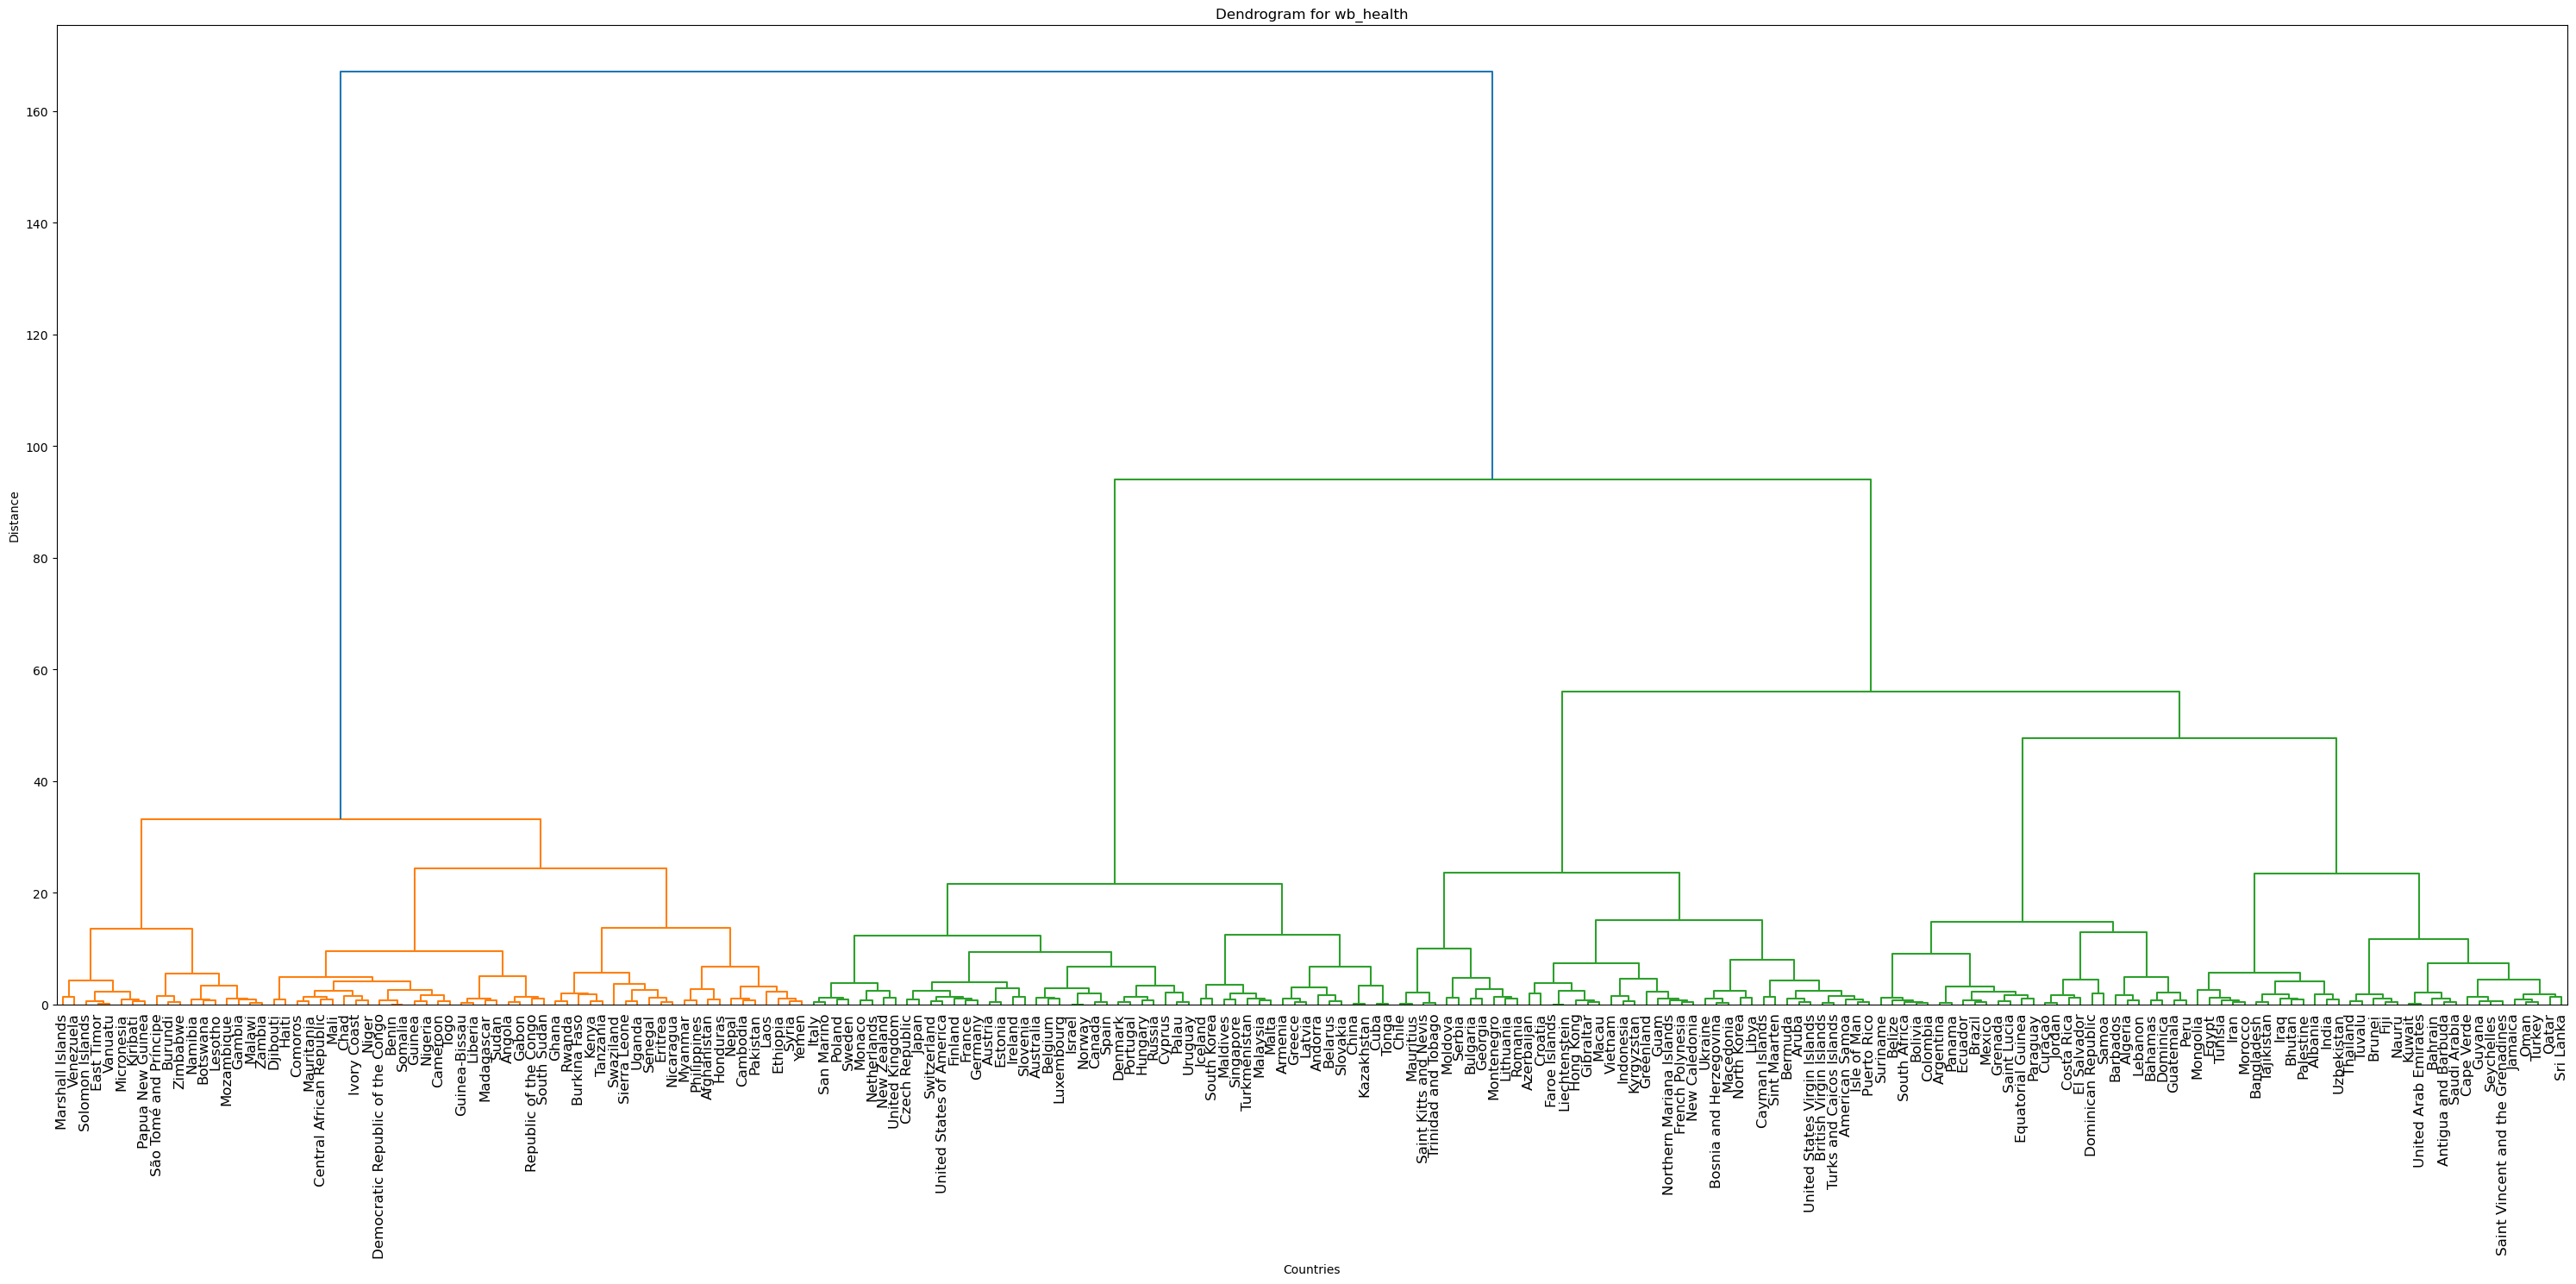

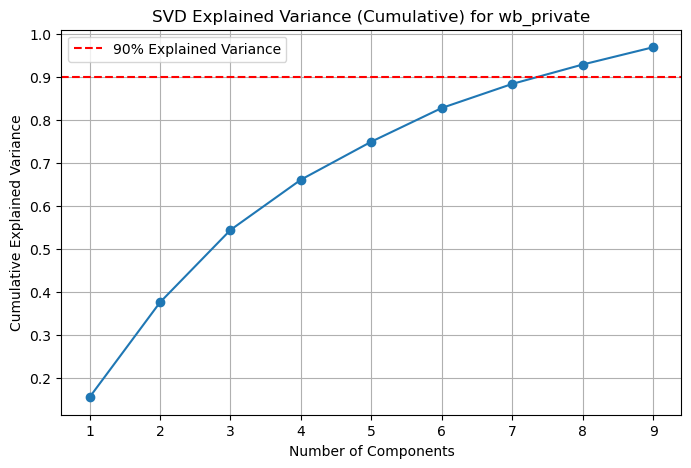

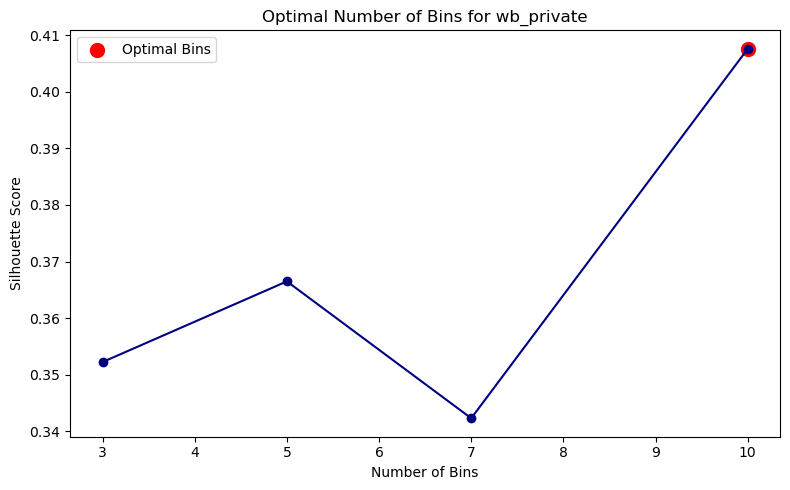

Selected 10 features for wb_private: ['Merchandise imports from high-income economies (% of total merchandise imports) [TM.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies in East Asia & Pacific (% of total merchandise imports) [TM.VAL.MRCH.R1.ZS]', 'Merchandise exports to low- and middle-income economies in East Asia & Pacific (% of total merchandise exports) [TX.VAL.MRCH.R1.ZS]', 'Merchandise exports (current US$) [TX.VAL.MRCH.CD.WT]', 'Merchandise imports (current US$) [TM.VAL.MRCH.CD.WT]', 'Merchandise exports to high-income economies (% of total merchandise exports) [TX.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies outside region (% of total merchandise imports) [TM.VAL.MRCH.OR.ZS]', 'Merchandise imports from low- and middle-income economies in South Asia (% of total merchandise imports) [TM.VAL.MRCH.R5.ZS]', 'Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports) [TX.VAL.MR

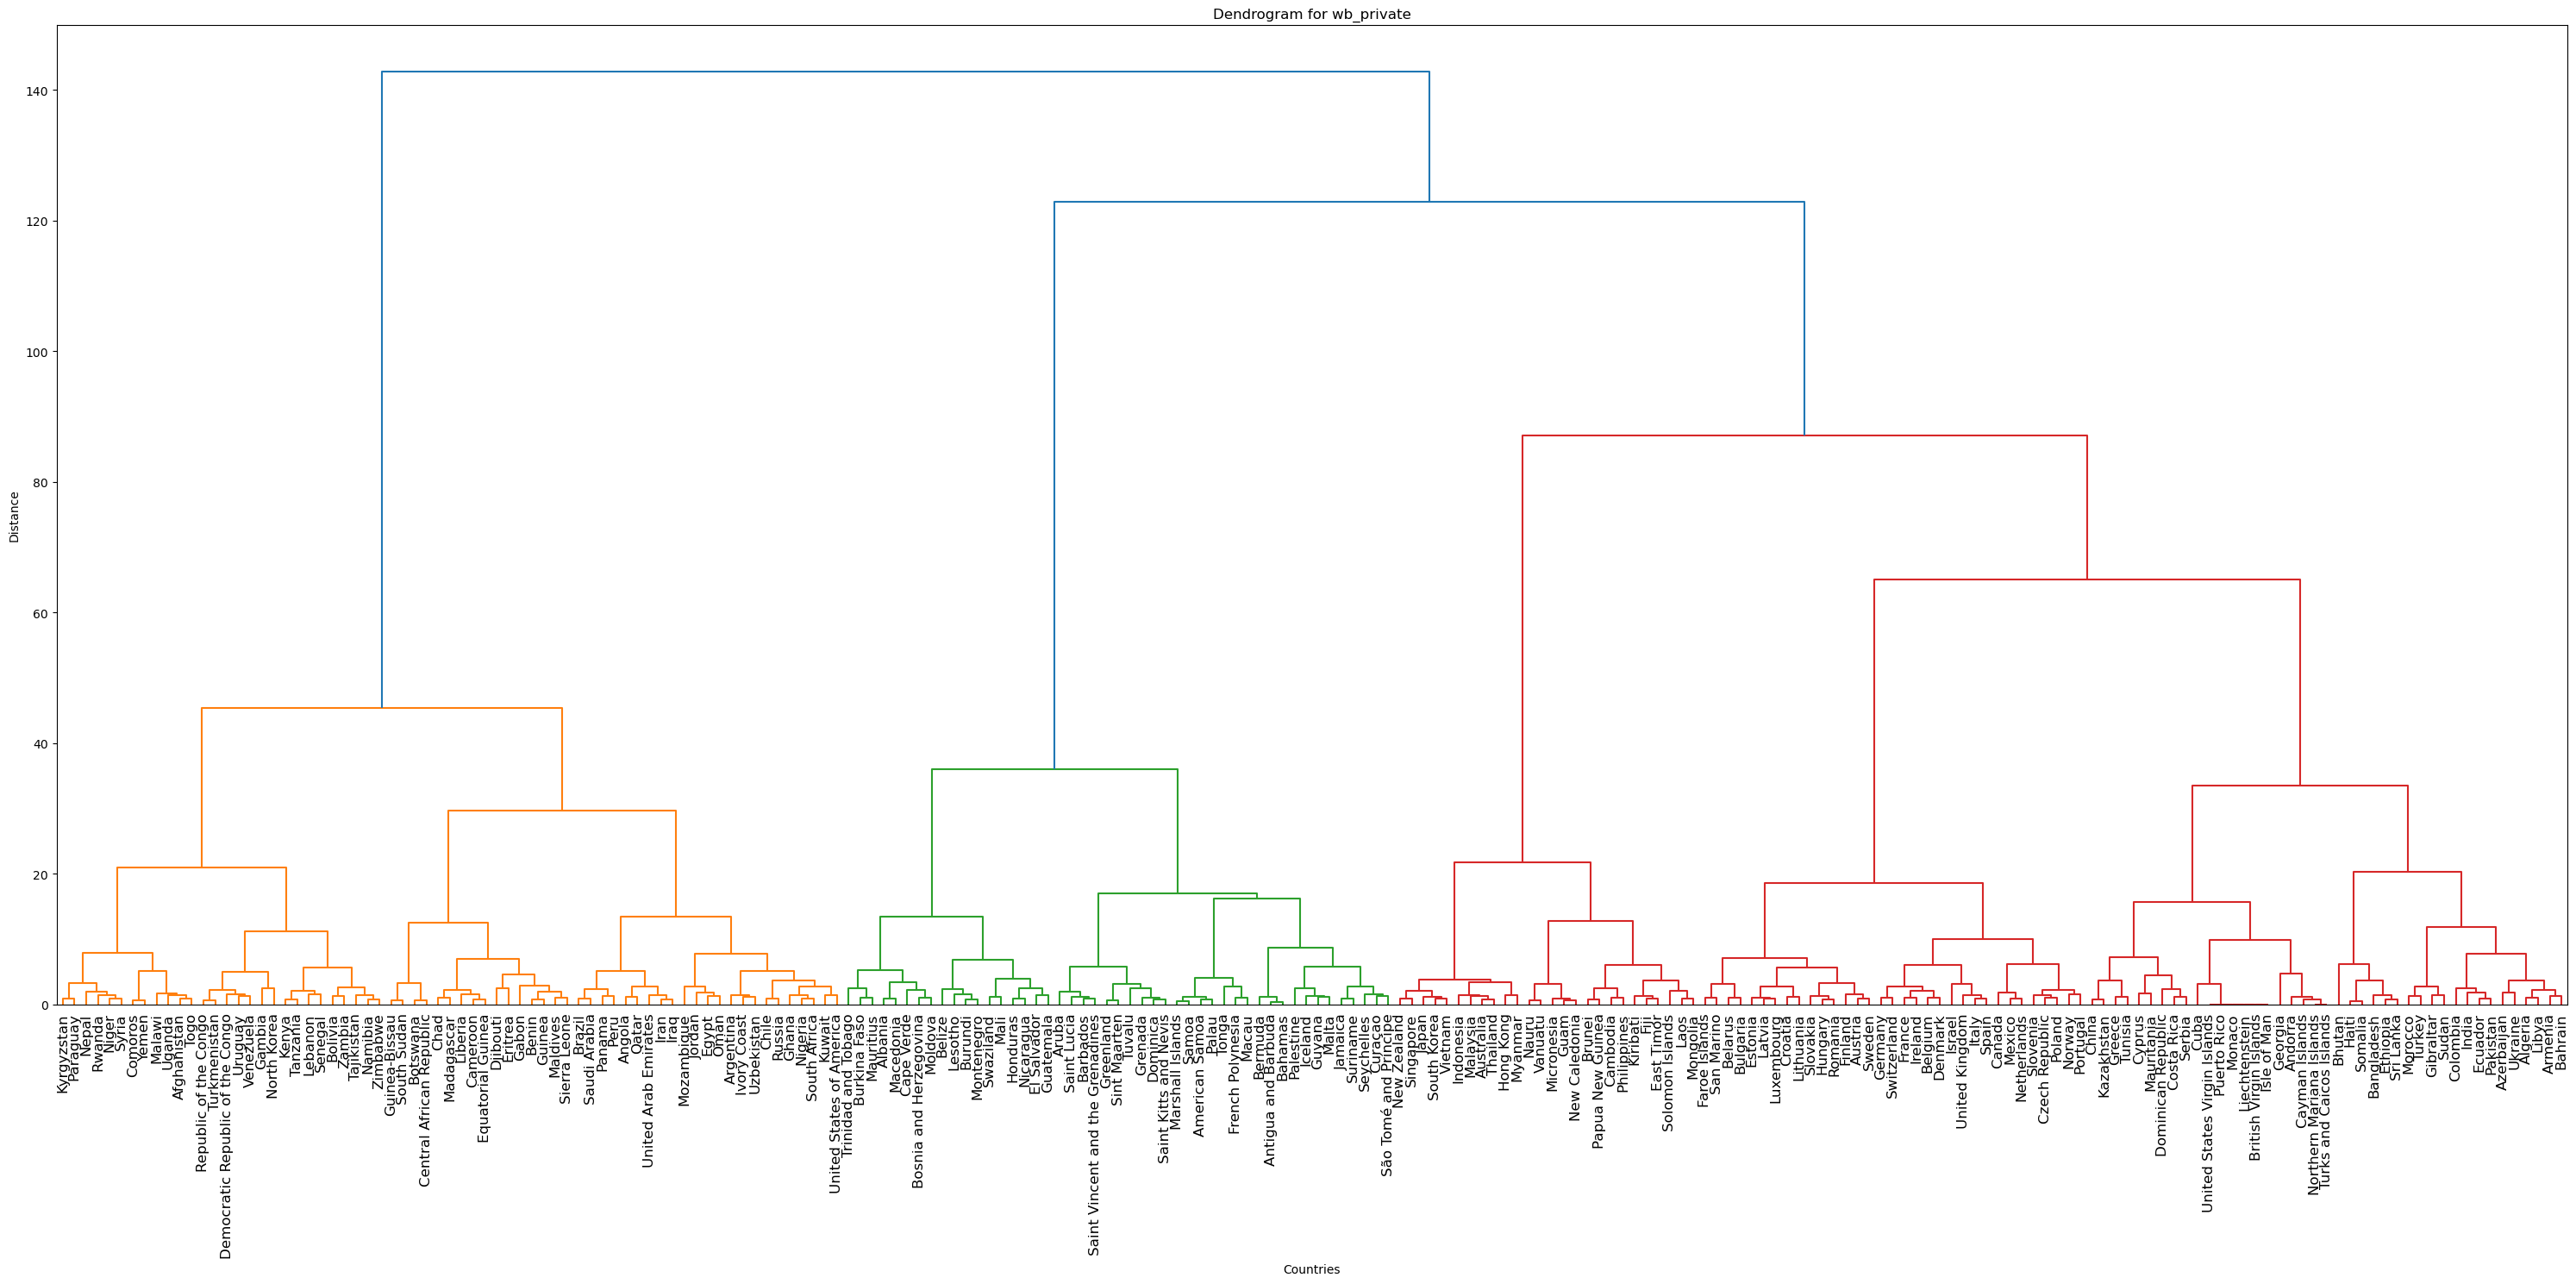

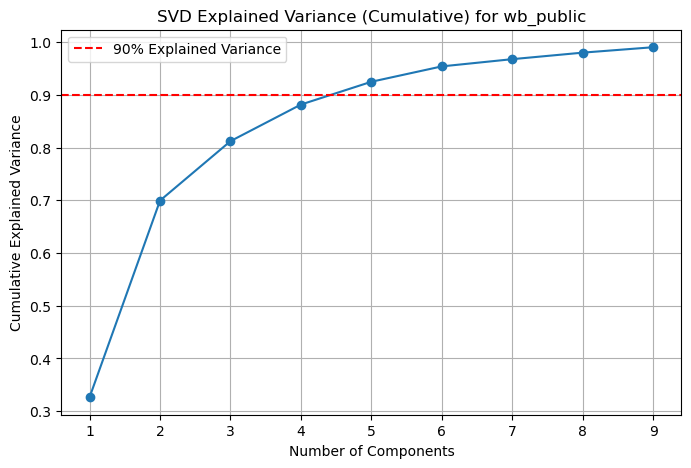

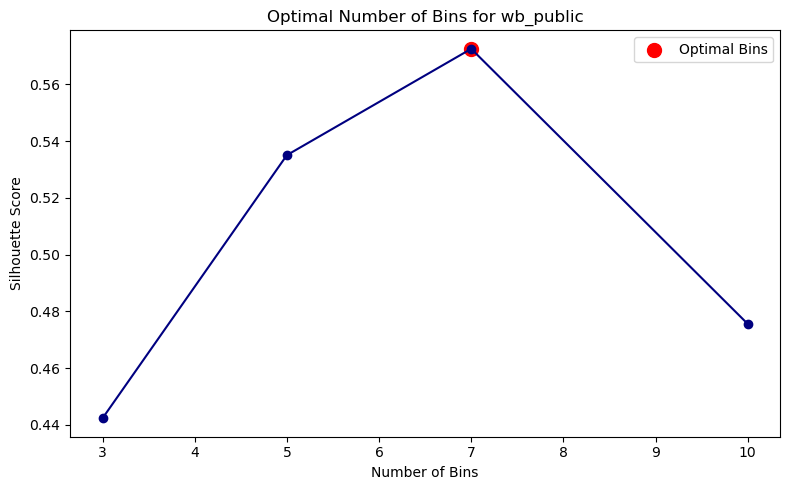

Selected 10 features for wb_public: ['Voice and Accountability: Number of Sources [VA.NO.SRC]', 'Statistical performance indicators (SPI): Pillar 3 data products score  (scale 0-100) [IQ.SPI.PIL3]', 'Regulatory Quality: Estimate [RQ.EST]', 'Political Stability and Absence of Violence/Terrorism: Estimate [PV.EST]', 'Voice and Accountability: Estimate [VA.EST]', 'Statistical performance indicators (SPI): Pillar 4 data sources score (scale 0-100) [IQ.SPI.PIL4]', 'Statistical performance indicators (SPI): Pillar 2 data services score (scale 0-100) [IQ.SPI.PIL2]', 'Statistical performance indicators (SPI): Overall score (scale 0-100) [IQ.SPI.OVRL]', 'Rule of Law: Estimate [RL.EST]', 'Control of Corruption: Estimate [CC.EST]']


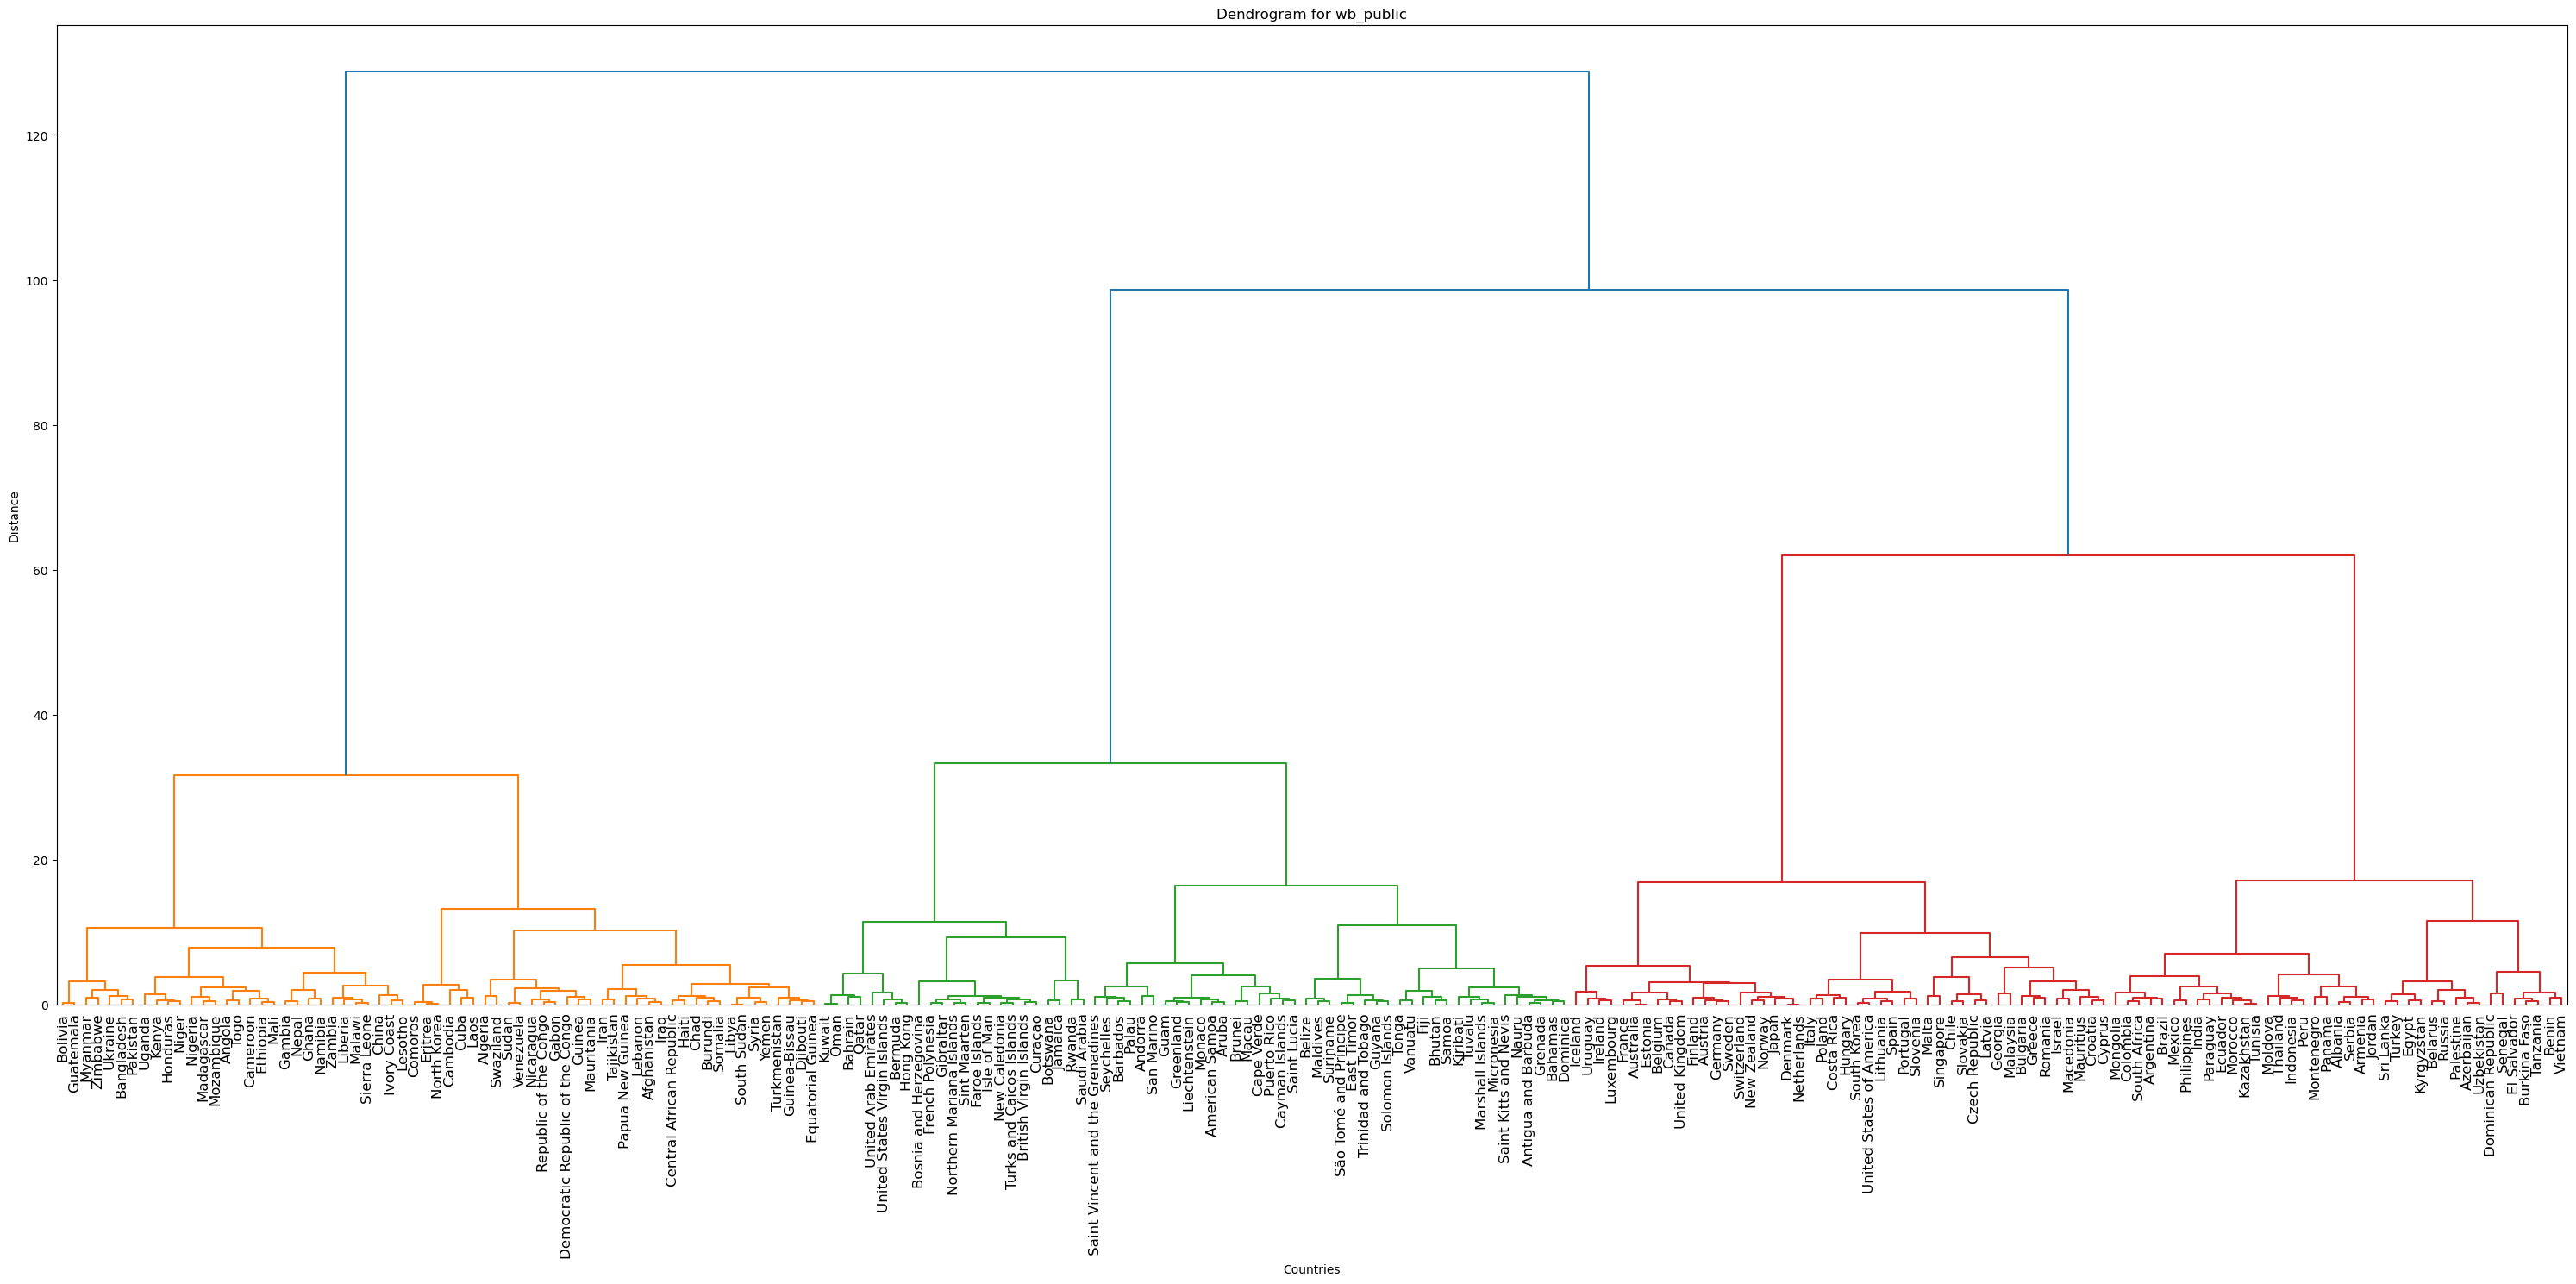

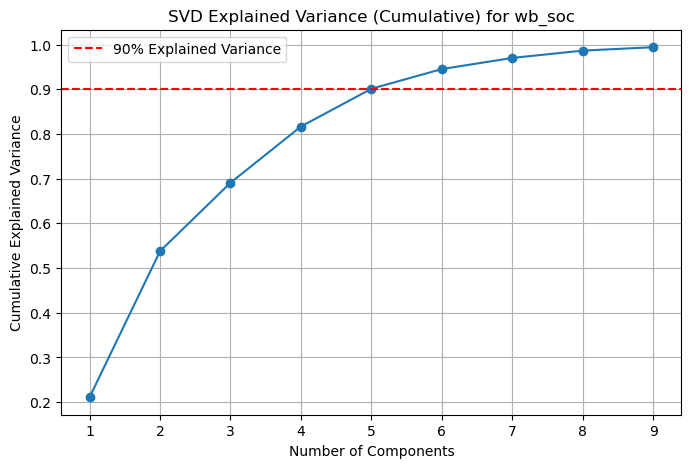

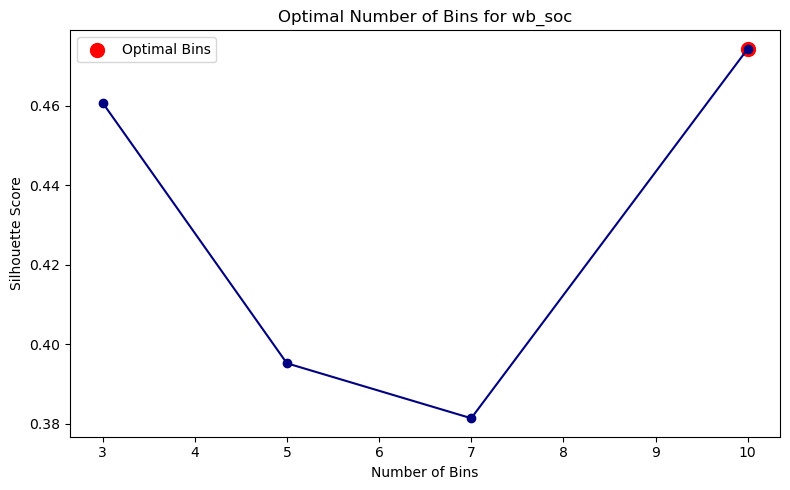

Selected 10 features for wb_soc: ['Net migration [SM.POP.NETM]', 'Refugees under the mandate of the UNHCR by country or territory of origin [SM.POP.RHCR.EO]', 'Employment to population ratio, 15+, total (%) (modeled ILO estimate) [SL.EMP.TOTL.SP.ZS]', 'Labor force, total [SL.TLF.TOTL.IN]', 'Labor force, female (% of total labor force) [SL.TLF.TOTL.FE.ZS]', 'Self-employed, female (% of female employment) (modeled ILO estimate) [SL.EMP.SELF.FE.ZS]', 'Share of youth not in education, employment or training, male (% of male youth population)  (modeled ILO estimate) [SL.UEM.NEET.MA.ME.ZS]', 'Unemployment, female (% of female labor force) (modeled ILO estimate) [SL.UEM.TOTL.FE.ZS]', 'Unemployment, male (% of male labor force) (modeled ILO estimate) [SL.UEM.TOTL.MA.ZS]', 'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate) [SL.TLF.ACTI.ZS]']


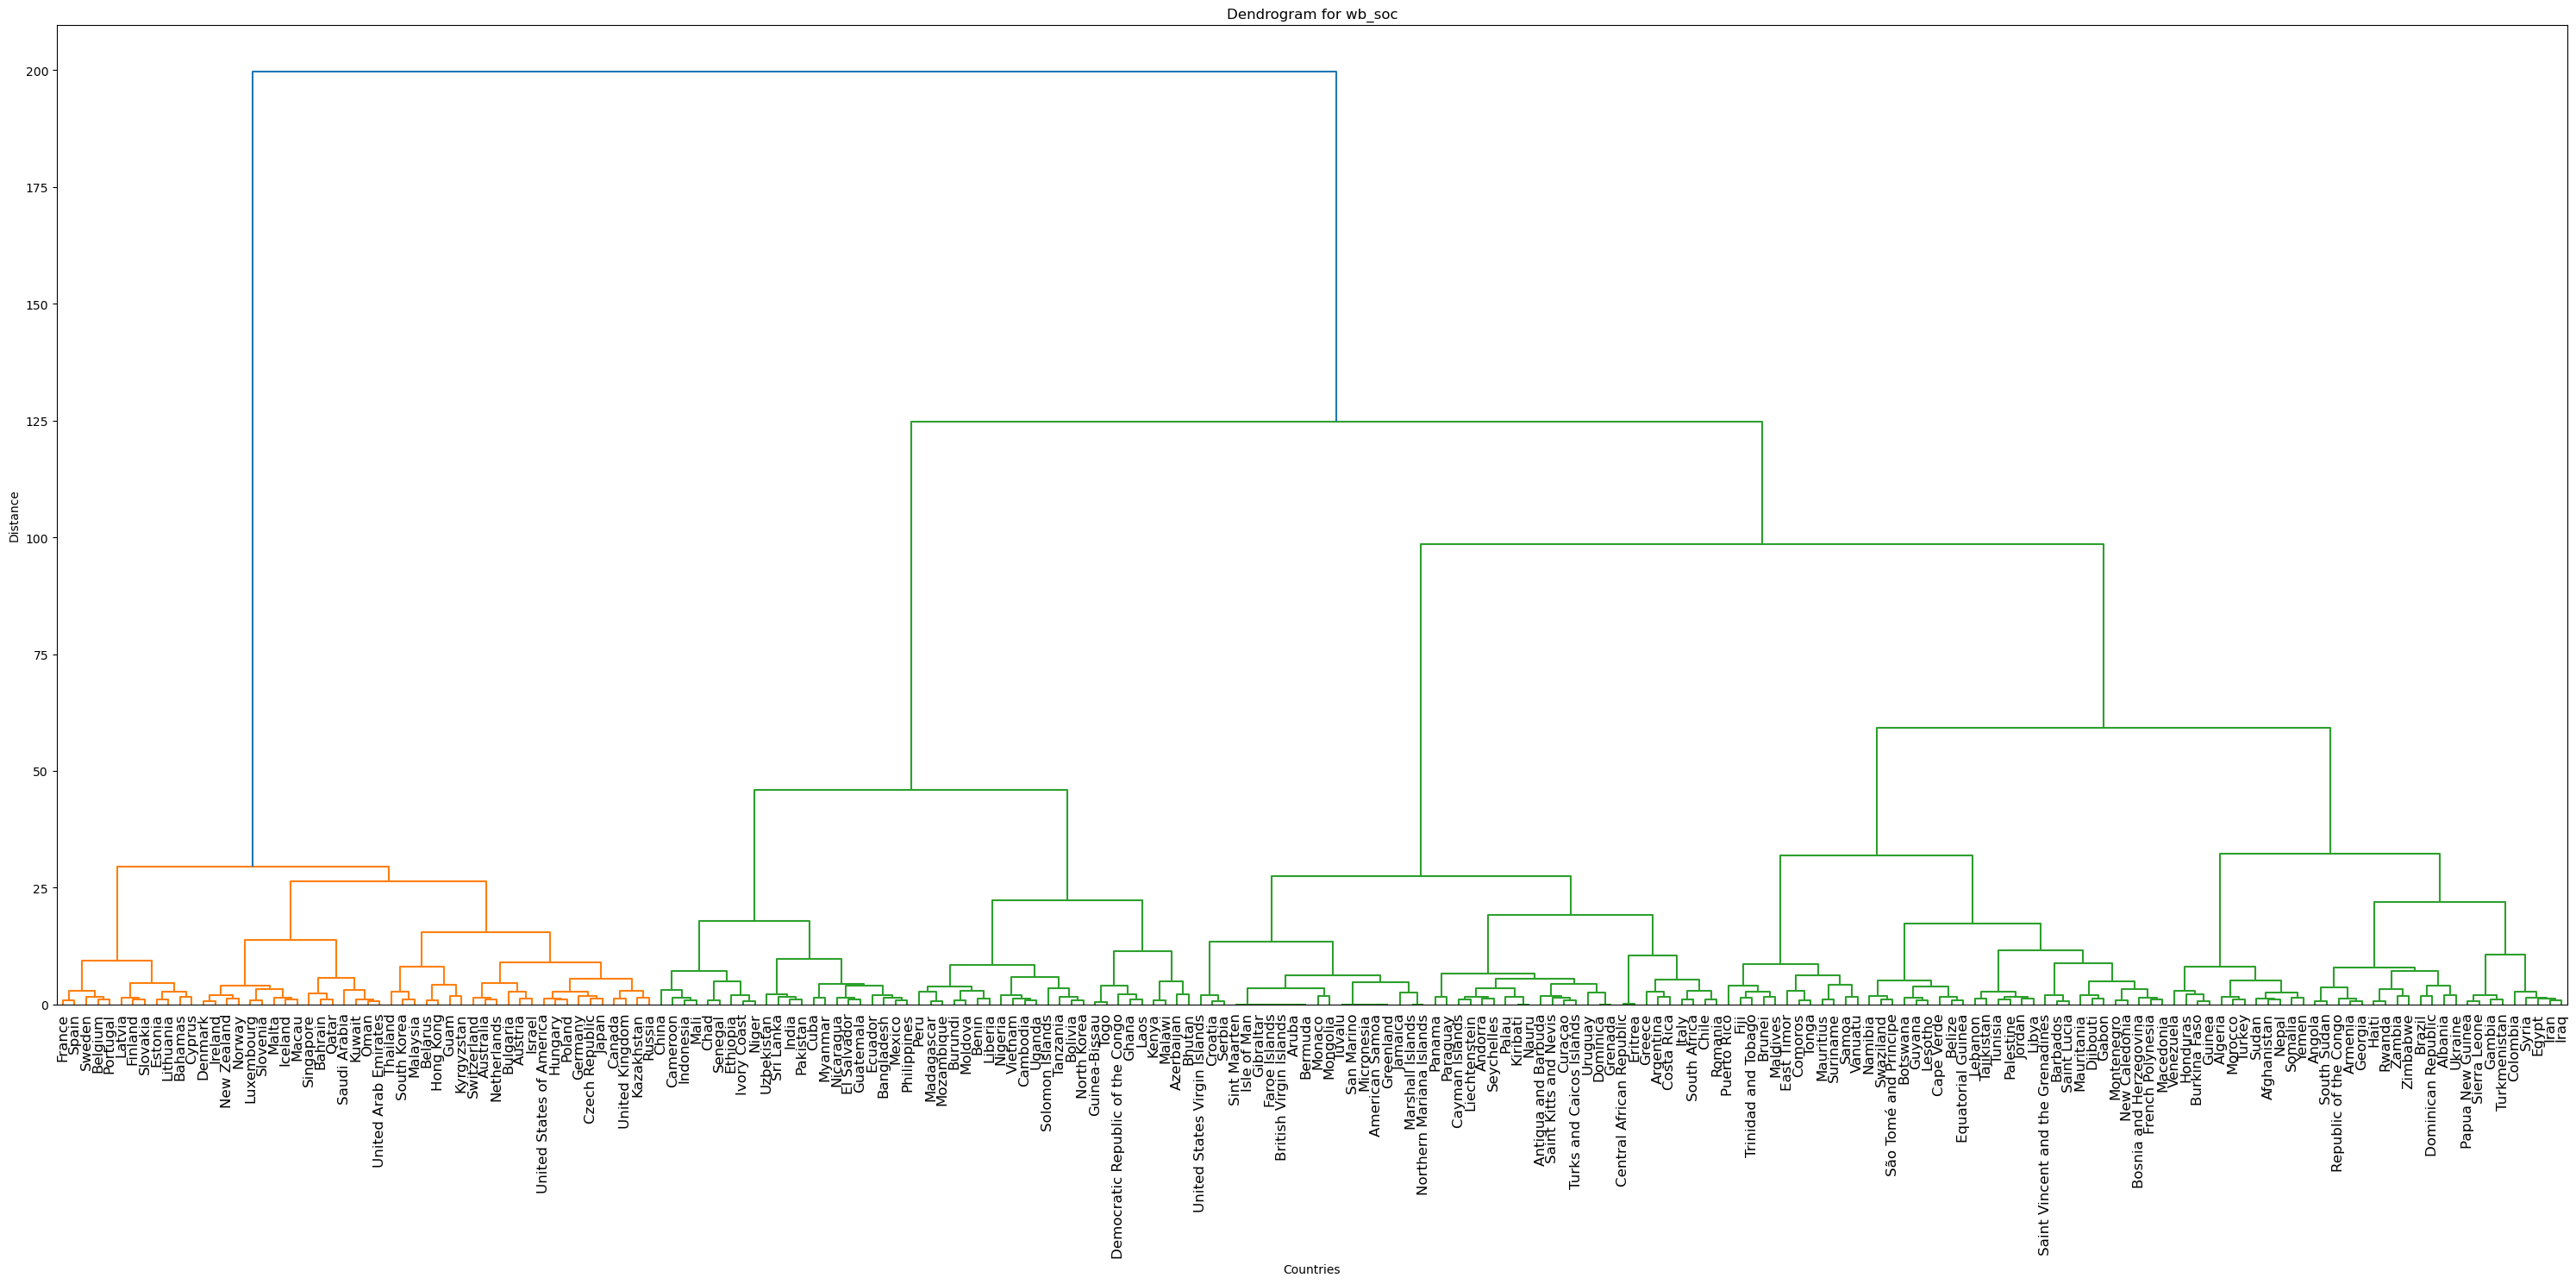


=== Analyzing with Dbscan ===


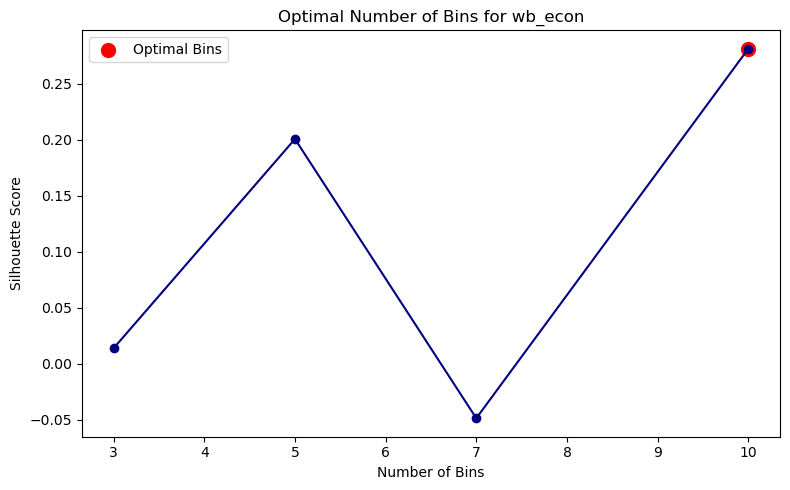

Selected 10 features for wb_econ: ['GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]', 'GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]', 'Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]', 'GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]', 'Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]', 'GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]', 'Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]', 'GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]', 'Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]']


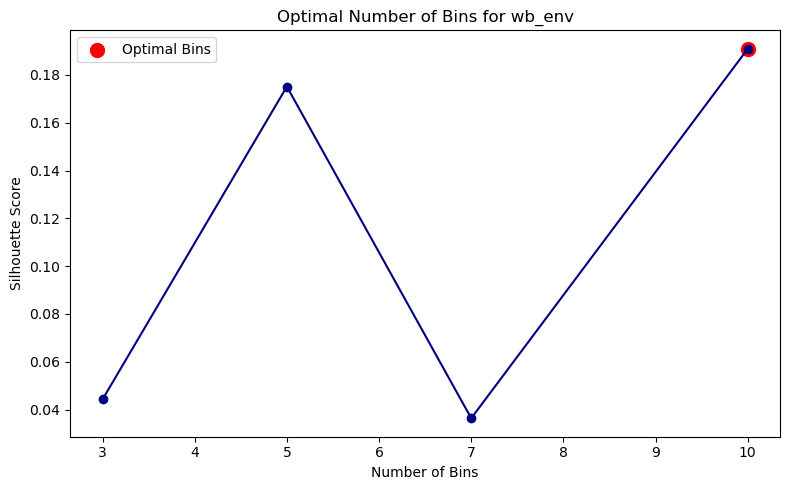

Selected 10 features for wb_env: ['Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]', 'Rural population (% of total population) [SP.RUR.TOTL.ZS]', 'Rural population [SP.RUR.TOTL]', 'Urban population growth (annual %) [SP.URB.GROW]', 'Forest area (% of land area) [AG.LND.FRST.ZS]', 'Population density (people per sq. km of land area) [EN.POP.DNST]', 'Forest area (sq. km) [AG.LND.FRST.K2]', 'Agricultural land (% of land area) [AG.LND.AGRI.ZS]', 'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e) [EN.GHG.CO2.MT.CE.AR5]', 'Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita) [EN.GHG.CO2.PC.CE.AR5]']


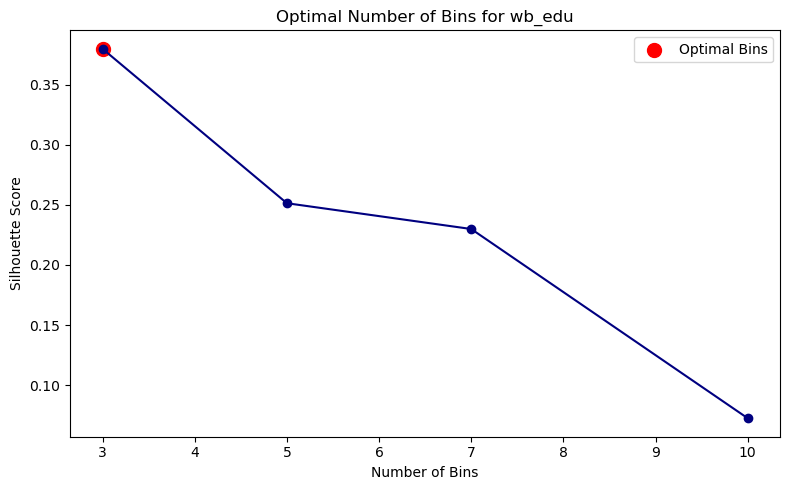

Selected 10 features for wb_edu: ['Primary education, pupils [SE.PRM.ENRL]', 'School enrollment, primary (% gross) [SE.PRM.ENRR]', 'Compulsory education, duration (years) [SE.COM.DURS]', 'Preprimary education, duration (years) [SE.PRE.DURS]', 'Secondary education, duration (years) [SE.SEC.DURS]', 'Primary education, teachers (% female) [SE.PRM.TCHR.FE.ZS]', 'Government expenditure on education, total (% of GDP) [SE.XPD.TOTL.GD.ZS]', 'Children out of school, primary [SE.PRM.UNER]', 'Children out of school (% of primary school age) [SE.PRM.UNER.ZS]', 'School enrollment, secondary (% gross) [SE.SEC.ENRR]']


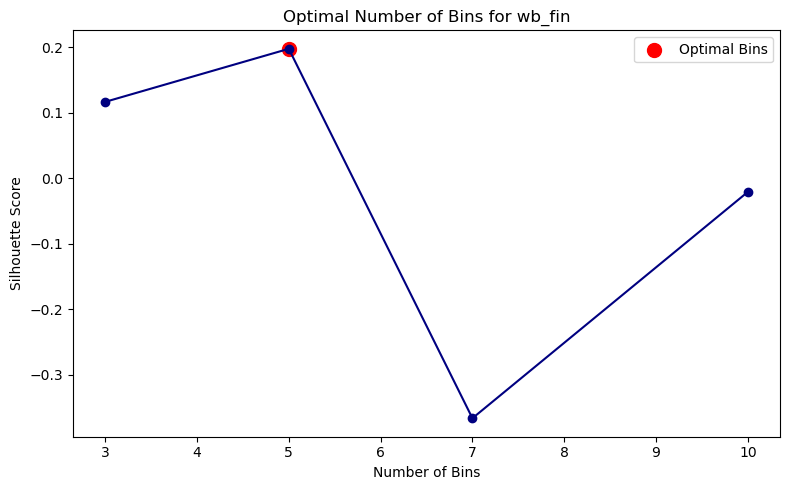

Selected 10 features for wb_fin: ['GDP deflator (base year varies by country) [NY.GDP.DEFL.ZS]', 'Inflation, GDP deflator (annual %) [NY.GDP.DEFL.KD.ZG]', 'Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]', 'Consumer price index (2010 = 100) [FP.CPI.TOTL]', 'DEC alternative conversion factor (LCU per US$) [PA.NUS.ATLS]', 'Official exchange rate (LCU per US$, period average) [PA.NUS.FCRF]', 'Commercial bank branches (per 100,000 adults) [FB.CBK.BRCH.P5]', 'Claims on central government, etc. (% GDP) [FS.AST.CGOV.GD.ZS]', 'Domestic credit to private sector (% of GDP) [FS.AST.PRVT.GD.ZS]', 'Bank liquid reserves to bank assets ratio (%) [FD.RES.LIQU.AS.ZS]']


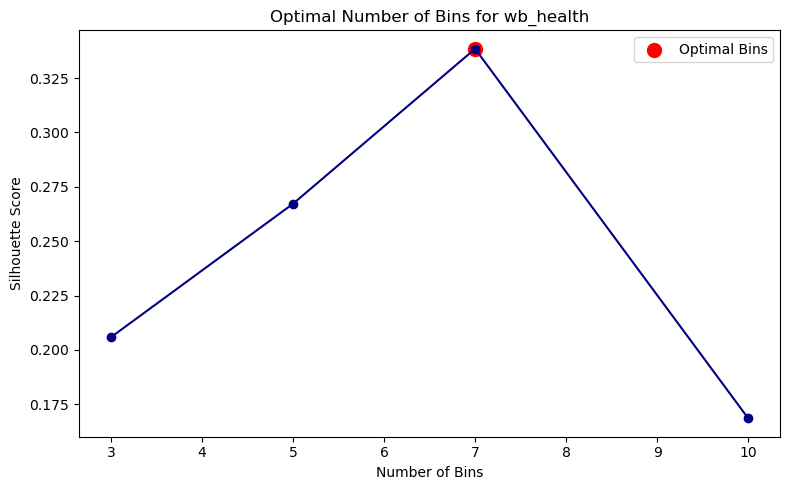

Selected 10 features for wb_health: ['Immunization, measles (% of children ages 12-23 months) [SH.IMM.MEAS]', 'Immunization, DPT (% of children ages 12-23 months) [SH.IMM.IDPT]', 'Number of maternal deaths [SH.MMR.DTHS]', 'Adolescent fertility rate (births per 1,000 women ages 15-19) [SP.ADO.TFRT]', 'Mortality rate, adult, male (per 1,000 male adults) [SP.DYN.AMRT.MA]', 'Number of deaths ages 5-9 years [SH.DTH.0509]', 'Out-of-pocket expenditure (% of current health expenditure) [SH.XPD.OOPC.CH.ZS]', 'Out-of-pocket expenditure per capita (current US$) [SH.XPD.OOPC.PC.CD]', 'Out-of-pocket expenditure per capita, PPP (current international $) [SH.XPD.OOPC.PP.CD]', 'People using at least basic sanitation services (% of population) [SH.STA.BASS.ZS]']


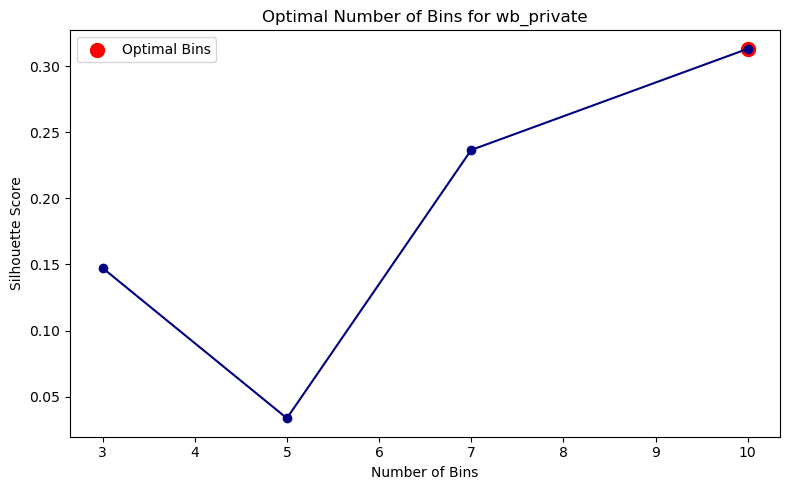

Selected 10 features for wb_private: ['Merchandise imports from high-income economies (% of total merchandise imports) [TM.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies in East Asia & Pacific (% of total merchandise imports) [TM.VAL.MRCH.R1.ZS]', 'Merchandise exports to low- and middle-income economies in East Asia & Pacific (% of total merchandise exports) [TX.VAL.MRCH.R1.ZS]', 'Merchandise exports (current US$) [TX.VAL.MRCH.CD.WT]', 'Merchandise imports (current US$) [TM.VAL.MRCH.CD.WT]', 'Merchandise exports to high-income economies (% of total merchandise exports) [TX.VAL.MRCH.HI.ZS]', 'Merchandise imports from low- and middle-income economies outside region (% of total merchandise imports) [TM.VAL.MRCH.OR.ZS]', 'Merchandise imports from low- and middle-income economies in South Asia (% of total merchandise imports) [TM.VAL.MRCH.R5.ZS]', 'Merchandise exports to low- and middle-income economies outside region (% of total merchandise exports) [TX.VAL.MR

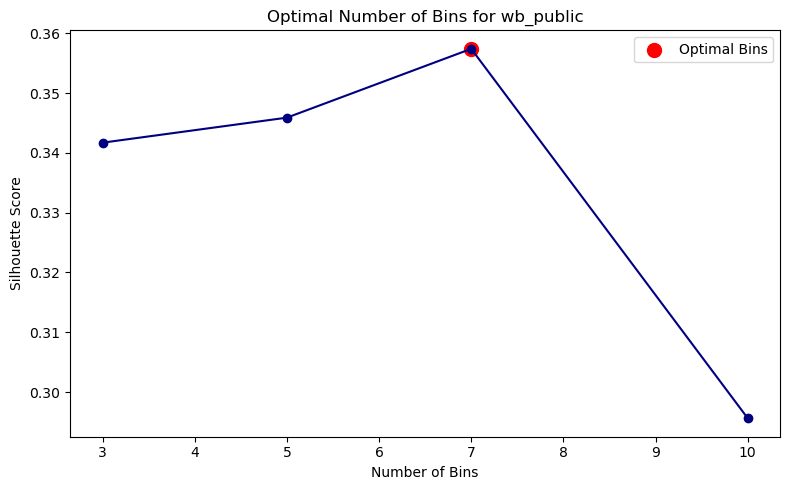

Selected 10 features for wb_public: ['Voice and Accountability: Number of Sources [VA.NO.SRC]', 'Statistical performance indicators (SPI): Pillar 3 data products score  (scale 0-100) [IQ.SPI.PIL3]', 'Regulatory Quality: Estimate [RQ.EST]', 'Political Stability and Absence of Violence/Terrorism: Estimate [PV.EST]', 'Voice and Accountability: Estimate [VA.EST]', 'Statistical performance indicators (SPI): Pillar 4 data sources score (scale 0-100) [IQ.SPI.PIL4]', 'Statistical performance indicators (SPI): Pillar 2 data services score (scale 0-100) [IQ.SPI.PIL2]', 'Statistical performance indicators (SPI): Overall score (scale 0-100) [IQ.SPI.OVRL]', 'Rule of Law: Estimate [RL.EST]', 'Control of Corruption: Estimate [CC.EST]']


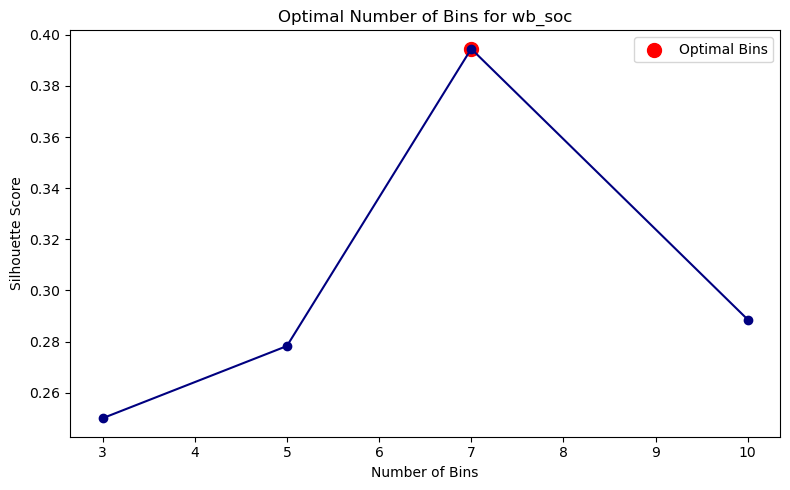

Selected 10 features for wb_soc: ['Unemployment, male (% of male labor force) (modeled ILO estimate) [SL.UEM.TOTL.MA.ZS]', 'Employment to population ratio, ages 15-24, female (%) (modeled ILO estimate) [SL.EMP.1524.SP.FE.ZS]', 'Labor force, female (% of total labor force) [SL.TLF.TOTL.FE.ZS]', 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate) [SL.TLF.CACT.FM.ZS]', 'Refugees under the mandate of the UNHCR by country or territory of origin [SM.POP.RHCR.EO]', 'Self-employed, female (% of female employment) (modeled ILO estimate) [SL.EMP.SELF.FE.ZS]', 'Share of youth not in education, employment or training, female (% of female youth population) (modeled ILO estimate) [SL.UEM.NEET.FE.ME.ZS]', 'Share of youth not in education, employment or training, male (% of male youth population)  (modeled ILO estimate) [SL.UEM.NEET.MA.ME.ZS]', 'Asylum-seekers by country or territory of origin [SM.POP.ASYS.EO]', 'Unemployment, female (% of female labor force) (modeled IL


--- Evaluation Metrics ---



--- NMI Matrices for Each Clustering Method ---

=== NMI Matrix for Kmeans ===


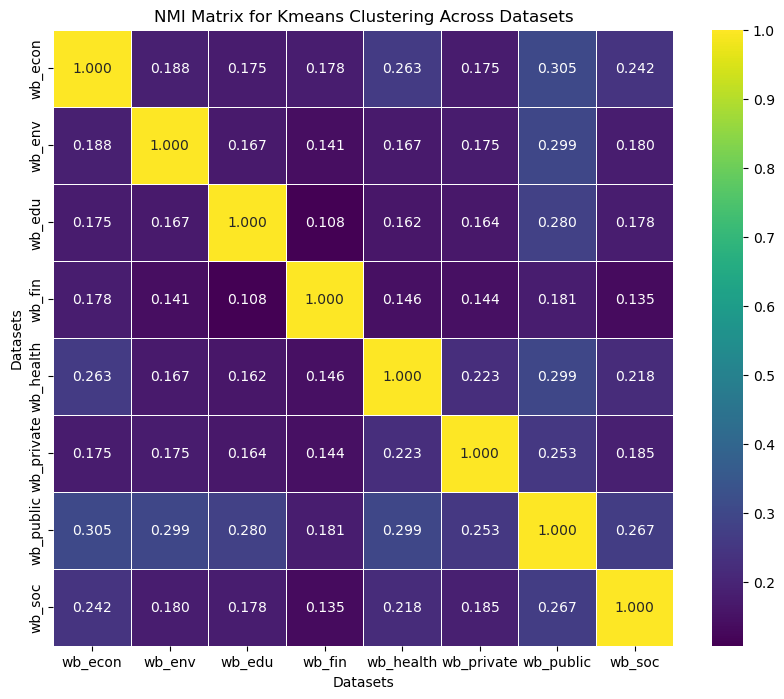


NMI Matrix for Kmeans:




=== NMI Matrix for Hierarchical ===


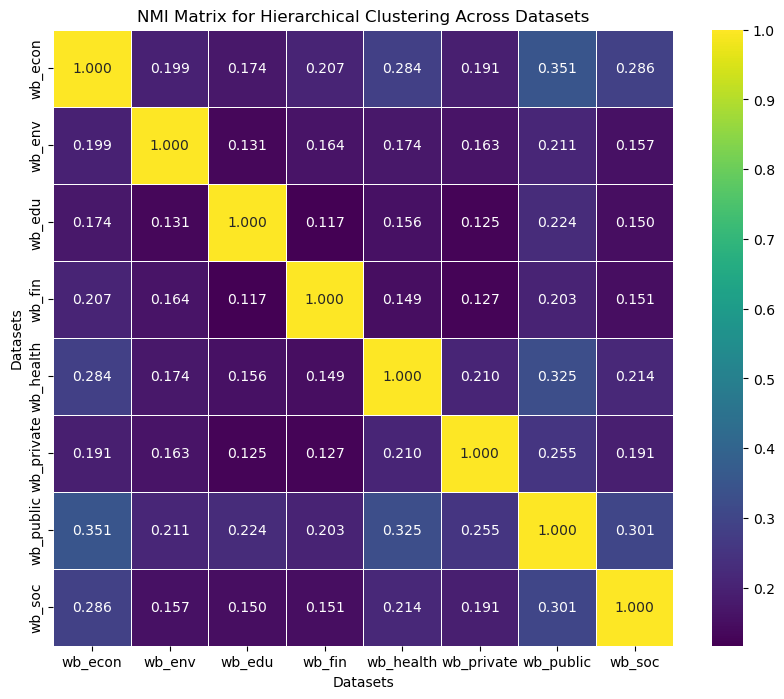


NMI Matrix for Hierarchical:




=== NMI Matrix for Dbscan ===


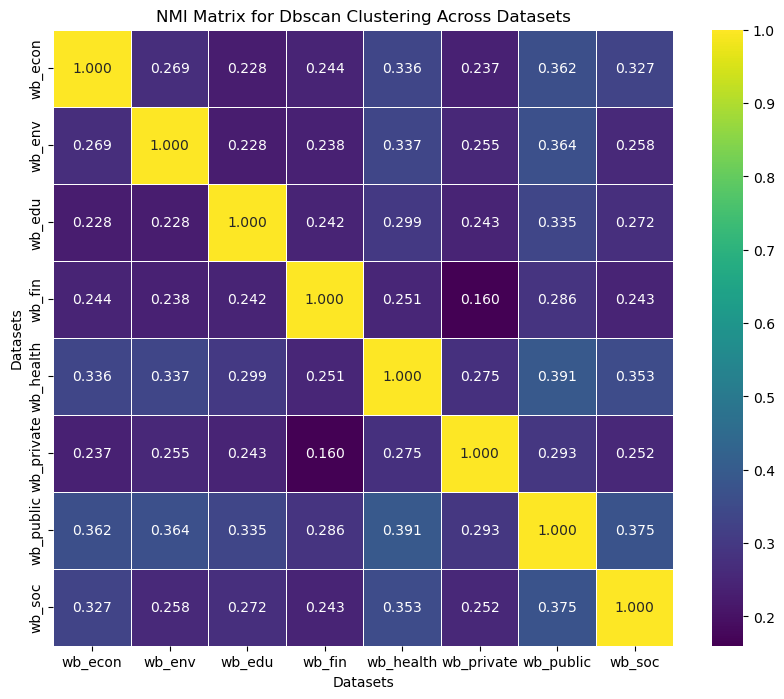


NMI Matrix for Dbscan:




--- NMI Matrices for Each Dataset Across Clustering Methods ---

=== NMI Matrix for Wb_econ Across Clustering Methods ===


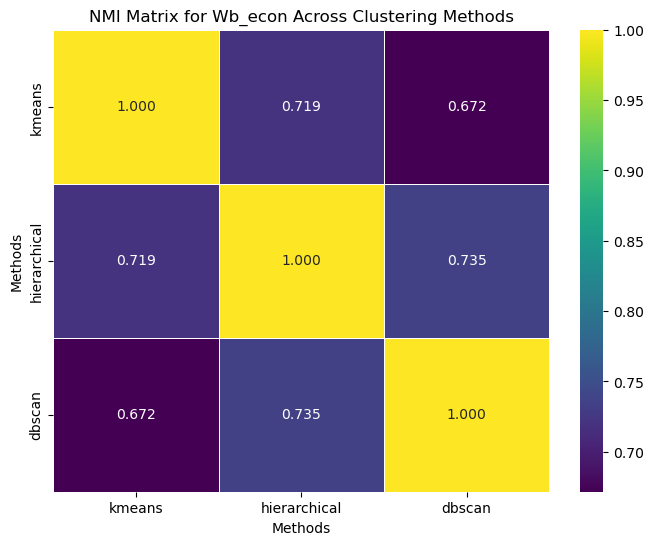


NMI Matrix for Wb_econ Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

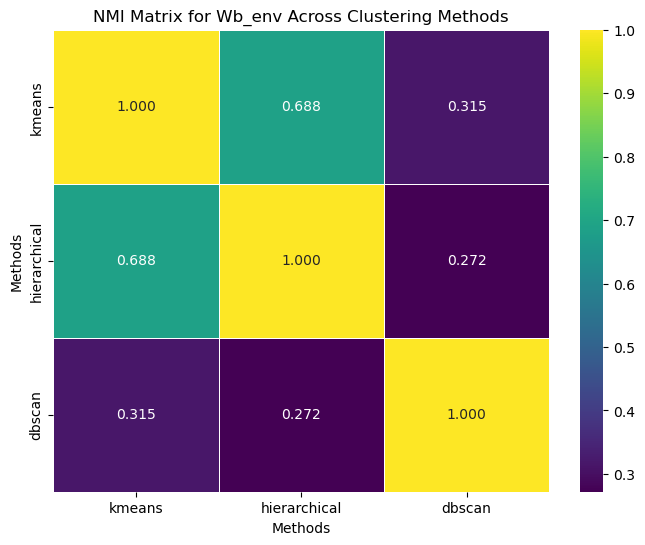


NMI Matrix for Wb_env Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

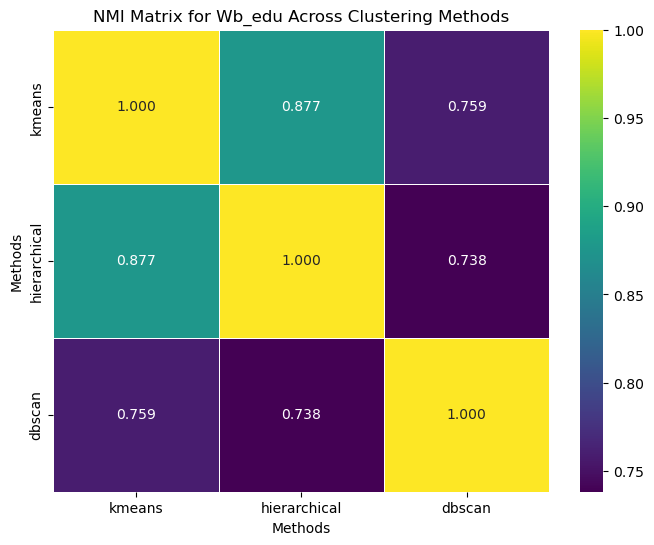


NMI Matrix for Wb_edu Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

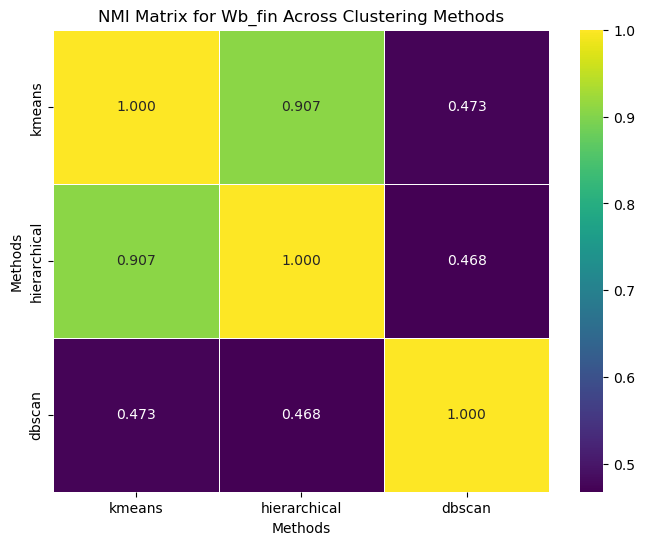


NMI Matrix for Wb_fin Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

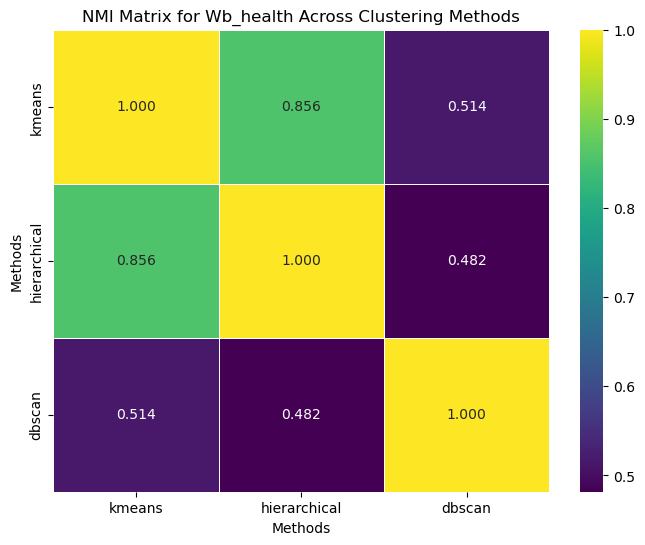


NMI Matrix for Wb_health Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

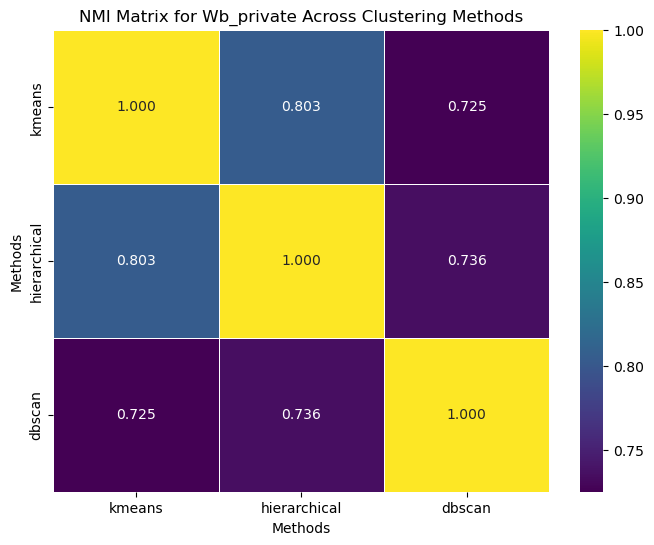


NMI Matrix for Wb_private Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

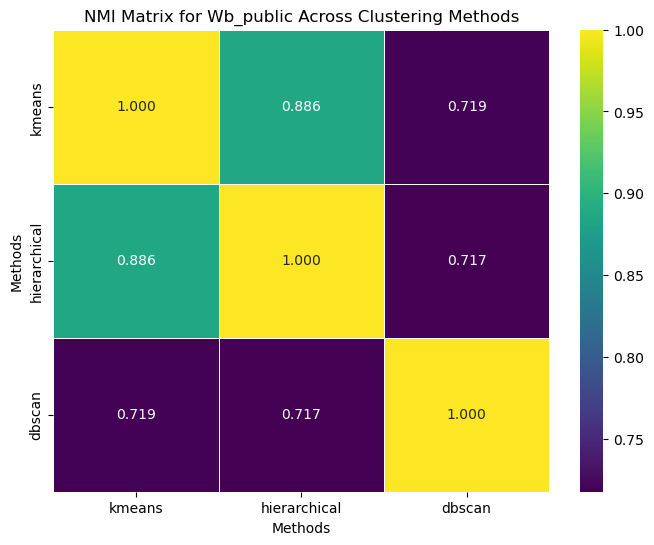


NMI Matrix for Wb_public Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

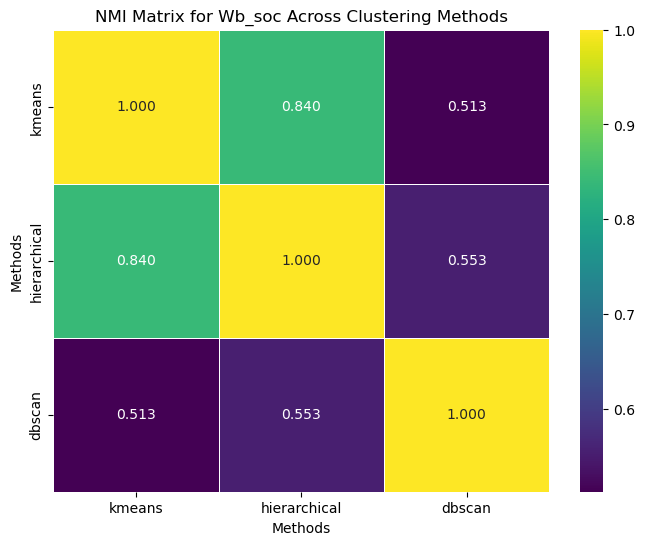


NMI Matrix for Wb_soc Across Clustering Methods:




--- Selected Features ---
**Wb_econ:**
- GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]
- GDP per capita (constant 2015 US$) [NY.GDP.PCAP.KD]
- GDP per capita (current US$) [NY.GDP.PCAP.CD]
- Personal remittances, received (current US$) [BX.TRF.PWKR.CD.DT]
- GDP, PPP (constant 2021 international $) [NY.GDP.MKTP.PP.KD]
- Personal remittances, received (% of GDP) [BX.TRF.PWKR.DT.GD.ZS]
- GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]
- Price level ratio of PPP conversion factor (GDP) to market exchange rate [PA.NUS.PPPC.RF]
- GDP per capita, PPP (constant 2021 international $) [NY.GDP.PCAP.PP.KD]
- Net primary income (Net income from abroad) (current LCU) [NY.GSR.NFCY.CN]

**Wb_env:**
- Terrestrial protected areas (% of total land area) [ER.LND.PTLD.ZS]
- Rural population (% of total population) [SP.RUR.TOTL.ZS]
- Rural population [SP.RUR.TOTL]
- Urban population growth (annual %) [SP.URB.GROW]
- Forest area (% of land area) [AG.LND.FRST.ZS]
- Population density (people per sq. 

In [8]:
_, cleaned_dfs, e_ix = load_and_clean_data(data_files, max_nan_percent=0.5)

all_selected_features = {}
if cleaned_dfs and e_ix is not None:
    print("\nLoaded datasets:", cleaned_dfs.keys())
    #for key, df in cleaned_dfs.items():
        #print(f"\nHead for {key}:\n{df.head()}")
        #print(f"\nNaN analysis for {key} (Shape: {df.shape}):")
        #nan_counts = df.isna().sum()
        #nan_percent = df.isna().mean() * 100
        #for col in df.columns:
        #    print(f"  {col}: {nan_counts[col]} NaN ({nan_percent[col]:.2f}%)")

    results = {}
    evaluation_metrics = []
    for clustering_method in ['kmeans', 'hierarchical', 'dbscan']:
        print(f"\n=== Analyzing with {clustering_method.capitalize()} ===")
        for name, df in cleaned_dfs.items():
            result_df, silhouette, wc_distance, bc_distance, selected_features, noise_ratio = analyze_dataset(
                df, name, e_ix, clustering_method=clustering_method
            )
            results[(name, clustering_method)] = result_df
            all_selected_features[name] = selected_features
            metrics = {
                "Dataset": name,
                "Method": clustering_method,
                "Silhouette Score": silhouette,
                "WC Distance": wc_distance,
                "BC Distance": bc_distance
            }
            if noise_ratio is not None:
                metrics["Noise Ratio"] = noise_ratio
            evaluation_metrics.append(metrics)

    print("\n--- Evaluation Metrics ---")
    evaluation_df = pd.DataFrame(evaluation_metrics)
    display(evaluation_df.style.set_caption("Clustering Evaluation Metrics").format({
        "Silhouette Score": "{:.4f}",
        "WC Distance": "{:.4f}",
        "BC Distance": "{:.4f}",
        "Noise Ratio": "{:.4f}" if "Noise Ratio" in evaluation_df.columns else None
    }))

# Po analizie zbiorów danych i zebraniu wyników w `results`

print("\n--- NMI Matrices for Each Clustering Method ---")
clustering_methods = ['kmeans', 'hierarchical', 'dbscan']

for method in clustering_methods:
    print(f"\n=== NMI Matrix for {method.capitalize()} ===")
    # Tworzenie macierzy NMI dla danej metody
    dataset_names = list(cleaned_dfs.keys())
    nmi_matrix = pd.DataFrame(
        index=dataset_names,
        columns=dataset_names,
        dtype=float
    )

    # Obliczanie NMI dla każdej pary zbiorów danych w ramach danej metody
    for name1 in dataset_names:
        for name2 in dataset_names:
            if name1 == name2:
                nmi_matrix.loc[name1, name2] = 1.0
            else:
                # Pobieranie wyników klastrowania dla obu zbiorów danych
                df1 = results.get((name1, method))
                df2 = results.get((name2, method))

                if df1 is not None and df2 is not None:
                    merged_df = pd.merge(df1, df2, on='location_key', how='inner')
                    if not merged_df.empty:
                        cluster1_col = f"Cluster_{name1}"
                        cluster2_col = f"Cluster_{name2}"
                        try:
                            nmi = normalized_mutual_info_score(
                                merged_df[cluster1_col], merged_df[cluster2_col]
                            )
                            nmi_matrix.loc[name1, name2] = nmi
                        except ValueError as e:
                            print(f"Error computing NMI for {name1} vs {name2} ({method}): {e}")
                            nmi_matrix.loc[name1, name2] = np.nan
                    else:
                        nmi_matrix.loc[name1, name2] = np.nan
                else:
                    nmi_matrix.loc[name1, name2] = np.nan

    # Wizualizacja macierzy NMI
    plt.figure(figsize=(10, 8))
    sns.heatmap(nmi_matrix, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
    plt.title(f'NMI Matrix for {method.capitalize()} Clustering Across Datasets')
    plt.xlabel('Datasets')
    plt.ylabel('Datasets')
    plt.show()

    # Wyświetlenie macierzy w formie tekstowej
    print(f"\nNMI Matrix for {method.capitalize()}:\n")
    display(nmi_matrix.style.set_caption(f"NMI Matrix for {method.capitalize()}").format("{:.3f}"))

# NMI między metodami dla każdego datasetu
print("\n--- NMI Matrices for Each Dataset Across Clustering Methods ---")
for dataset_name in cleaned_dfs.keys():
    print(f"\n=== NMI Matrix for {dataset_name.capitalize()} Across Clustering Methods ===")
    nmi_matrix = pd.DataFrame(
        index=clustering_methods,
        columns=clustering_methods,
        dtype=float
    )

    for method1 in clustering_methods:
        for method2 in clustering_methods:
            if method1 == method2:
                nmi_matrix.loc[method1, method2] = 1.0
            else:
                df1 = results.get((dataset_name, method1))
                df2 = results.get((dataset_name, method2))
                if df1 is not None and df2 is not None:
                    merged_df = pd.merge(df1, df2, on='location_key', how='inner')
                    if not merged_df.empty:
                        cluster1_col = f"Cluster_{dataset_name}"
                        cluster2_col = f"Cluster_{dataset_name}"
                        try:
                            nmi = normalized_mutual_info_score(
                                merged_df[cluster1_col + '_x'], merged_df[cluster2_col + '_y']
                            )
                            nmi_matrix.loc[method1, method2] = nmi
                        except ValueError as e:
                            print(f"Error computing NMI for {dataset_name} ({method1} vs {method2}): {e}")
                            nmi_matrix.loc[method1, method2] = np.nan
                    else:
                        nmi_matrix.loc[method1, method2] = np.nan
                else:
                    nmi_matrix.loc[method1, method2] = np.nan

    plt.figure(figsize=(8, 6))
    sns.heatmap(nmi_matrix, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
    plt.title(f'NMI Matrix for {dataset_name.capitalize()} Across Clustering Methods')
    plt.xlabel('Methods')
    plt.ylabel('Methods')
    plt.show()

    print(f"\nNMI Matrix for {dataset_name.capitalize()} Across Clustering Methods:\n")
    display(nmi_matrix.style.set_caption(f"NMI Matrix for {dataset_name.capitalize()} Across Clustering Methods").format("{:.3f}"))

    print("\n--- Selected Features ---")
    for name, features in all_selected_features.items():
        print(f"**{name.capitalize()}:**")
        if features:
            for feature in features:
                print(f"- {feature}")
        else:
            print("- No features selected.")
        print()